In [88]:
import json
import pandas as pd
import numpy as np
import sklearn
import os, sys, time, re, math
import matplotlib.pyplot as plt
import seaborn as sns
import random
import openpyxl
import textwrap
from tqdm import tqdm
from matplotlib.lines import Line2D
import warnings
import pickle

from sklearn.linear_model import LinearRegression as linR
from sklearn.linear_model import LogisticRegression as logR
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn import metrics
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder

from yellowbrick.classifier import ROCAUC
from yellowbrick.datasets import load_game


from xgboost import XGBRegressor
from xgboost import XGBClassifier

import shap
import IProgress
import ipywidgets 
shap.initjs()

%matplotlib inline

In [127]:
# Plotting methods
  
def plot_matrix(matrix, title = "Confusion Matrix", save_dir=None, both = False):
    fig = plt.figure(facecolor = 'white')
    ax1 = fig.add_subplot(111)
    # create heatmap
    ax1 = sns.heatmap(pd.DataFrame(matrix), annot=True, cmap="coolwarm" ,fmt='g', ax = ax1)
    fig.suptitle(title, va = 'center',size = 20, weight = 'bold')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.xticks([0.5,1.5,2.5], ['Small', 'Normal', 'Large'])
    plt.yticks([0.5,1.5,2.5], ['Small', 'Normal', 'Large'])
    if save_dir is not None:
        title = title.replace('\n', '').replace(' ', '_')
        out_path = os.path.join(save_dir, title + '.png')
        plt.savefig(out_path, format = 'png', dpi = 300, bbox_inches = 'tight')
    if save_dir is None or both: 
        plt.show()
    plt.close()
    
def plot_feature_importance(model, df = None, number = None, title = None, save_path = None, disp = False):
    if isinstance(model, RandomForestClassifier):
        plot_feature_rf(model, number, title, save_path, disp)
    elif isinstance(model, logR):
        plot_feature_logr(model, number, title, save_path, disp)
    elif isinstance(model, svm._classes.SVC):
        plot_feature_svm(model, df, number, title, save_path, disp)
    elif isinstance(model, XGBClassifier):
        plot_feature_xgb(model, df, number, title, save_path, disp)
        
        

def plot_feature_rf(model, number = None, title = None, save_path = None, disp = False):
    fig = plt.figure(facecolor = 'white', figsize = (15,5))
    ax = fig.add_subplot(111)
    x = model.feature_names_in_
    y = abs(model.feature_importances_)
    x = [clean_title(n) for n in x]
    
    if number is None or number == 0:
        number = len(x)
    merge_l = merge_lists(x,y)
    merge_l.sort(key = lambda x: x[1], reverse = True)
    merge_l = merge_l[:number]
    x_sort, y_sort = zip(*merge_l)
    
    #ax.set_xticks([x for x in range(len(y))])
    ax.set_xticklabels(x_sort, ha = 'right', rotation = 45)
    ax.set_ylim([np.min(y_sort), np.max(y_sort)*1.05])
    print_mod_order(x_sort, y_sort)
    ax = plt.bar(x_sort, y_sort)
    if title is None:
        title = "Place Holder"
    else:
        title = title.replace('_', ' ')
    fig.suptitle(title.title(), va = 'center',size = 20, weight = 'bold')
    
    if save_path is not None:
        out_file = os.path.join(save_path, title.replace(' ', '_') + '.png')
        plt.savefig(out_file, format = 'png', dpi = 300, bbox_inches = 'tight')
    if save_path is None or disp:
        plt.show()

    
    
def plot_feature_logr(model, number = None, title = None, save_path = None, disp = False):
    fig = plt.figure(facecolor = 'white', figsize = (10,9))
    
    for i, size in zip(range(len(model_list[0].classes_)), ['Small', 'Normal', 'Large']):
        ax = fig.add_subplot(3, 1, i+1)
        y = abs(model.coef_[i])
        x = model.feature_names_in_
        x = [clean_title(n) for n in x]
    
        if number is None or number == 0:
            number = len(x)
        merge_l = merge_lists(x,y)
        merge_l.sort(key = lambda x: x[1], reverse = True)
        merge_l = merge_l[:number]
        x_sort, y_sort = zip(*merge_l)
        #ax.tick_params(axis='x', labelrotation = 70)
        ax.set_xticklabels(x_sort, ha = 'right', rotation = 45)
        ax.set_ylim([np.min(y_sort), np.max(y_sort)*1.05])
        print_mod_order(x_sort, y_sort)
        ax = plt.bar(x_sort, y_sort)
        
    if title is None:
        title = "Place Holder"
    else:
        title = title.replace('_', ' ')
    fig.suptitle(title.title(), va = 'center',size = 20, weight = 'bold')
    plt.subplots_adjust(hspace = 1.5)
    fig.align_labels()
    
    if save_path is not None:
        out_file = os.path.join(save_path, title.replace(' ', '_') + '.png')
        plt.savefig(out_file, format = 'png', dpi = 300, bbox_inches = 'tight')
    if save_path is None or disp:
        plt.show()
    

def plot_feature_xgb(model, df = None, number = None, title = None, save_path = None, disp = False):  
    fig = plt.figure(facecolor = 'white', figsize = (15,12))
    
    for i, size in zip(range(len(model_list[0].classes_)), ['Small', 'Normal', 'Large']):
        ax = fig.add_subplot(3, 1, i+1)
        x = df.index.tolist()[:-2]
        #abs(np.mean(shap_values[1], axis = 0))
        shap_vals = get_shap_vals(model, df)
        y = abs(np.mean(shap_vals[i], axis = 0))
        x = [clean_title(n) for n in x]
             
        if number is None or number == 0:
            number = len(x)
        merge_l = merge_lists(x,y)
        merge_l.sort(key = lambda x: x[1], reverse = True)
        merge_l = merge_l[:number]
        x_sort, y_sort = zip(*merge_l)
        #ax.tick_params(axis='x', labelrotation = 70)
        ax.set_xticklabels(x_sort, ha = 'right', rotation = 45)
        ax.set_ylim([np.min(y_sort), np.max(y_sort)*1.05])
        print_mod_order(x_sort, y_sort)
        ax = plt.bar(x_sort, y_sort)
        
    if title is None:
        title = "Place Holder"
    else:
        title = title.replace('_', ' ')
    fig.suptitle(title.title(), va = 'center',size = 20, weight = 'bold')
    plt.subplots_adjust(hspace = 1.5)
    fig.align_labels()
    
    if save_path is not None:
        out_file = os.path.join(save_path, title.replace(' ', '_') + '.png')
        plt.savefig(out_file, format = 'png', dpi = 300, bbox_inches = 'tight')
    if save_path is None or disp:
        plt.show() 
        
        
def plot_feature_svm(model, df = None, number = None, title = None, save_path = None, disp = False):  
    fig = plt.figure(facecolor = 'white', figsize = (15,12))
    
    for i, size in zip(range(len(model_list[0].classes_)), ['Small', 'Normal', 'Large']):
        ax = fig.add_subplot(3, 1, i+1)
        x = df.index.tolist()[:-2]
        #abs(np.mean(shap_values[1], axis = 0))
        shap_vals = get_shap_vals(model, df)
        y = abs(np.mean(shap_vals[i], axis = 0))
        x = [clean_title(n) for n in x]
             
        if number is None or number == 0:
            number = len(x)
        merge_l = merge_lists(x,y)
        merge_l.sort(key = lambda x: x[1], reverse = True)
        merge_l = merge_l[:number]
        x_sort, y_sort = zip(*merge_l)
        #ax.tick_params(axis='x', labelrotation = 70)
        ax.set_xticklabels(x_sort, ha = 'right', rotation = 45)
        ax.set_ylim([np.min(y_sort), np.max(y_sort)*1.05])
        print_mod_order(x_sort, y_sort)
        ax = plt.bar(x_sort, y_sort)
        
    if title is None:
        title = "Place Holder"
    else:
        title = title.replace('_', ' ')
    fig.suptitle(title.title(), va = 'center',size = 20, weight = 'bold')
    plt.subplots_adjust(hspace = 1.5)
    fig.align_labels()
    
    if save_path is not None:
        out_file = os.path.join(save_path, title.replace(' ', '_') + '.png')
        plt.savefig(out_file, format = 'png', dpi = 300, bbox_inches = 'tight')
    if save_path is None or disp:
        plt.show() 
        
def plot_roc(model, df, title = None, save_path = None, disp = False):
    x = df.iloc[:-2,:].T
    y = df.iloc[-1,:]
    
    train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.8) 
    y_prob_pred_cnb = model.predict_proba(test_x)

    # roc curve for classes
    fpr = {}
    tpr = {}
    thresh = {}
    
    mod_auroc = roc_auc_score(test_y, y_prob_pred_cnb, multi_class='ovo', average='weighted')
    n_class = 3
    fig = plt.figure(facecolor = 'white', figsize = (5,5), dpi = 300)
    ax = fig.add_subplot(111)
    for i in range(n_class):    
        fpr[i], tpr[i], thresh[i] = roc_curve(test_y, y_prob_pred_cnb[:,i], pos_label=i)

    # plotting
    thick = 0.6
    ax = plt.plot(fpr[0], tpr[0], linestyle='--', linewidth = thick, color='red', label='Small vs Rest')
    ax = plt.plot(fpr[1], tpr[1], linestyle='--', linewidth = thick, color='grey', label='Normal vs Rest')
    ax = plt.plot(fpr[2], tpr[2], linestyle='--', linewidth = thick, color='blue', label='Large vs Rest')
    text_dict = {'fontsize': 5,}
    #ax = plt.text(0.5, 0.99, 'Weighted AUROC: {:.3f}'.format(mod_auroc), text_dict)
    plt.title('Weighted AUROC: {:.3f}'.format(mod_auroc), fontsize = 12)
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive rate')
    plt.legend(loc='best')
    
    if title is None:
        title = "Multiclass ROC curve"
    else:
        title = title.replace('_', ' ')
    fig.suptitle(title.title(), va = 'center',size = 20, weight = 'bold')
    
    if save_path is not None:
        out_file = os.path.join(save_path, title.replace(' ', '_') + '.png')
        plt.savefig(out_file, format = 'png', dpi = 300, bbox_inches = 'tight')
    if save_path is None or disp:
        plt.show()
    plt.show()


def plot_yellowbrick_roc(model, df, title, save_path = None, disp = False):
    X = df.iloc[:-2,:].T
    y = df.iloc[-1,:]
    
    y = LabelEncoder().fit_transform(y)
    
    # Create the train and test data
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

    # Instaniate the classification model and visualizer
    fig = plt.figure(facecolor = 'white', figsize = (5,5), dpi = 300)
    
    ax = fig.add_subplot(111)
    title = clean_title(title, wrap = True)
    fig.suptitle(title.title(), va = 'center',size = 20, weight = 'bold')
    ax = visualizer = ROCAUC(model, classes=["Small", "Normal", "Large"], ax = ax)

    visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
    visualizer.score(X_test, y_test)        # Evaluate the model on the test data
    
    if save_path is not None:
        out_file = os.path.join(save_path, title.replace(' ', '_').replace('\n','') + '.png')
        plt.savefig(out_file, format = 'png', dpi = 300, bbox_inches = 'tight')
    if save_path is None or disp:
        visualizer.show()
        plt.show()    
    
    
def print_mod_order(x_sort, y_sort):
    for enum, (a, b) in enumerate(zip(x_sort,y_sort)):
        print("{:3d}: {:<40s} {:.3f}".format(enum+1, clean_title(a, wrap = False), b))
    print()
    
    
def clean_title(title, wrap = True):
    title = title.replace('\n', '')
    s_l = title.split('_')
    ind = 0
    for enum, s in enumerate(s_l):
        if s == 'original':
            ind = enum + 1
            break
            
    if s_l[ind] == 'firstorder':
        s_l[ind] = 'FO'
    if wrap:
        return textwrap.fill(' '.join(s_l[ind:]), 20)
    else:
        return ' '.join(s_l[ind:])

In [134]:
# General Methods

def generate_rand_list(length, maxn, seed = None):
    if seed is not None:
        random.seed(seed)
    randl = []
    
    while len(randl) < length:
        new_rand = random.randrange(0, maxn)
        if new_rand not in randl:
            randl.append(new_rand)
    return randl

def merge_lists(*kargs):
    a_len = len(kargs[0])
    for arg in kargs:
        if len(arg) != a_len:
            return None
        
    flist = []
    for i in range(a_len):
        temp = []
        for arg in kargs:
            temp.append(arg[i])
        flist.append(tuple(temp))
    return flist


def balance_df(df):
    small = None
    low_val = None
    for val in [-1, 0, 1]:
        res = (df.iloc[-1,:] == val).sum()
        if small is None or res < small:
            small = res
            low_val = val
            
    small_df = df.loc[:,df.iloc[-1,:] == -1].copy()
    norm_df = df.loc[:,df.iloc[-1,:] == 0].copy()
    large_df = df.loc[:,df.iloc[-1,:] == 1].copy()

    small_rand = generate_rand_list(small, small_df.shape[1])
    norm_rand = generate_rand_list(small, norm_df.shape[1])
    large_rand = generate_rand_list(small, large_df.shape[1])


    small_new = small_df.iloc[:,small_rand]
    norm_new = norm_df.iloc[:,norm_rand]
    large_new = large_df.iloc[:,large_rand]
    
    final_df = pd.concat([small_new, norm_new, large_new], axis = 1)
    return final_df

def load_hashed_mods():
    global hashed_mods    
    hashed_pkl = os.path.join(storage_dir, 'hashed_mods.pkl')

    if os.path.isfile(hashed_pkl):
        with open(hashed_pkl, 'rb') as f:
            hashed_mods = pickle.load(f)

def save_hashed_mods():
    global hashed_mods
    hashed_pkl = os.path.join(storage_dir, 'hashed_mods.pkl')

    with open(hashed_pkl, 'wb') as f:
        pickle.dump(hashed_mods, f, protocol=pickle.HIGHEST_PROTOCOL)
    
    
def get_shap_vals(mod, df):
    
    global hashed_mods
    
    try:
        hashed_mods
    except:
        hashed_pkl = os.path.join(storage_dir, 'hashed_mods.pkl')
        if os.path.isfile(hashed_pkl):
            load_hashed_mods()
        else:
            hashed_mods = {}
    
    mod_hash = hash(mod)
    if mod_hash in hashed_mods:
        mod, shap_values = hashed_mods[mod_hash]
    else:
        x = df.iloc[:-2,0:].T
        y = df.iloc[-1,:] 
        x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 0.80)
        explainer = shap.KernelExplainer(mod.predict_proba, x_train)
        small_x = shap.sample(x_test, 50)
        shap_values = explainer.shap_values(small_x)
        hashed_mods[hash(mod)] = (mod, shap_values)
        save_hashed_mods()
    return shap_values


In [64]:
# Printings methods
# Used for models and features

def print_importance(model, df = None, number = None):
    if isinstance(model, RandomForestClassifier):
        print_rf_importance(model, number)
    elif isinstance(model, logR):
        print_log_importance(model, number)
    elif isinstance(model, svm._classes.SVC):
        print_svm_importance(model, df, number)
    elif isinstance(model, XGBClassifier):
        print_xgb_importance(model, df, number)
    
def print_rf_importance(model, number = None):
    if number is None:
        number = len(model.feature_names_in_)
    y = model.feature_importances_
    x = model.feature_names_in_
    x = [clean_title(n, wrap=False) for n in x]
    min_len = 0
    for i in x:
        if len(i) > min_len:
            min_len = len(i)
    
    feature_list = merge_lists(x, y)
    sorted_feature_list = sorted(feature_list, key = lambda x: x[1], reverse = True)
    for enum, s in enumerate(sorted_feature_list[:number]):
        print("{:<3s}\t{:<{}}\t{:7.4f}".format(str(enum+1)+'.', s[0], min_len ,s[1]))
        
def print_log_importance(model, number = None):
    if number is None:
        number = 10
    
    x = model.feature_names_in_
    x = [clean_title(n, wrap=False) for n in x]
    min_len = 0
    for i in x:
        if len(i) > min_len:
            min_len = len(i)
            
    for i, size in zip(range(len(model.classes_)), ['Small', 'Normal', 'Large']):
        y = model.coef_[i]
        feature_list = merge_lists(x, y)
        sorted_feature_list = sorted(feature_list, key = lambda x: x[1], reverse = True)
        print("Model coefficients for {} predictor:".format(size))
        for enum, s in enumerate(sorted_feature_list[:number]):
            print("{:<3s}\t{:<{}}\t{:10.3e}".format(str(enum+1)+'.', s[0], min_len ,s[1]))
        
        print("\n")
        
def print_xgb_importance(model, df, number = None):
    if number is None:
        number = 10
        
    x = dfs[0].index.tolist()[:-2]
    x = [clean_title(n, wrap=False) for n in x]
    shap_vals = get_shap_vals(model, df)

    min_len = 0
    for i in x:
        if len(i) > min_len:
            min_len = len(i)
            
    for i, size in zip(range(len(model.classes_)), ['Small', 'Normal', 'Large']):
        y = abs(np.mean(shap_vals[i], axis = 0))
        feature_list = merge_lists(x, y)
        sorted_feature_list = sorted(feature_list, key = lambda x: x[1], reverse = True)
        print("Model coefficients for {} predictor:".format(size))
        for enum, s in enumerate(sorted_feature_list[:number]):
            print("{:<3s}\t{:<{}}\t{:10.3e}".format(str(enum+1)+'.', s[0], min_len ,s[1]))
        
        print("\n")
        
        
def print_svm_importance(model, df, number = None):
    if number is None:
        number = 10
        
    x = dfs[0].index.tolist()[:-2]
    x = [clean_title(n, wrap=False) for n in x]
    shap_vals = get_shap_vals(model, df)

    min_len = 0
    for i in x:
        if len(i) > min_len:
            min_len = len(i)
            
    for i, size in zip(range(len(model.classes_)), ['Small', 'Normal', 'Large']):
        y = abs(np.mean(shap_vals[i], axis = 0))
        feature_list = merge_lists(x, y)
        sorted_feature_list = sorted(feature_list, key = lambda x: x[1], reverse = True)
        print("Model coefficients for {} predictor:".format(size))
        for enum, s in enumerate(sorted_feature_list[:number]):
            print("{:<3s}\t{:<{}}\t{:10.3e}".format(str(enum+1)+'.', s[0], min_len ,s[1]))
        
        print("\n")


def summary_df(df):
    summary_dict = {'Mean':df.mean(axis=1), 'Std_Dev':df.std(axis=1),'Min':df.min(axis=1),
                    'Max':df.max(axis=1)}

    return pd.DataFrame.from_dict(summary_dict)

def get_metrics(pred, truth):
    if len(pred) != len(truth):
        return 0
    avg = metrics.accuracy_score(truth, pred)
    precision = metrics.precision_score(truth, pred, average = 'weighted')
    recall = metrics.recall_score(truth, pred, average = 'weighted')
    f1 =  metrics.f1_score(truth, pred, average = 'weighted')
    
    
    return {'avg':avg, 'precision':precision, 'recall':recall, 'f1':f1}
    

In [10]:
# Setup directories and Load DataFrame

storage_dir = '/media/billy/18CC-A3D3/bioeng1340/project/results'
#data_loc = os.path.join(storage_dir, '2021-11-23_home_results.csv')
save_dir = os.path.join(storage_dir, '2021-11-28_results')
#data_loc = os.path.join(storage_dir, '2021-11-23_cleaned_data.csv')
data_loc = os.path.join(storage_dir, '2021-11-23_no_shape_data.csv')

data = pd.read_csv(data_loc, sep=',', header = 0, index_col = 0)


In [11]:
phrases = ['Deep_grey', 'Brain_stem', 'Left_wm', 'Left_gm', 
           'Right_wm', 'Right_gm', 'Left_cerebellum', 'Right_cerebellum']

# Create scaled DF 
def scale_df():
    temp_df = data.iloc[:-17,:].T.copy()
    scaler = StandardScaler()
    scaled_temp = scaler.fit_transform(temp_df)


    scaled_df = pd.DataFrame(scaled_temp)
    scaled_df.columns = temp_df.columns
    scaled_df.index = temp_df.index

    return pd.concat([scaled_df.T, data.copy().iloc[-17:,:]], axis = 0)
    
scaled_data = scale_df()  

def setup_data():
    row_nums = []
    dfs = []
    sdfs = []

    # seperate df's into structure specific dfs
    for p in phrases:
        ind_list = []
        for enum, n in enumerate(data.index):
            if p in n:
                ind_list.append(enum)
        row_nums.append((p, ind_list))
        df = data.iloc[ind_list,:]
        sdf = scaled_data.iloc[ind_list,:]

        dfs.append(df)
        sdfs.append(sdf)
        
    return dfs, sdfs
        
dfs, sdfs = setup_data()
    
    
# create balanced datasets for better training
def balance_data():
    bdfs = []
    sbdfs = []
    for df, bdf in zip(dfs, sdfs):
        bdfs.append(balance_df(df))
        sbdfs.append(balance_df(bdf))

    return bdfs, sbdfs

bdfs, sbdfs = balance_data()


In [12]:
# To print all the number of each class in each df for checking
for df_list, label in zip([dfs, bdfs], ['Normal', 'Balanced']):
    print(label + "\n")
    for d, phrase in zip(df_list, phrases):
        print("{} DF:".format(phrase.replace('_', ' ').title()))
        for i, s in zip([-1, 0, 1], ['Small', 'Normal', 'Large']):    
            res = (d.iloc[-1,:] == i).sum()
            print("\t{}: {}".format(s, res))
        print("\n")

Normal

Deep Grey DF:
	Small: 176
	Normal: 756
	Large: 180


Brain Stem DF:
	Small: 182
	Normal: 763
	Large: 167


Left Wm DF:
	Small: 166
	Normal: 766
	Large: 180


Left Gm DF:
	Small: 181
	Normal: 743
	Large: 188


Right Wm DF:
	Small: 179
	Normal: 740
	Large: 193


Right Gm DF:
	Small: 177
	Normal: 749
	Large: 186


Left Cerebellum DF:
	Small: 177
	Normal: 741
	Large: 194


Right Cerebellum DF:
	Small: 169
	Normal: 752
	Large: 191


Balanced

Deep Grey DF:
	Small: 176
	Normal: 176
	Large: 176


Brain Stem DF:
	Small: 167
	Normal: 167
	Large: 167


Left Wm DF:
	Small: 166
	Normal: 166
	Large: 166


Left Gm DF:
	Small: 181
	Normal: 181
	Large: 181


Right Wm DF:
	Small: 179
	Normal: 179
	Large: 179


Right Gm DF:
	Small: 177
	Normal: 177
	Large: 177


Left Cerebellum DF:
	Small: 177
	Normal: 177
	Large: 177


Right Cerebellum DF:
	Small: 169
	Normal: 169
	Large: 169




In [13]:
def run_log_reg(df, cv = 10, save_dir = None, name = None):
    x = df.iloc[:-2,0:].T
    y = df.iloc[-1,:]

    
    x_train, x_rem, y_train, y_rem = train_test_split(x, y, train_size = 0.80)
    x_valid, x_test, y_valid, y_test = train_test_split(x_rem, y_rem, train_size = 0.5)

    mod = logR(multi_class='multinomial', solver = 'saga', l1_ratio = 0.5, penalty = 'elasticnet', 
                   max_iter = 200, warm_start = True)
    mod.fit(x_train, y_train)
    y_predict = mod.predict(x_test)
    cnf_matrix = metrics.confusion_matrix(y_test, y_predict)
    
    #scores_single = cross_val_score(log_reg, x, y, cv = 10, scoring = 'accuracy')
    mdict = cross_validate(mod, x, y, cv = 10, 
                   scoring = ['accuracy', 'f1_weighted', 'recall_weighted', 'precision_weighted'])

    res_dict = {}
    res_dict['acc'] = np.mean(mdict['test_accuracy'])
    res_dict['f1'] = np.mean(mdict['test_f1_weighted'])
    res_dict['recall'] = np.mean(mdict['test_recall_weighted'])
    res_dict['precision'] = np.mean(mdict['test_precision_weighted'])

    if name is not None:
        title = name.replace("_", " ").title() + " Confusion Matrix"
        plot_matrix(cnf_matrix, title = title, save_dir = save_dir)
    else:
        plot_matrix(cnf_matrix, save_dir = save_dir)
        
    return mod, res_dict
        
def run_SVM(df, cv = 10, save_dir = None, name = None):
    x = df.iloc[:-2,0:].T
    y = df.iloc[-1,:]

    x_train, x_rem, y_train, y_rem = train_test_split(x, y, train_size = 0.80)
    x_valid, x_test, y_valid, y_test = train_test_split(x_rem, y_rem, train_size = 0.5)
    
    mod = svm.SVC(kernel = 'rbf', probability = True)
    mod.fit(x_train, y_train) 
    y_predict = mod.predict(x_test)
    cnf_matrix = metrics.confusion_matrix(y_test, y_predict)

    #scores_single = cross_val_score(clf, x, y, cv = 10, scoring = 'accuracy')
    mdict = cross_validate(mod, x, y, cv = 10, 
                   scoring = ['accuracy', 'f1_weighted', 'recall_weighted', 'precision_weighted'])
    res_dict = {}
    res_dict['acc'] = np.mean(mdict['test_accuracy'])
    res_dict['f1'] = np.mean(mdict['test_f1_weighted'])
    res_dict['recall'] = np.mean(mdict['test_recall_weighted'])
    res_dict['precision'] = np.mean(mdict['test_precision_weighted'])
    
    

    if name is not None:
        title = name.replace("_", " ").title() + " Confusion Matrix"
        plot_matrix(cnf_matrix, title = title, save_dir = save_dir)
    else:
        plot_matrix(cnf_matrix, save_dir = save_dir)
        
    return mod, res_dict

def run_rf(df, cv = 10, save_dir = None, name = None):
    x = df.iloc[:-2,0:].T
    y = df.iloc[-1,:]

    x_train, x_rem, y_train, y_rem = train_test_split(x, y, train_size = 0.80)
    x_valid, x_test, y_valid, y_test = train_test_split(x_rem, y_rem, train_size = 0.5)
    
    mod = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 42)
    mod.fit(x_train, y_train)

    x_predict = mod.predict(x_test)
    cnf_matrix = metrics.confusion_matrix(y_test, x_predict)

    #scores_single = cross_val_score(clf, x, y, cv = 10, scoring = 'accuracy')
    mdict = cross_validate(mod, x, y, cv = 10, 
                   scoring = ['accuracy', 'f1_weighted', 'recall_weighted', 'precision_weighted'])
    res_dict = {}
    res_dict['acc'] = np.mean(mdict['test_accuracy'])
    res_dict['f1'] = np.mean(mdict['test_f1_weighted'])
    res_dict['recall'] = np.mean(mdict['test_recall_weighted'])
    res_dict['precision'] = np.mean(mdict['test_precision_weighted'])
    

    if name is not None:
        title = name.replace("_", " ").title() + " Confusion Matrix"
        plot_matrix(cnf_matrix, title = title, save_dir = save_dir)
    else:
        plot_matrix(cnf_matrix, save_dir = save_dir)
        
    return mod, res_dict        

def run_xgb(df, cv = 10, save_dir = None, name = None):
    x = df.iloc[:-2,0:].T
    y = df.iloc[-1,:] + 1

    x_train, x_rem, y_train, y_rem = train_test_split(x, y, train_size = 0.80)
    x_valid, x_test, y_valid, y_test = train_test_split(x_rem, y_rem, train_size = 0.5)
    
    mod = XGBClassifier(use_label_encoder=False, eval_metric = 'mlogloss')
    _ = mod.fit(x_train, y_train, eval_metric = mean_absolute_error)
    
    x_predict = mod.predict(x_test)
    cnf_matrix = metrics.confusion_matrix(y_test, x_predict)

    scores_single = cross_val_score(mod, x, y, cv = 10, scoring = 'accuracy')
    #scores_multiple = cross_validate(mod, x, y, cv = 10, scoring = ['accuracy'])
    mdict = cross_validate(mod, x, y, cv = 10, 
                   scoring = ['accuracy', 'f1_weighted', 'recall_weighted', 'precision_weighted'])
    res_dict = {}
    res_dict['acc'] = np.mean(mdict['test_accuracy'])
    res_dict['f1'] = np.mean(mdict['test_f1_weighted'])
    res_dict['recall'] = np.mean(mdict['test_recall_weighted'])
    res_dict['precision'] = np.mean(mdict['test_precision_weighted'])

    if name is not None:
        title = name.replace("_", " ").title() + " Confusion Matrix"
        plot_matrix(cnf_matrix, title = title, save_dir = save_dir)
    else:
        plot_matrix(cnf_matrix, save_dir = save_dir)
        
    return mod, res_dict

In [14]:
name_list = []
accuracy_list = []
f1_list = []
prec_list = []
recall_list = []
model_list = []
out_df_list = []
save_dir = os.path.join(storage_dir, '2021-11-28_results')
os.makedirs(save_dir, exist_ok = True)

for df_list, df_name in zip([dfs, bdfs, sdfs, sbdfs],['Raw', 'Balanced', 
                                                  'Scaled', 'Scaled Balanced']):
    for d, phrase in zip(df_list, phrases):
        run_name = df_name + '_Logistic_\n' + phrase
        name_list.append(run_name)
        mod, res_dict = run_log_reg(d, cv = 10, save_dir = save_dir, name = run_name)
        accuracy_list.append(res_dict['acc'])
        f1_list.append(res_dict['f1'])
        prec_list.append(res_dict['recall'])
        recall_list.append(res_dict['precision'])
        model_list.append(mod)
        out_df_list.append(d)

        
        run_name = df_name + '_SVM_\n' + phrase
        name_list.append(run_name)
        mod, res_dict = run_SVM(d, cv = 10, save_dir = save_dir, name = run_name)
        accuracy_list.append(res_dict['acc'])
        f1_list.append(res_dict['f1'])
        prec_list.append(res_dict['recall'])
        recall_list.append(res_dict['precision'])
        model_list.append(mod)
        out_df_list.append(d)
        
        
        run_name = df_name + '_RF_\n' + phrase
        name_list.append(run_name)
        mod, res_dict = run_rf(d, cv = 10, save_dir = save_dir, name = run_name)
        accuracy_list.append(res_dict['acc'])
        f1_list.append(res_dict['f1'])
        prec_list.append(res_dict['recall'])
        recall_list.append(res_dict['precision'])
        model_list.append(mod)
        out_df_list.append(d)
        
        
        run_name = df_name + '_xGB_\n' + phrase
        name_list.append(run_name)
        mod, res_dict = run_xgb(d, cv = 10, save_dir = save_dir, name = run_name)
        accuracy_list.append(res_dict['acc'])
        f1_list.append(res_dict['f1'])
        prec_list.append(res_dict['recall'])
        recall_list.append(res_dict['precision'])     
        model_list.append(mod)
        out_df_list.append(d)

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined an

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined an

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined an

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined an

The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the

In [15]:
# Show performance of all models
save_path = os.path.join(save_dir, '2021-11-28_results.xlsx')

name_list = [n.replace('\n', '') for n in name_list]

new_list = merge_lists(name_list, accuracy_list, f1_list, prec_list, recall_list, model_list, out_df_list)
new_list.sort(key = lambda x: x[1], reverse = True)

min_len = 0
for n in new_list:
    if len(n[0]) > min_len:
        min_len = len(n[0])

for enum, n in enumerate(new_list):
    print("{:>3d}: {:<{}s}  Accuracy: {:.3f}\t F1: {:.3f}\t Precision: {:.3f}\t Recall: {:.3f}".format(enum+1, n[0].replace('\n',''), 
                                                            min_len, n[1], n[2], n[3], n[4]))

res_dict = {'Model_Name':name_list, 'Accuracy':accuracy_list, 'F1_Score':f1_list, 'Precision':prec_list,
           'Recall':recall_list}

res_df = pd.DataFrame.from_dict(res_dict)

res_df.to_excel(save_path, sheet_name = 'Results_2021-11-18', index = False)

  1: Scaled_Logistic_Right_gm                   Accuracy: 0.977	 F1: 0.977	 Precision: 0.977	 Recall: 0.978
  2: Scaled_Logistic_Left_gm                    Accuracy: 0.973	 F1: 0.973	 Precision: 0.973	 Recall: 0.974
  3: Scaled_Logistic_Right_wm                   Accuracy: 0.969	 F1: 0.968	 Precision: 0.969	 Recall: 0.969
  4: Scaled_Logistic_Left_cerebellum            Accuracy: 0.969	 F1: 0.968	 Precision: 0.969	 Recall: 0.969
  5: Scaled_Logistic_Left_wm                    Accuracy: 0.967	 F1: 0.966	 Precision: 0.967	 Recall: 0.968
  6: Scaled_Logistic_Right_cerebellum           Accuracy: 0.967	 F1: 0.966	 Precision: 0.967	 Recall: 0.968
  7: Scaled_Logistic_Brain_stem                 Accuracy: 0.966	 F1: 0.966	 Precision: 0.966	 Recall: 0.967
  8: Balanced_xGB_Left_gm                       Accuracy: 0.958	 F1: 0.957	 Precision: 0.958	 Recall: 0.959
  9: Scaled_Logistic_Deep_grey                  Accuracy: 0.956	 F1: 0.955	 Precision: 0.956	 Recall: 0.957
 10: Raw_xGB_Right_gm       

In [41]:
def save_newlist_mods():
    global new_list
    new_list_loc = os.path.join(storage_dir, 'model_resul_list.pkl')
    with open(new_list_loc, 'wb') as f:
        pickle.dump(new_list, f, protocol=pickle.HIGHEST_PROTOCOL)
        
save_newlist_mods()

/media/billy/18CC-A3D3/bioeng1340/project/results/model_resul_list.pkl


In [42]:
# Show performance of model within each structure

struc_result = []
for phrase in phrases:
    ind_res = []
    for n in new_list:
        if phrase in n[0].replace('\n', ''):
            ind_res.append(n)
    struc_result.append(ind_res)

min_len = 0
for n in new_list:
    if len(n[0]) > min_len:
        min_len = len(n[0])

    
for s, phrase in zip(struc_result, phrases):
    print("\n{} Results:".format(phrase))
    for enum, n in enumerate(s):
        print("{:>3d}: {:<{}s}  Accuracy: {:.3f}\t F1: {:.3f}\t Precision: {:.3f}\t Recall: {:.3f}".format(enum+1, n[0].replace('\n',''), 
                                                            min_len, n[1], n[2], n[3], n[4]))


Deep_grey Results:
  1: Scaled_Logistic_Deep_grey                  Accuracy: 0.956	 F1: 0.955	 Precision: 0.956	 Recall: 0.957
  2: Scaled Balanced_Logistic_Deep_grey         Accuracy: 0.934	 F1: 0.932	 Precision: 0.934	 Recall: 0.940
  3: Raw_xGB_Deep_grey                          Accuracy: 0.934	 F1: 0.932	 Precision: 0.934	 Recall: 0.936
  4: Scaled_xGB_Deep_grey                       Accuracy: 0.934	 F1: 0.932	 Precision: 0.934	 Recall: 0.936
  5: Balanced_xGB_Deep_grey                     Accuracy: 0.909	 F1: 0.907	 Precision: 0.909	 Recall: 0.915
  6: Raw_RF_Deep_grey                           Accuracy: 0.885	 F1: 0.882	 Precision: 0.885	 Recall: 0.887
  7: Scaled_RF_Deep_grey                        Accuracy: 0.885	 F1: 0.882	 Precision: 0.885	 Recall: 0.887
  8: Scaled Balanced_xGB_Deep_grey              Accuracy: 0.875	 F1: 0.873	 Precision: 0.875	 Recall: 0.877
  9: Scaled_SVM_Deep_grey                       Accuracy: 0.867	 F1: 0.854	 Precision: 0.867	 Recall: 0.880
 10: Bal

Best Model for Deep_grey:
	Model Place: 1
  1: glrlm GrayLevelNonUniformity             3.425
  2: glrlm RunLengthNonUniformity             2.573
  3: FO TotalEnergy                           1.369
  4: FO Energy                                1.369
  5: glrlm RunEntropy                         0.523
  6: FO 10Percentile                          0.390
  7: glcm MCC                                 0.321
  8: FO Uniformity                            0.305
  9: glrlm GrayLevelNonUniformityNormalized   0.279
 10: FO Mean                                  0.271

  1: glrlm ShortRunLowGrayLevelEmphasis       0.122
  2: glrlm LowGrayLevelRunEmphasis            0.105
  3: glcm Contrast                            0.094
  4: glrlm GrayLevelNonUniformity             0.088
  5: glcm Imc2                                0.080
  6: glcmMaximumProbability                   0.078
  7: glrlm RunEntropy                         0.062
  8: glrlm LongRunLowGrayLevelEmphasis        0.058
  9: FO Variance     

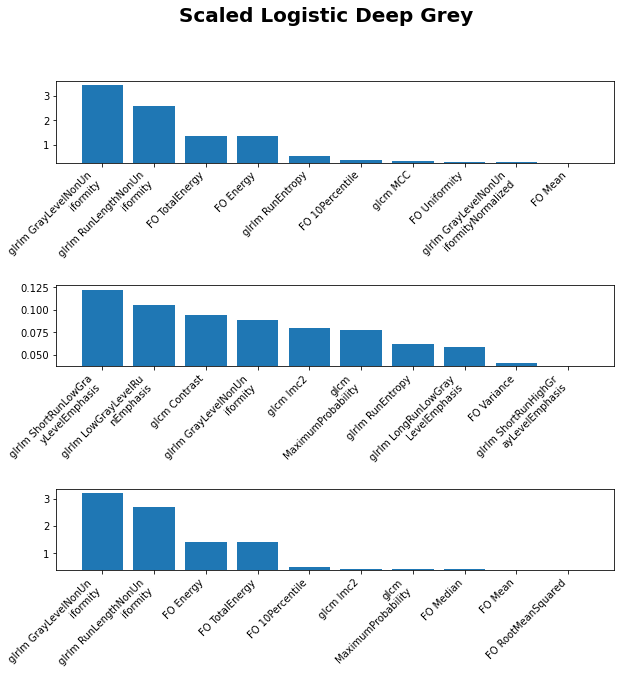

	Model Place: 2
  1: glrlm GrayLevelNonUniformity             2.357
  2: glrlm RunLengthNonUniformity             1.843
  3: FO TotalEnergy                           1.019
  4: FO Energy                                1.019
  5: glcm MCC                                 0.317
  6: glrlm RunEntropy                         0.280
  7: glcm Correlation                         0.279
  8: glcm Imc2                                0.242
  9: FO 10Percentile                          0.230
 10: FO Uniformity                            0.179

  1: glcmMaximumProbability                   0.109
  2: FOInterquartileRange                     0.092
  3: glrlm ShortRunLowGrayLevelEmphasis       0.059
  4: glcm InverseVariance                     0.043
  5: glcmDifferenceAverage                    0.041
  6: FO Skewness                              0.040
  7: glrlmGrayLevelVariance                   0.038
  8: FO Variance                              0.037
  9: glrlm LowGrayLevelRunEmphasis            0

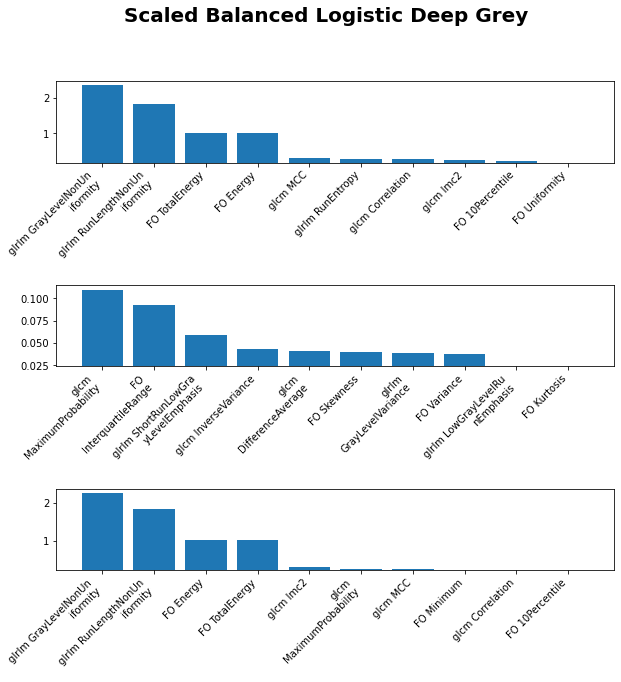

	Model Place: 3
  1: glrlm RunLengthNonUniformity             0.031
  2: glrlm GrayLevelNonUniformity             0.010
  3: FO Energy                                0.004
  4: glcm Correlation                         0.003
  5: glrlmLongRunEmphasis                     0.003
  6: FO Kurtosis                              0.001
  7: glcmDifferenceAverage                    0.001
  8: glrlm RunPercentage                      0.001
  9: glrlm RunEntropy                         0.001
 10: FO Minimum                               0.001

  1: glrlm RunLengthNonUniformity             0.038
  2: glrlm GrayLevelNonUniformity             0.019
  3: glrlmLongRunEmphasis                     0.006
  4: glrlm RunVariance                        0.005
  5: glcm Imc1                                0.004
  6: FO Kurtosis                              0.003
  7: glcm Correlation                         0.002
  8: glcmMaximumProbability                   0.002
  9: glcm MCC                                 0

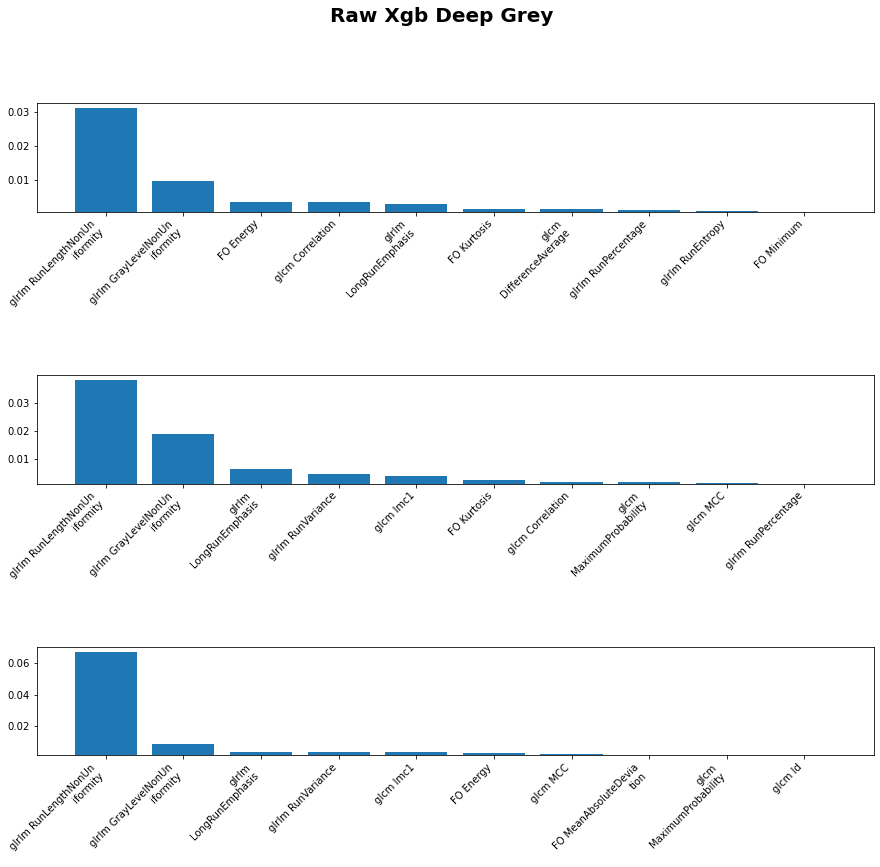

Best Model for Brain_stem:
	Model Place: 1
  1: glrlm GrayLevelNonUniformity             2.817
  2: glrlm RunLengthNonUniformity             2.579
  3: FO Energy                                1.295
  4: FO TotalEnergy                           1.295
  5: glrlm RunEntropy                         0.320
  6: glcm Imc1                                0.319
  7: FO Minimum                               0.294
  8: FO Median                                0.276
  9: glcm Correlation                         0.258
 10: FO Kurtosis                              0.236

  1: glrlm GrayLevelNonUniformity             0.150
  2: glcm Correlation                         0.101
  3: glcm Contrast                            0.057
  4: glcmClusterProminence                    0.048
  5: FO Maximum                               0.043
  6: FO Range                                 0.038
  7: FO Kurtosis                              0.030
  8: glcm Imc2                                0.027
  9: glcmDifferenceA

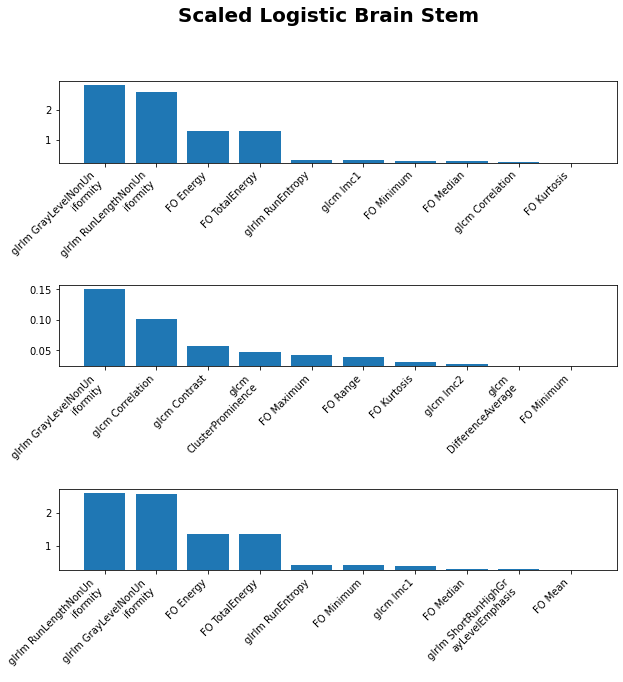

	Model Place: 2
  1: glrlm GrayLevelNonUniformity             2.346
  2: glrlm RunLengthNonUniformity             2.171
  3: FO TotalEnergy                           1.042
  4: FO Energy                                1.042
  5: glrlm RunEntropy                         0.359
  6: glcm Imc1                                0.310
  7: glcm Imc2                                0.260
  8: glcm Correlation                         0.224
  9: FO Median                                0.221
 10: FO Kurtosis                              0.193

  1: glcm Idmn                                0.163
  2: glcmClusterProminence                    0.113
  3: glrlm RunEntropy                         0.077
  4: glrlm GrayLevelNonUniformity             0.054
  5: glcm ClusterShade                        0.040
  6: glcm Idn                                 0.040
  7: glcm MCC                                 0.013
  8: glcm SumEntropy                          0.001
  9: glcm Correlation                         0

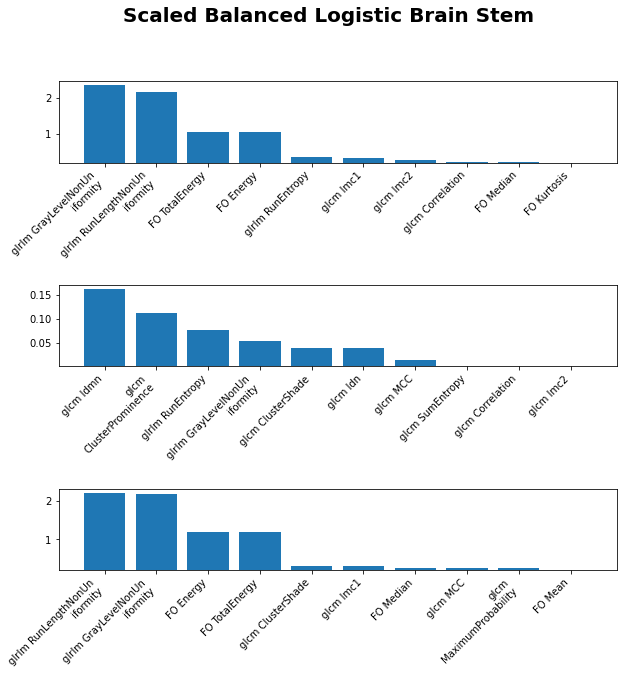

	Model Place: 3
  1: glrlm RunLengthNonUniformity             0.010
  2: glrlm RunLengthNonUniformityNormalized   0.005
  3: FO Energy                                0.005
  4: glcm Imc2                                0.004
  5: glrlm RunEntropy                         0.003
  6: glcm InverseVariance                     0.002
  7: glcm MCC                                 0.002
  8: glrlm GrayLevelNonUniformity             0.001
  9: glcm Correlation                         0.001
 10: FO Skewness                              0.001

  1: glrlm GrayLevelNonUniformity             0.045
  2: glrlm RunLengthNonUniformity             0.007
  3: glrlm RunLengthNonUniformityNormalized   0.006
  4: glcm Imc2                                0.006
  5: FO Energy                                0.005
  6: glrlm RunEntropy                         0.004
  7: glcm Imc1                                0.003
  8: glcm Correlation                         0.002
  9: glcm MCC                                 0

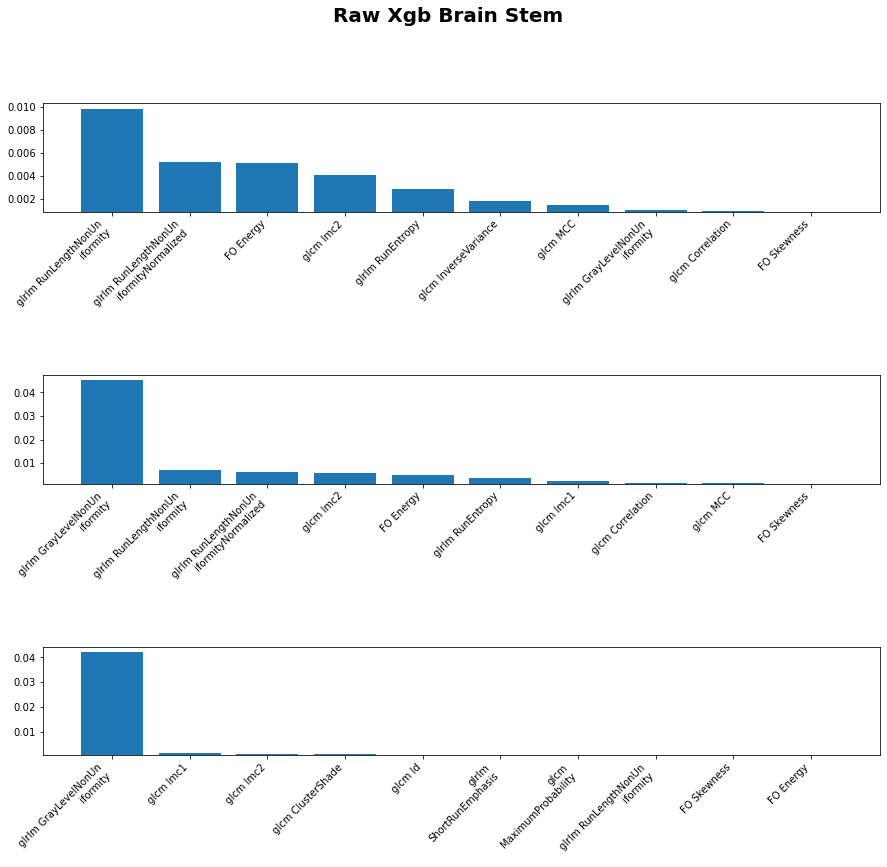

Best Model for Left_wm:
	Model Place: 1
  1: glrlm GrayLevelNonUniformity             2.841
  2: glrlm RunLengthNonUniformity             2.232
  3: FO TotalEnergy                           1.321
  4: FO Energy                                1.321
  5: glrlm RunEntropy                         0.429
  6: glcm InverseVariance                     0.293
  7: glcm Imc1                                0.225
  8: FO 10Percentile                          0.220
  9: FO Minimum                               0.213
 10: FO Maximum                               0.193

  1: glrlm GrayLevelNonUniformity             0.213
  2: glcm InverseVariance                     0.139
  3: FO TotalEnergy                           0.109
  4: FO Energy                                0.109
  5: glrlm LongRunHighGrayLevelEmphasis       0.089
  6: glcmDifferenceVariance                   0.086
  7: glrlm RunVariance                        0.083
  8: glcmClusterProminence                    0.067
  9: glcm MCC          

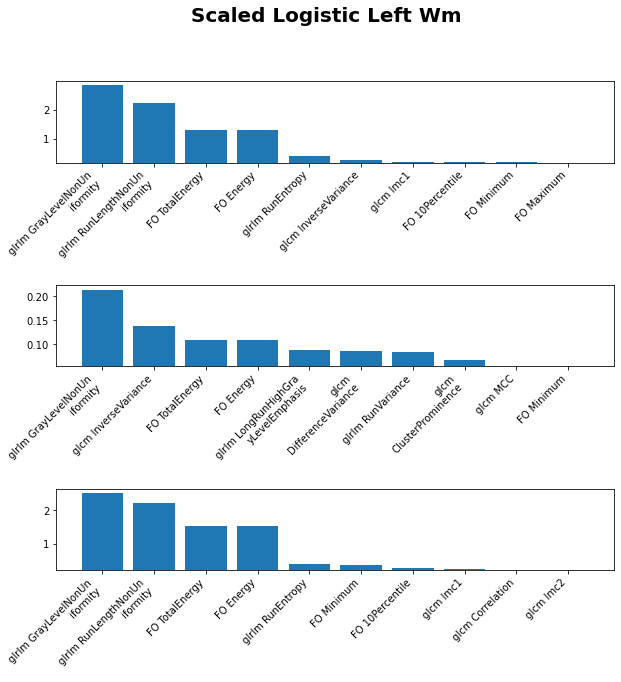

	Model Place: 2
  1: glrlm RunLengthNonUniformity             0.037
  2: FO Energy                                0.014
  3: glrlm RunEntropy                         0.006
  4: glrlm GrayLevelNonUniformity             0.005
  5: glcm Correlation                         0.004
  6: glcmDifferenceAverage                    0.002
  7: glcm ClusterShade                        0.001
  8: glrlm RunLengthNonUniformityNormalized   0.001
  9: glcm Id                                  0.001
 10: glcm Imc1                                0.001

  1: glrlm RunLengthNonUniformity             0.101
  2: FO Energy                                0.024
  3: glrlm GrayLevelNonUniformity             0.012
  4: glcm Imc1                                0.003
  5: glcm Correlation                         0.002
  6: glrlm RunEntropy                         0.002
  7: glcm ClusterShade                        0.001
  8: FO Kurtosis                              0.001
  9: FO RootMeanSquared                       0

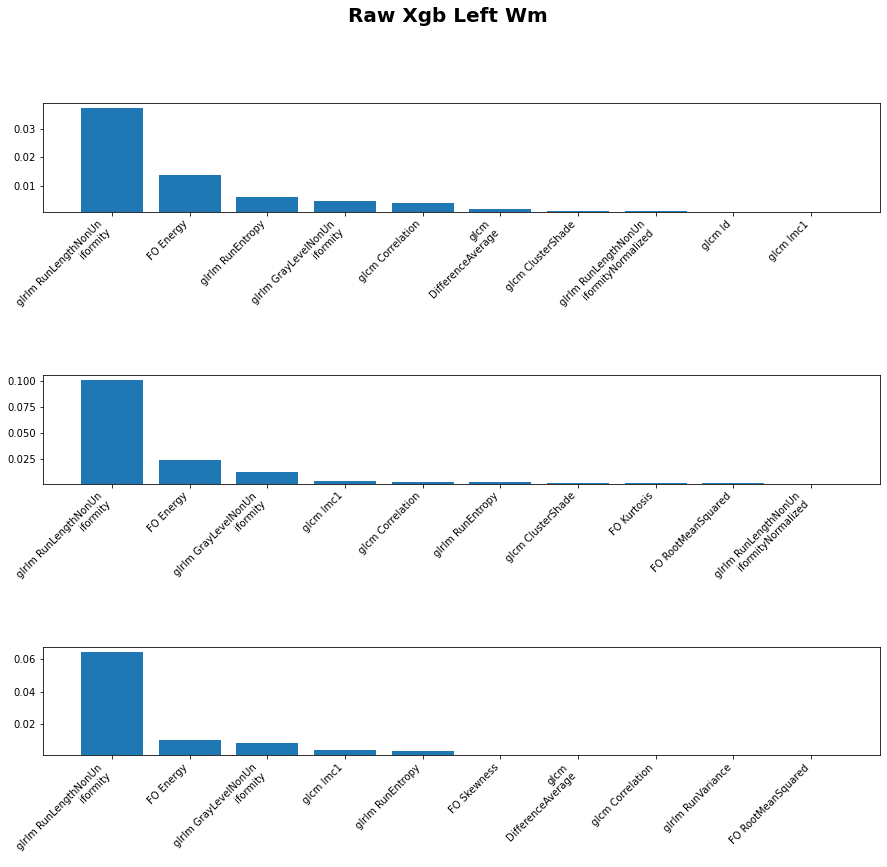

	Model Place: 3
  1: glrlm RunLengthNonUniformity             0.054
  2: glrlm GrayLevelNonUniformity             0.012
  3: FO Energy                                0.005
  4: glrlm RunLengthNonUniformityNormalized   0.003
  5: glcm Id                                  0.003
  6: glcm Idn                                 0.002
  7: glcm Correlation                         0.002
  8: glrlmLongRunEmphasis                     0.002
  9: glcm MCC                                 0.002
 10: glcm Idmn                                0.001

  1: glrlm RunLengthNonUniformity             0.072
  2: FO Energy                                0.017
  3: glcm Imc1                                0.015
  4: glrlm RunLengthNonUniformityNormalized   0.008
  5: glrlm GrayLevelNonUniformity             0.008
  6: glrlm RunEntropy                         0.005
  7: glcm Imc2                                0.004
  8: glcm Correlation                         0.003
  9: glcm Id                                  0

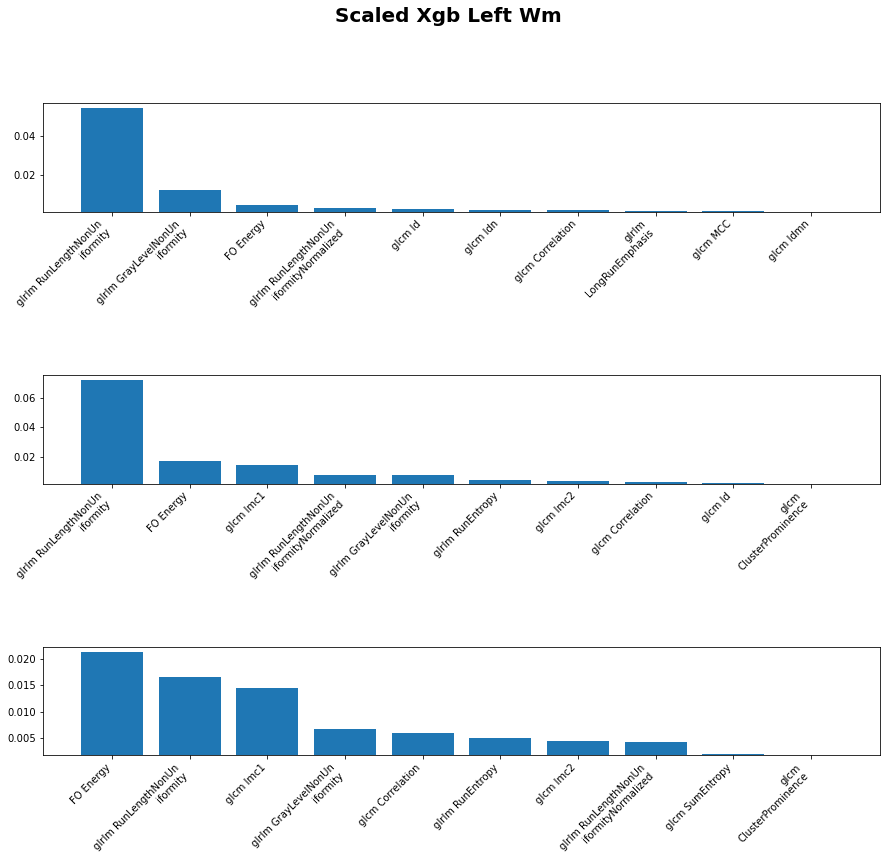

Best Model for Left_gm:
	Model Place: 1
  1: glrlm GrayLevelNonUniformity             2.852
  2: glrlm RunLengthNonUniformity             2.439
  3: FO Energy                                1.097
  4: FO TotalEnergy                           1.097
  5: glrlm RunEntropy                         0.557
  6: glrlm GrayLevelNonUniformityNormalized   0.203
  7: FO Entropy                               0.197
  8: glcm SumEntropy                          0.187
  9: glcm Autocorrelation                     0.171
 10: glrlm ShortRunHighGrayLevelEmphasis      0.163

  1: FO Skewness                              0.175
  2: glrlm GrayLevelNonUniformity             0.125
  3: FOInterquartileRange                     0.124
  4: glcm ClusterShade                        0.097
  5: FO RobustMeanAbsoluteDeviation           0.096
  6: glcm Correlation                         0.081
  7: FO 10Percentile                          0.066
  8: FO Maximum                               0.062
  9: glcm MCC          

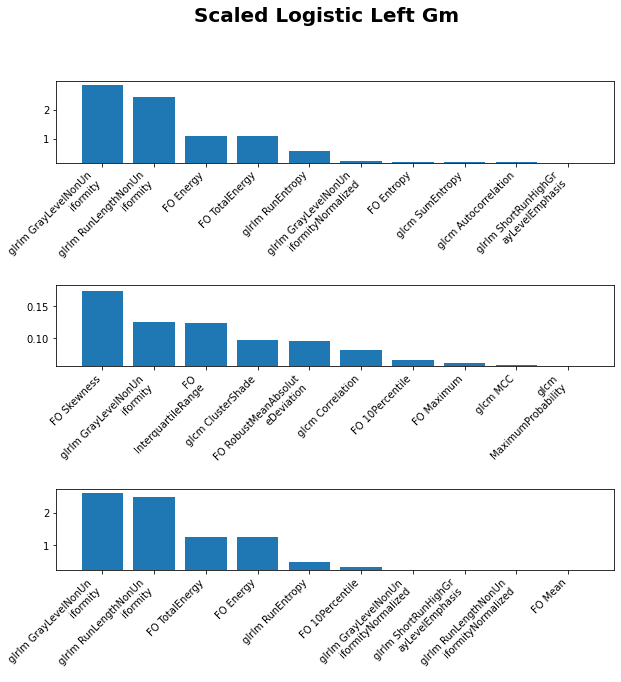

	Model Place: 2
  1: glrlm RunLengthNonUniformity             0.023
  2: glcm Imc2                                0.011
  3: FO Energy                                0.008
  4: glrlm GrayLevelNonUniformity             0.006
  5: glcm Idmn                                0.005
  6: glrlm RunEntropy                         0.003
  7: glrlm LongRunLowGrayLevelEmphasis        0.002
  8: glcm MCC                                 0.001
  9: glcm Id                                  0.001
 10: FO 10Percentile                          0.001

  1: glrlm GrayLevelNonUniformity             0.046
  2: glrlm RunLengthNonUniformity             0.020
  3: glcm Imc2                                0.008
  4: glcm Idmn                                0.006
  5: FO Energy                                0.005
  6: glrlm RunVariance                        0.002
  7: glcm SumSquares                          0.002
  8: glrlmLongRunEmphasis                     0.002
  9: glrlm LongRunLowGrayLevelEmphasis        0

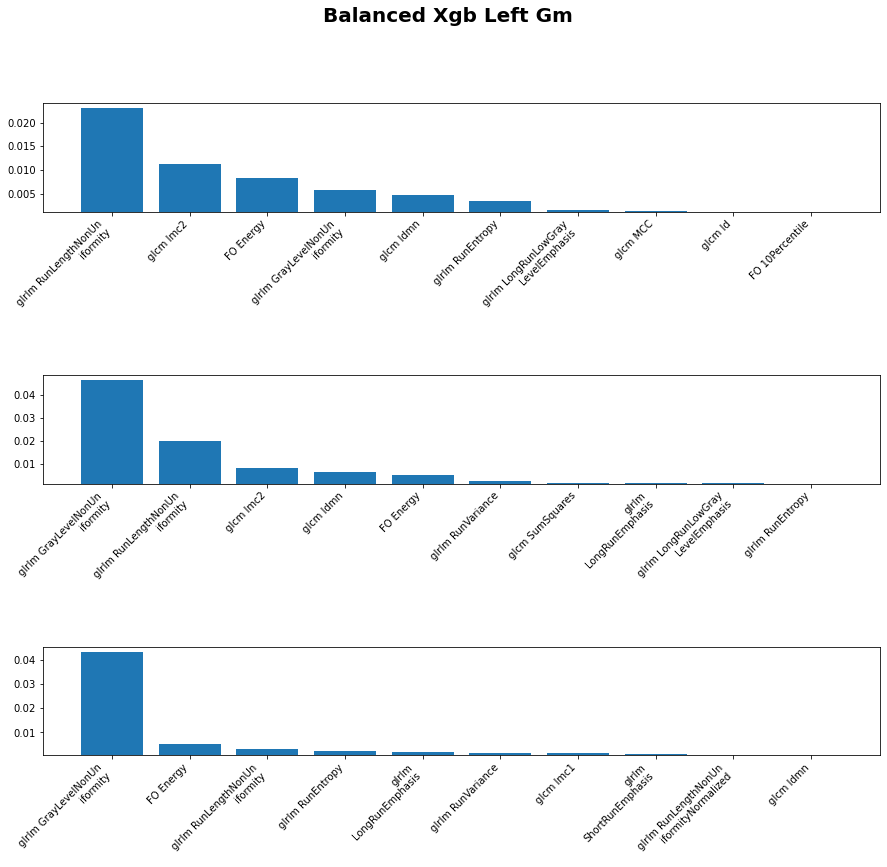

	Model Place: 3
  1: glrlm RunLengthNonUniformity             0.036
  2: glrlm GrayLevelNonUniformity             0.009
  3: glrlmLongRunEmphasis                     0.002
  4: glrlm RunPercentage                      0.001
  5: glcmClusterProminence                    0.001
  6: glrlm RunVariance                        0.001
  7: glrlm RunEntropy                         0.001
  8: glrlmShortRunEmphasis                    0.001
  9: glcm Imc1                                0.001
 10: glrlm RunLengthNonUniformityNormalized   0.001

  1: glrlm RunLengthNonUniformity             0.015
  2: glrlm GrayLevelNonUniformity             0.005
  3: glcm Imc1                                0.003
  4: FO Energy                                0.001
  5: glrlm RunPercentage                      0.001
  6: glrlm RunVariance                        0.001
  7: glcm Id                                  0.001
  8: glrlm RunEntropy                         0.001
  9: glcmMaximumProbability                   0

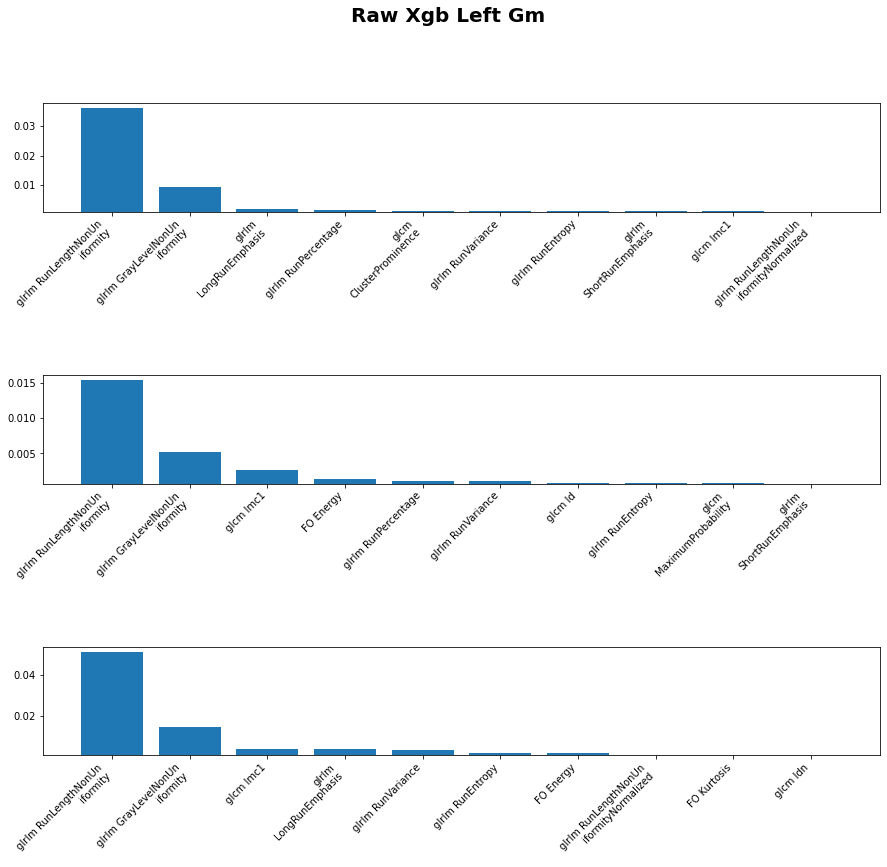

Best Model for Right_wm:
	Model Place: 1
  1: glrlm GrayLevelNonUniformity             3.193
  2: glrlm RunLengthNonUniformity             2.536
  3: FO Energy                                1.479
  4: FO TotalEnergy                           1.479
  5: glrlm RunEntropy                         0.389
  6: glcm Imc2                                0.290
  7: FO Minimum                               0.290
  8: FO 10Percentile                          0.248
  9: glrlm LongRunLowGrayLevelEmphasis        0.216
 10: glcm Imc1                                0.208

  1: glcm Idmn                                0.163
  2: glcmClusterProminence                    0.137
  3: glrlm GrayLevelNonUniformity             0.128
  4: glcm Idn                                 0.106
  5: FO Kurtosis                              0.099
  6: glcm ClusterShade                        0.091
  7: glcmDifferenceVariance                   0.077
  8: FO Minimum                               0.076
  9: FO Energy        

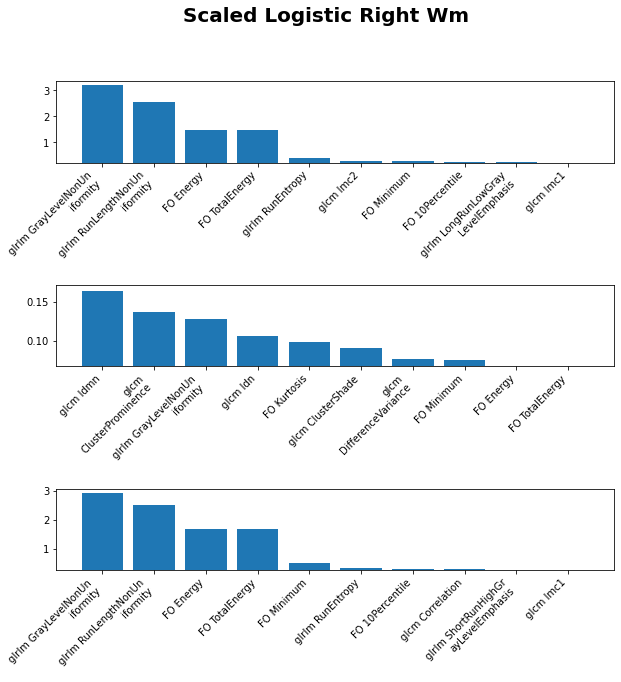

	Model Place: 2
  1: glrlm GrayLevelNonUniformity             2.208
  2: glrlm RunLengthNonUniformity             1.732
  3: FO Energy                                1.094
  4: FO TotalEnergy                           1.094
  5: glcm InverseVariance                     0.347
  6: FO Kurtosis                              0.293
  7: FO Minimum                               0.289
  8: FO Skewness                              0.223
  9: glcm Idmn                                0.132
 10: glcm Imc2                                0.119

  1: glcm InverseVariance                     0.228
  2: glcm MCC                                 0.196
  3: glcm Idmn                                0.124
  4: glcm ClusterShade                        0.119
  5: FO Kurtosis                              0.107
  6: glcmDifferenceVariance                   0.100
  7: glcm Correlation                         0.094
  8: glrlm RunVariance                        0.087
  9: glcmMaximumProbability                   0

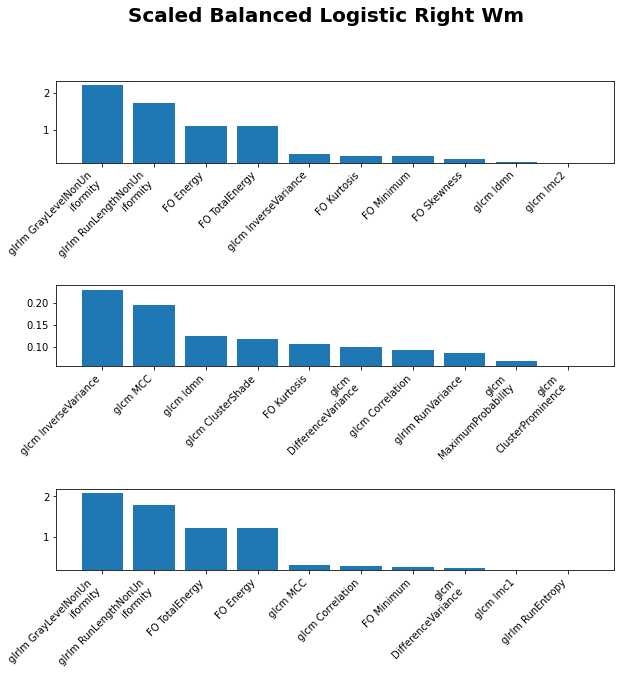

	Model Place: 3
  1: glrlm RunLengthNonUniformity             0.055
  2: FO Energy                                0.011
  3: glrlm GrayLevelNonUniformity             0.005
  4: glrlmLongRunEmphasis                     0.002
  5: glcm Idmn                                0.001
  6: glcm MCC                                 0.001
  7: glrlm LowGrayLevelRunEmphasis            0.001
  8: FO Range                                 0.001
  9: glrlm RunLengthNonUniformityNormalized   0.001
 10: glcm Imc1                                0.001

  1: glrlm GrayLevelNonUniformity             0.028
  2: FO Energy                                0.004
  3: glrlm RunLengthNonUniformity             0.003
  4: glrlm LowGrayLevelRunEmphasis            0.002
  5: glcm Imc2                                0.002
  6: glrlm RunEntropy                         0.001
  7: glcm MCC                                 0.001
  8: glcm SumEntropy                          0.001
  9: glcm Contrast                            0

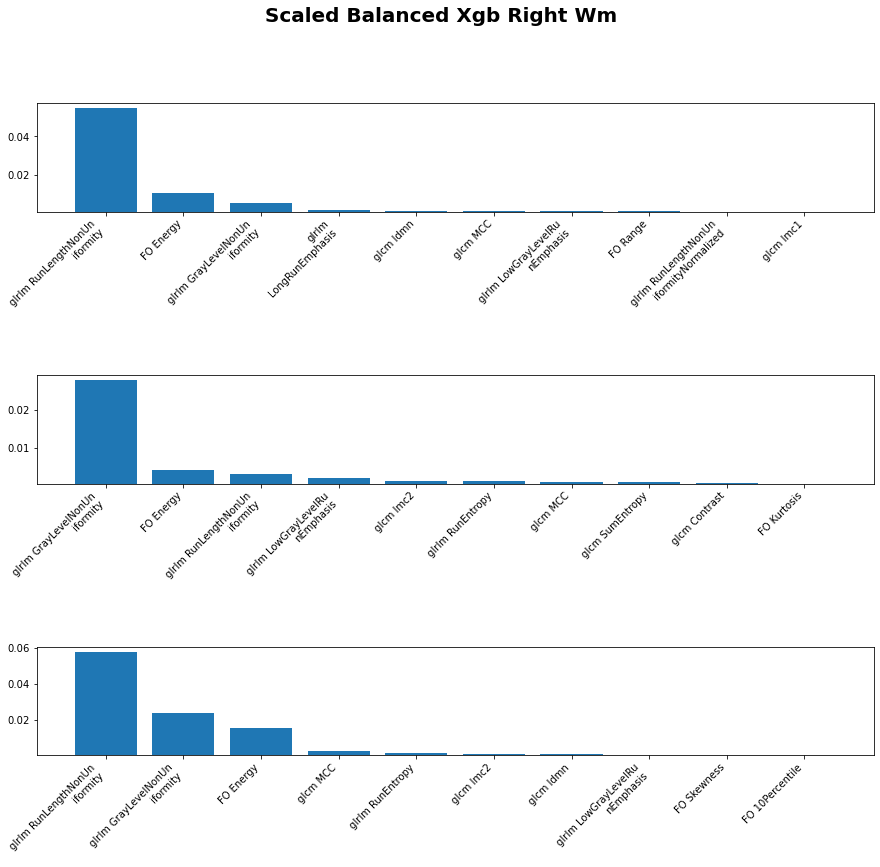

Best Model for Right_gm:
	Model Place: 1
  1: glrlm GrayLevelNonUniformity             2.881
  2: glrlm RunLengthNonUniformity             2.478
  3: FO TotalEnergy                           1.134
  4: FO Energy                                1.134
  5: glrlm RunEntropy                         0.480
  6: FO 10Percentile                          0.248
  7: glcm Correlation                         0.224
  8: FO Median                                0.217
  9: glrlm RunLengthNonUniformityNormalized   0.212
 10: glrlm GrayLevelNonUniformityNormalized   0.208

  1: glrlm GrayLevelNonUniformity             0.185
  2: FO TotalEnergy                           0.096
  3: FO Energy                                0.096
  4: glcmClusterProminence                    0.091
  5: FO Minimum                               0.049
  6: glcm Correlation                         0.039
  7: FO Maximum                               0.038
  8: FO Variance                              0.035
  9: FO Kurtosis      

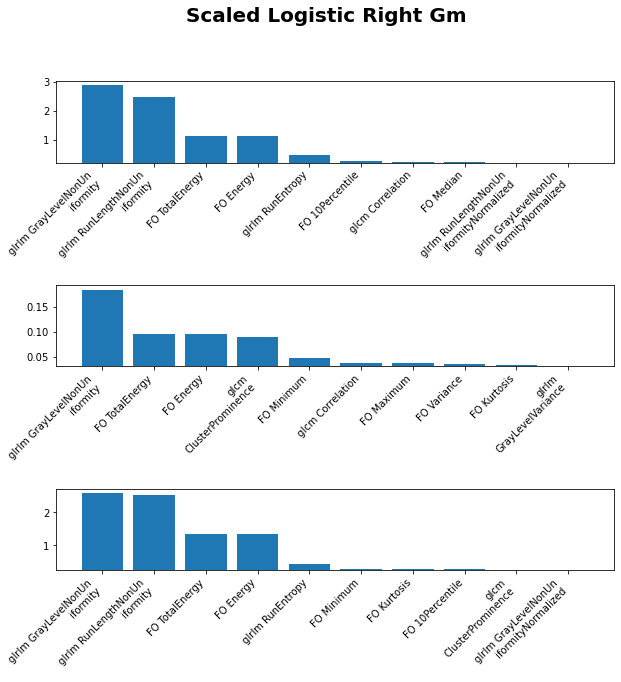

	Model Place: 2
  1: glrlm RunLengthNonUniformity             0.014
  2: glrlm GrayLevelNonUniformity             0.004
  3: glcm Imc2                                0.001
  4: glrlm RunEntropy                         0.001
  5: FO Minimum                               0.001
  6: glrlm GrayLevelNonUniformityNormalized   0.001
  7: glrlm RunLengthNonUniformityNormalized   0.001
  8: glcmMaximumProbability                   0.000
  9: glrlmLongRunEmphasis                     0.000
 10: FO Energy                                0.000

  1: glrlm GrayLevelNonUniformity             0.026
  2: glcm Imc2                                0.002
  3: FO Energy                                0.002
  4: glcm Correlation                         0.002
  5: glrlm RunLengthNonUniformity             0.001
  6: FO Minimum                               0.001
  7: glcm Id                                  0.001
  8: glrlm RunVariance                        0.001
  9: FO Skewness                              0

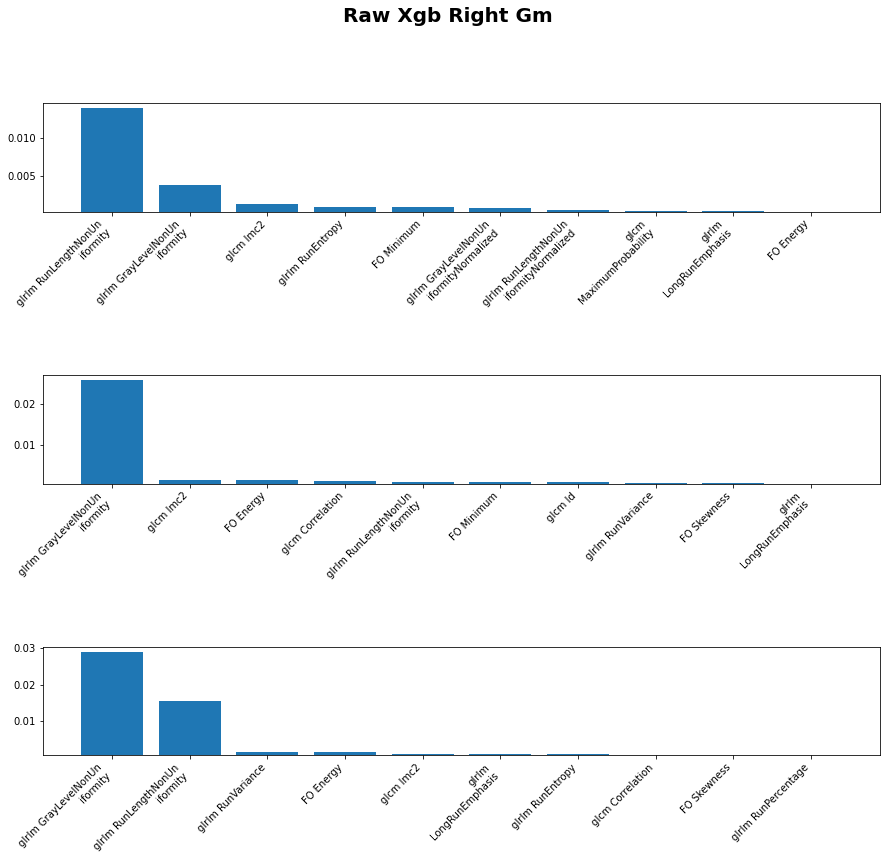

	Model Place: 3
  1: glrlm RunLengthNonUniformity             0.019
  2: glrlm GrayLevelNonUniformity             0.018
  3: glrlm RunLengthNonUniformityNormalized   0.006
  4: glrlm RunEntropy                         0.005
  5: glrlm RunVariance                        0.001
  6: glcm Imc2                                0.001
  7: FO Energy                                0.001
  8: glcm Idmn                                0.001
  9: glcm Correlation                         0.001
 10: glcmDifferenceAverage                    0.001

  1: glrlm RunLengthNonUniformity             0.030
  2: glrlm GrayLevelNonUniformity             0.010
  3: glrlm RunLengthNonUniformityNormalized   0.005
  4: glrlm RunEntropy                         0.005
  5: FO Energy                                0.004
  6: glrlm RunPercentage                      0.004
  7: glcm Imc2                                0.002
  8: glcm Idmn                                0.001
  9: glrlmLongRunEmphasis                     0

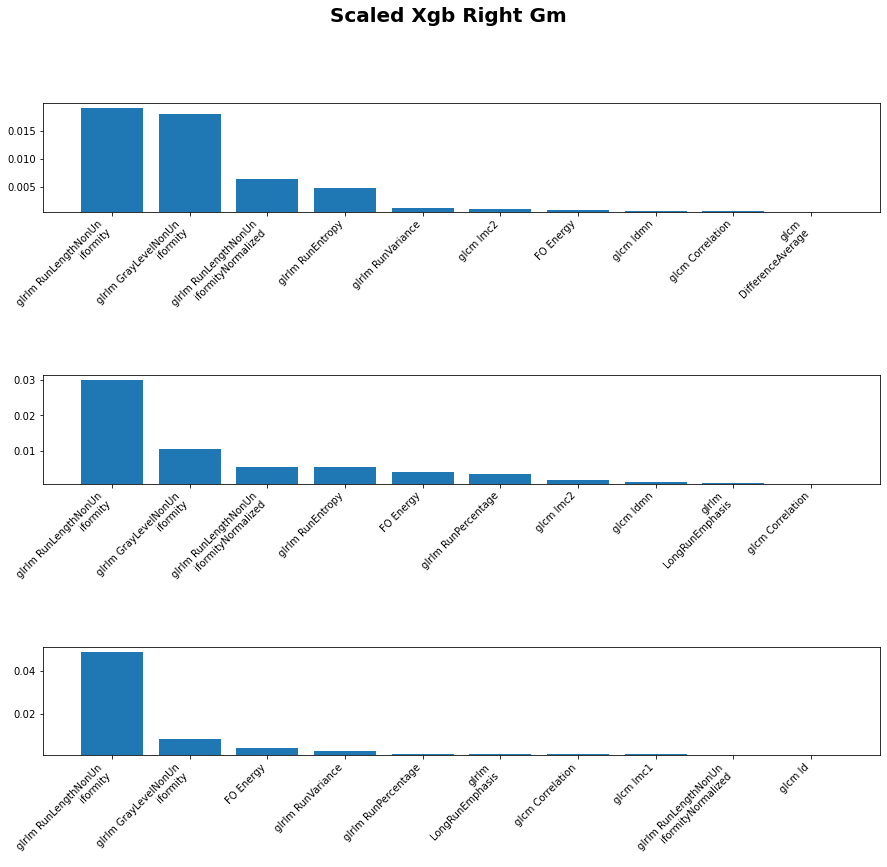

Best Model for Left_cerebellum:
	Model Place: 1
  1: glrlm GrayLevelNonUniformity             2.553
  2: glrlm RunLengthNonUniformity             2.444
  3: FO Energy                                1.214
  4: FO TotalEnergy                           1.214
  5: glcm Correlation                         0.273
  6: FO 10Percentile                          0.241
  7: FO Kurtosis                              0.235
  8: FO Minimum                               0.213
  9: glcm ClusterShade                        0.169
 10: glcm MCC                                 0.162

  1: FO Kurtosis                              0.131
  2: glrlm RunLengthNonUniformity             0.114
  3: FO 90Percentile                          0.098
  4: FO Mean                                  0.071
  5: FO 10Percentile                          0.070
  6: FO RootMeanSquared                       0.068
  7: glcm MCC                                 0.066
  8: glcm Idmn                                0.065
  9: glcmCluste

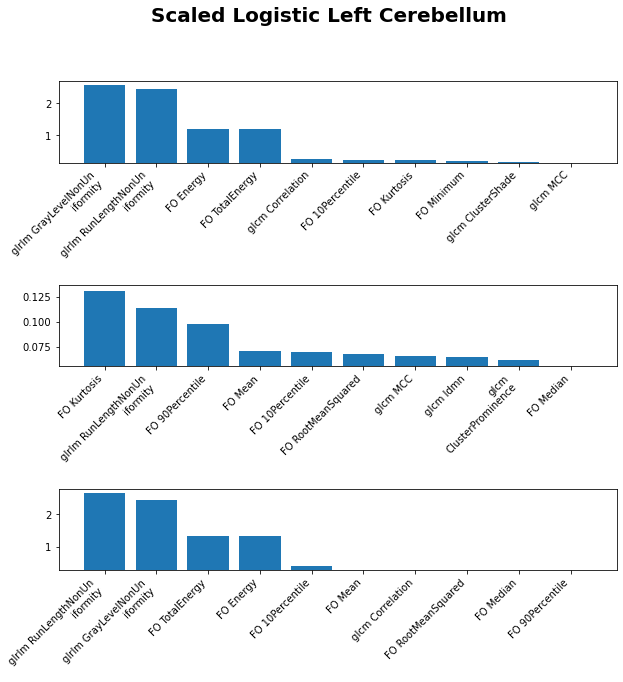

	Model Place: 2
  1: glrlm RunLengthNonUniformity             0.061
  2: glrlm GrayLevelNonUniformity             0.043
  3: glrlm RunEntropy                         0.002
  4: glcm InverseVariance                     0.001
  5: FO Energy                                0.001
  6: glcm Contrast                            0.001
  7: glrlm RunVariance                        0.001
  8: glcm Idmn                                0.001
  9: FOInterquartileRange                     0.001
 10: glcmMaximumProbability                   0.000

  1: glrlm RunLengthNonUniformity             0.087
  2: glrlm GrayLevelNonUniformity             0.061
  3: glrlm RunVariance                        0.008
  4: glcm Id                                  0.004
  5: glrlmLongRunEmphasis                     0.004
  6: glcm Correlation                         0.002
  7: glcm Idm                                 0.002
  8: glcm InverseVariance                     0.002
  9: glcmDifferenceEntropy                    0

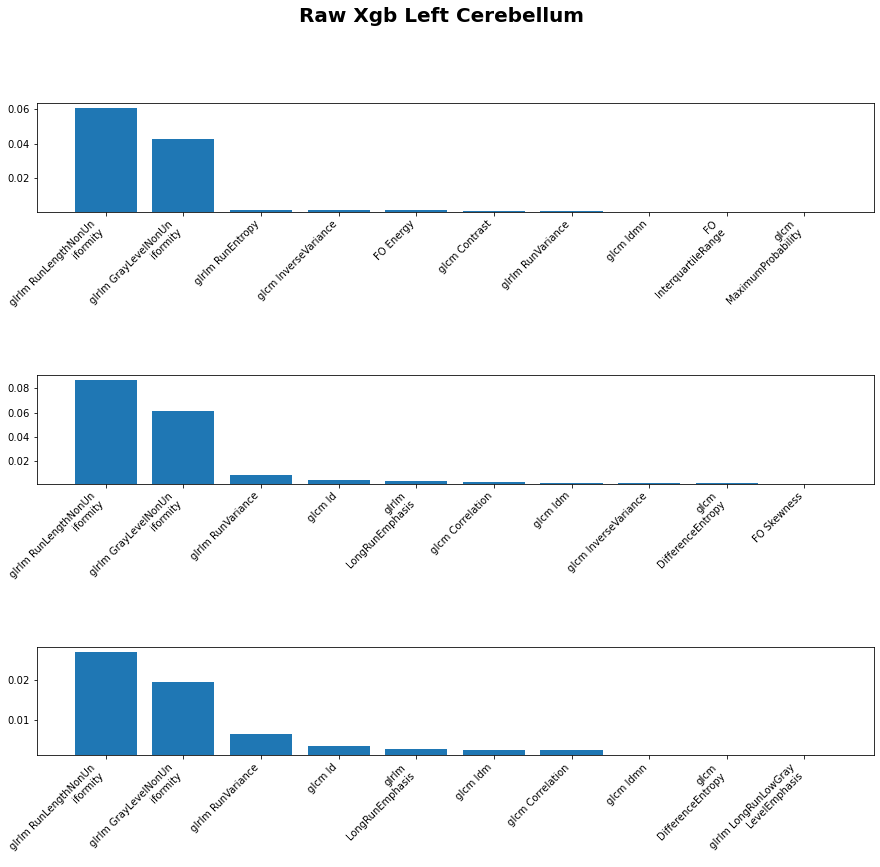

	Model Place: 3
  1: glrlm RunLengthNonUniformity             0.042
  2: glrlm GrayLevelNonUniformity             0.010
  3: glcm Imc1                                0.003
  4: glrlmLongRunEmphasis                     0.002
  5: FO Minimum                               0.002
  6: glrlm RunEntropy                         0.001
  7: FO Skewness                              0.001
  8: FO Energy                                0.001
  9: glcm Imc2                                0.001
 10: glrlm RunVariance                        0.001

  1: glrlm RunLengthNonUniformity             0.013
  2: glcm InverseVariance                     0.003
  3: glrlm RunVariance                        0.002
  4: FO Minimum                               0.002
  5: FO Skewness                              0.002
  6: glcmDifferenceAverage                    0.002
  7: FO Energy                                0.002
  8: glcm Imc1                                0.001
  9: glrlmLongRunEmphasis                     0

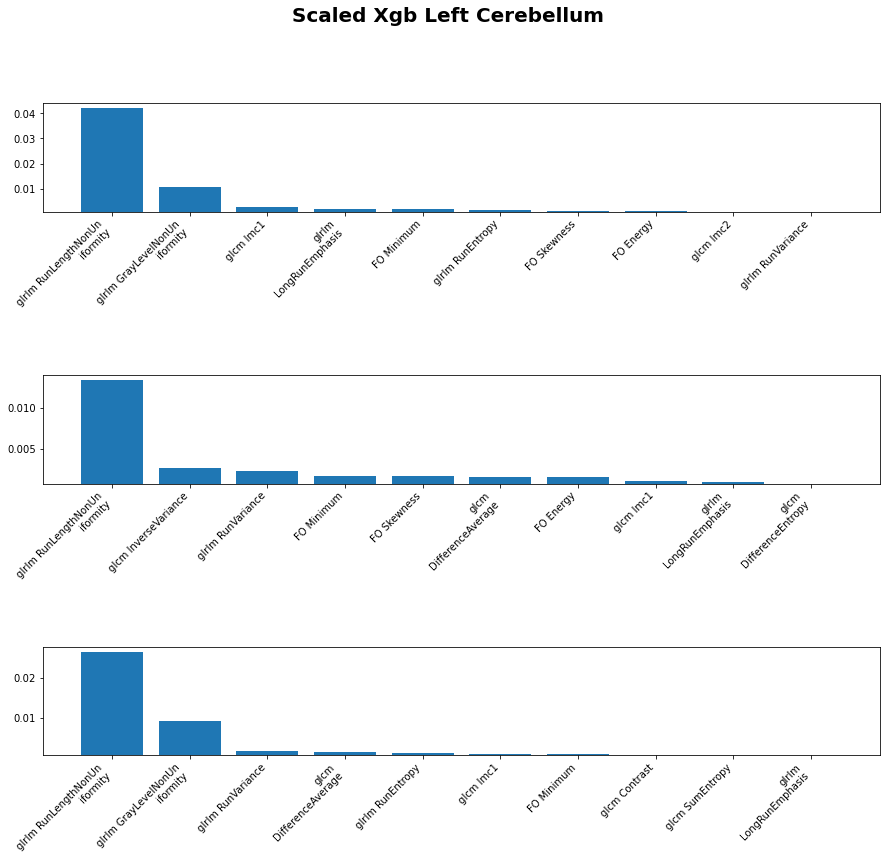

Best Model for Right_cerebellum:
	Model Place: 1
  1: glrlm GrayLevelNonUniformity             2.504
  2: glrlm RunLengthNonUniformity             2.446
  3: FO Energy                                1.154
  4: FO TotalEnergy                           1.154
  5: FO 10Percentile                          0.322
  6: glrlm RunEntropy                         0.202
  7: FO Mean                                  0.181
  8: FO Median                                0.174
  9: FO RootMeanSquared                       0.171
 10: FO Uniformity                            0.171

  1: FO Skewness                              0.152
  2: glrlm ShortRunLowGrayLevelEmphasis       0.122
  3: FO RobustMeanAbsoluteDeviation           0.116
  4: glrlm LowGrayLevelRunEmphasis            0.106
  5: FO Kurtosis                              0.104
  6: FO Minimum                               0.096
  7: FO Range                                 0.090
  8: glrlm GrayLevelNonUniformity             0.085
  9: FO Maximu

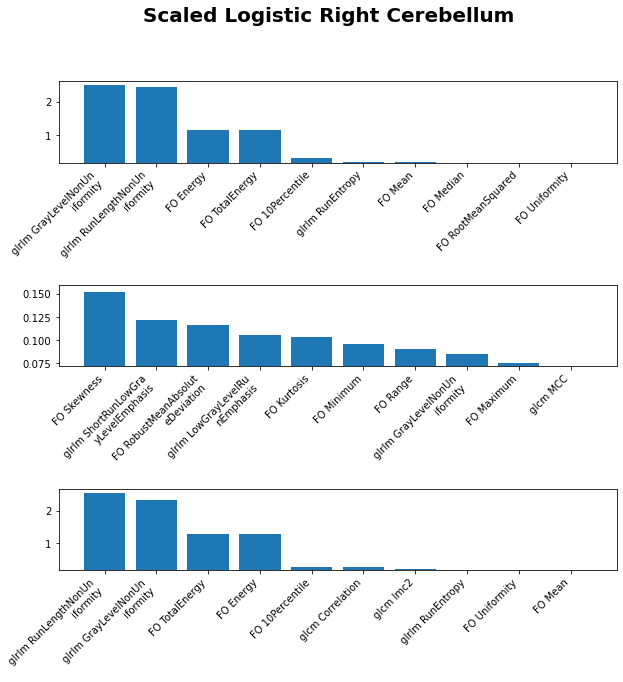

	Model Place: 2
  1: glrlm RunLengthNonUniformity             0.064
  2: glrlm GrayLevelNonUniformity             0.011
  3: glrlm RunVariance                        0.003
  4: glrlmLongRunEmphasis                     0.002
  5: glcm Correlation                         0.002
  6: FO Energy                                0.002
  7: glcm MCC                                 0.002
  8: glrlm RunEntropy                         0.001
  9: glcm Idm                                 0.001
 10: glcm Imc1                                0.001

  1: glrlm RunLengthNonUniformity             0.059
  2: glrlm GrayLevelNonUniformity             0.005
  3: glrlmLongRunEmphasis                     0.003
  4: glrlm RunVariance                        0.003
  5: glcm Imc1                                0.002
  6: glcm Correlation                         0.002
  7: glcm MCC                                 0.001
  8: glcm Imc2                                0.001
  9: glrlm RunEntropy                         0

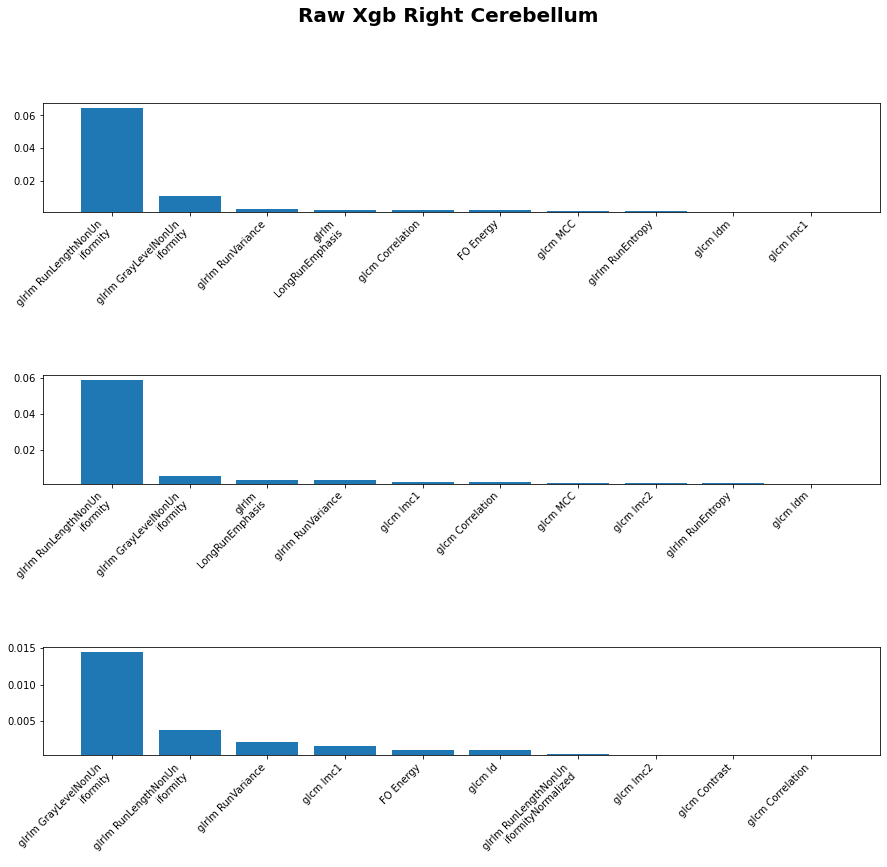

	Model Place: 3
  1: glrlm RunLengthNonUniformity             0.078
  2: glrlm GrayLevelNonUniformity             0.010
  3: FO Energy                                0.007
  4: glrlm RunPercentage                      0.001
  5: glrlm RunEntropy                         0.001
  6: glcm Imc2                                0.001
  7: glrlm RunVariance                        0.001
  8: glcm Idn                                 0.001
  9: glcm Id                                  0.001
 10: glcm Idm                                 0.001

  1: glrlm RunLengthNonUniformity             0.065
  2: FO Energy                                0.004
  3: glrlmLongRunEmphasis                     0.004
  4: glrlm RunLengthNonUniformityNormalized   0.002
  5: glcm Correlation                         0.002
  6: FO Minimum                               0.002
  7: glrlm RunVariance                        0.002
  8: glcm MCC                                 0.001
  9: glcm Id                                  0

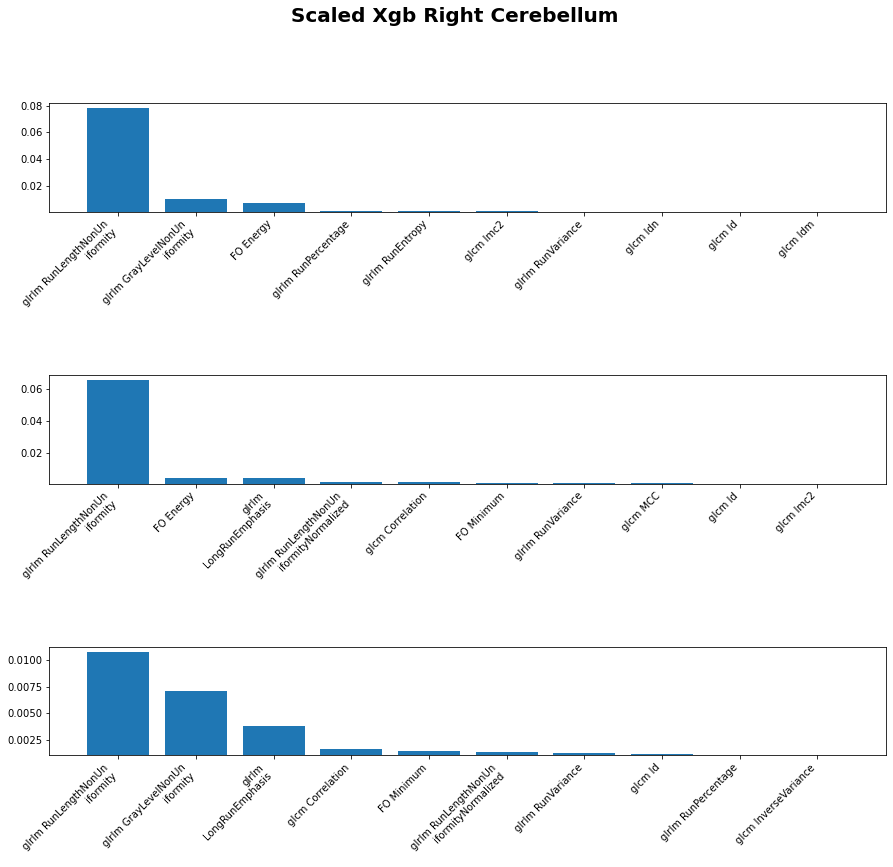

In [87]:
best_model_feature_path = os.path.join(storage_dir, 'best_model_features', 'no_shape')
os.makedirs(best_model_feature_path, exist_ok = True)

for s, phrase in zip(struc_result, phrases):
    print("Best Model for {}:".format(phrase))
    for i in range(3):
        obj = s[i]
        print("\tModel Place: {}".format(i+1))
        plot_feature_importance(obj[5], df = obj[6], number=10, title = obj[0], save_path = best_model_feature_path, disp = True)
        #print_importance(obj[5], df = obj[6], number = 10)


Best Model for Deep_grey:
	Model Name: Scaled_Logistic_Deep_grey
	Model Place: 0


X does not have valid feature names, but LogisticRegression was fitted with feature names


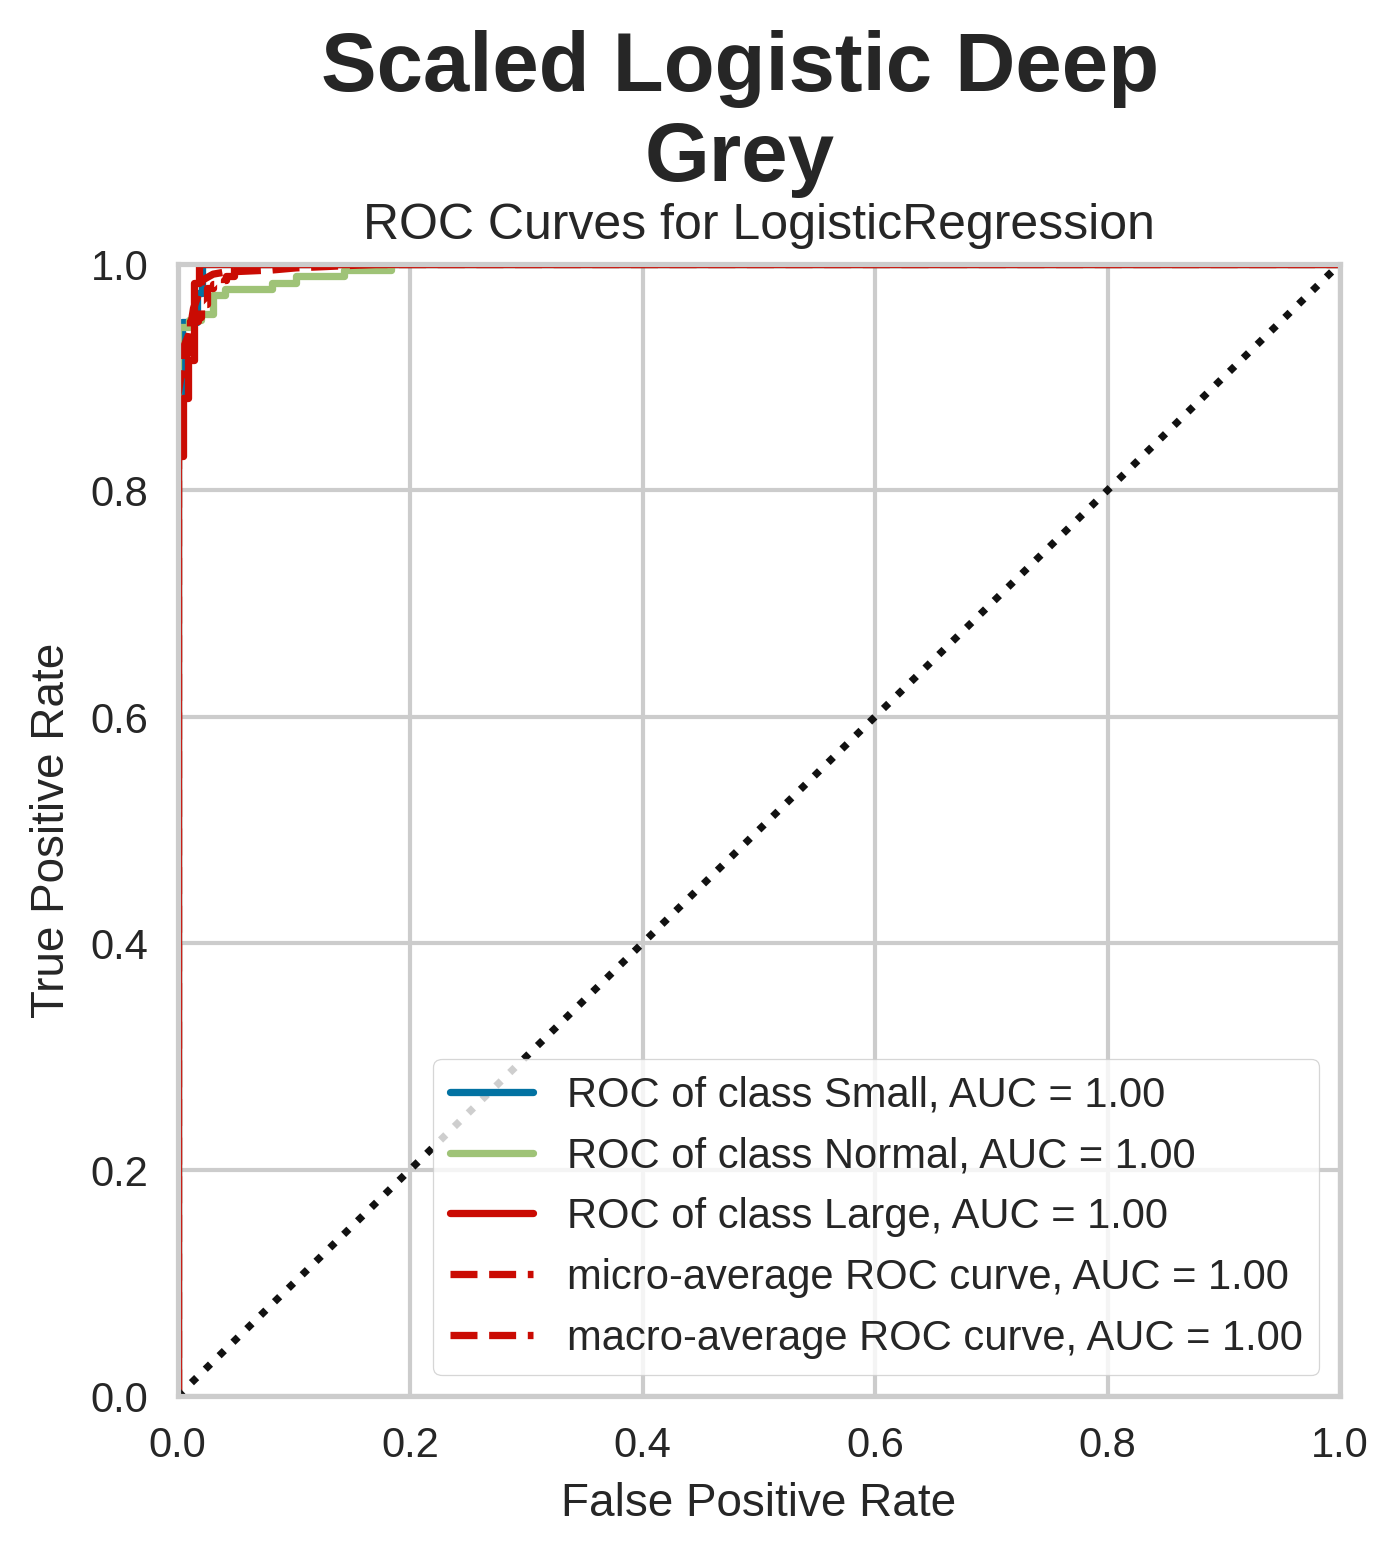

	Model Name: Scaled Balanced_Logistic_Deep_grey
	Model Place: 1


X does not have valid feature names, but LogisticRegression was fitted with feature names


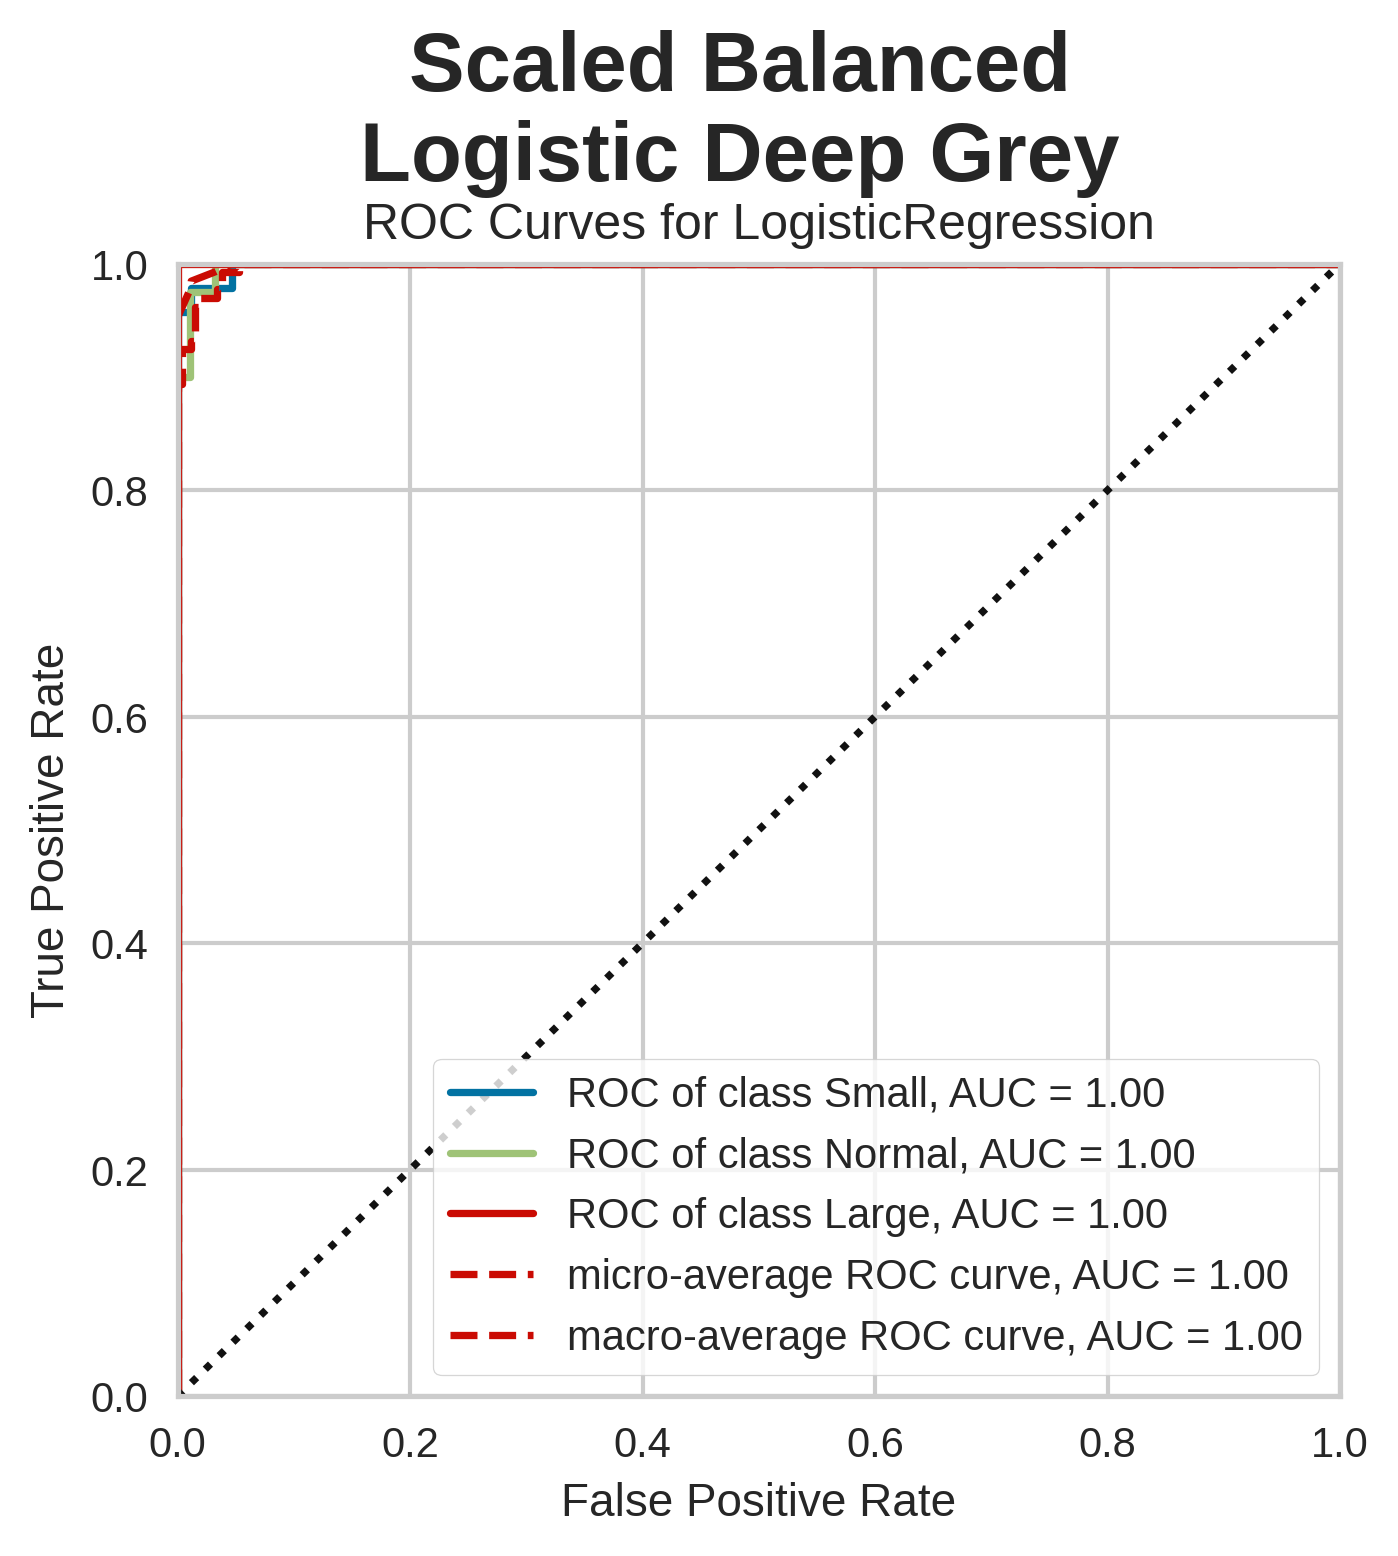

	Model Name: Raw_xGB_Deep_grey
	Model Place: 2


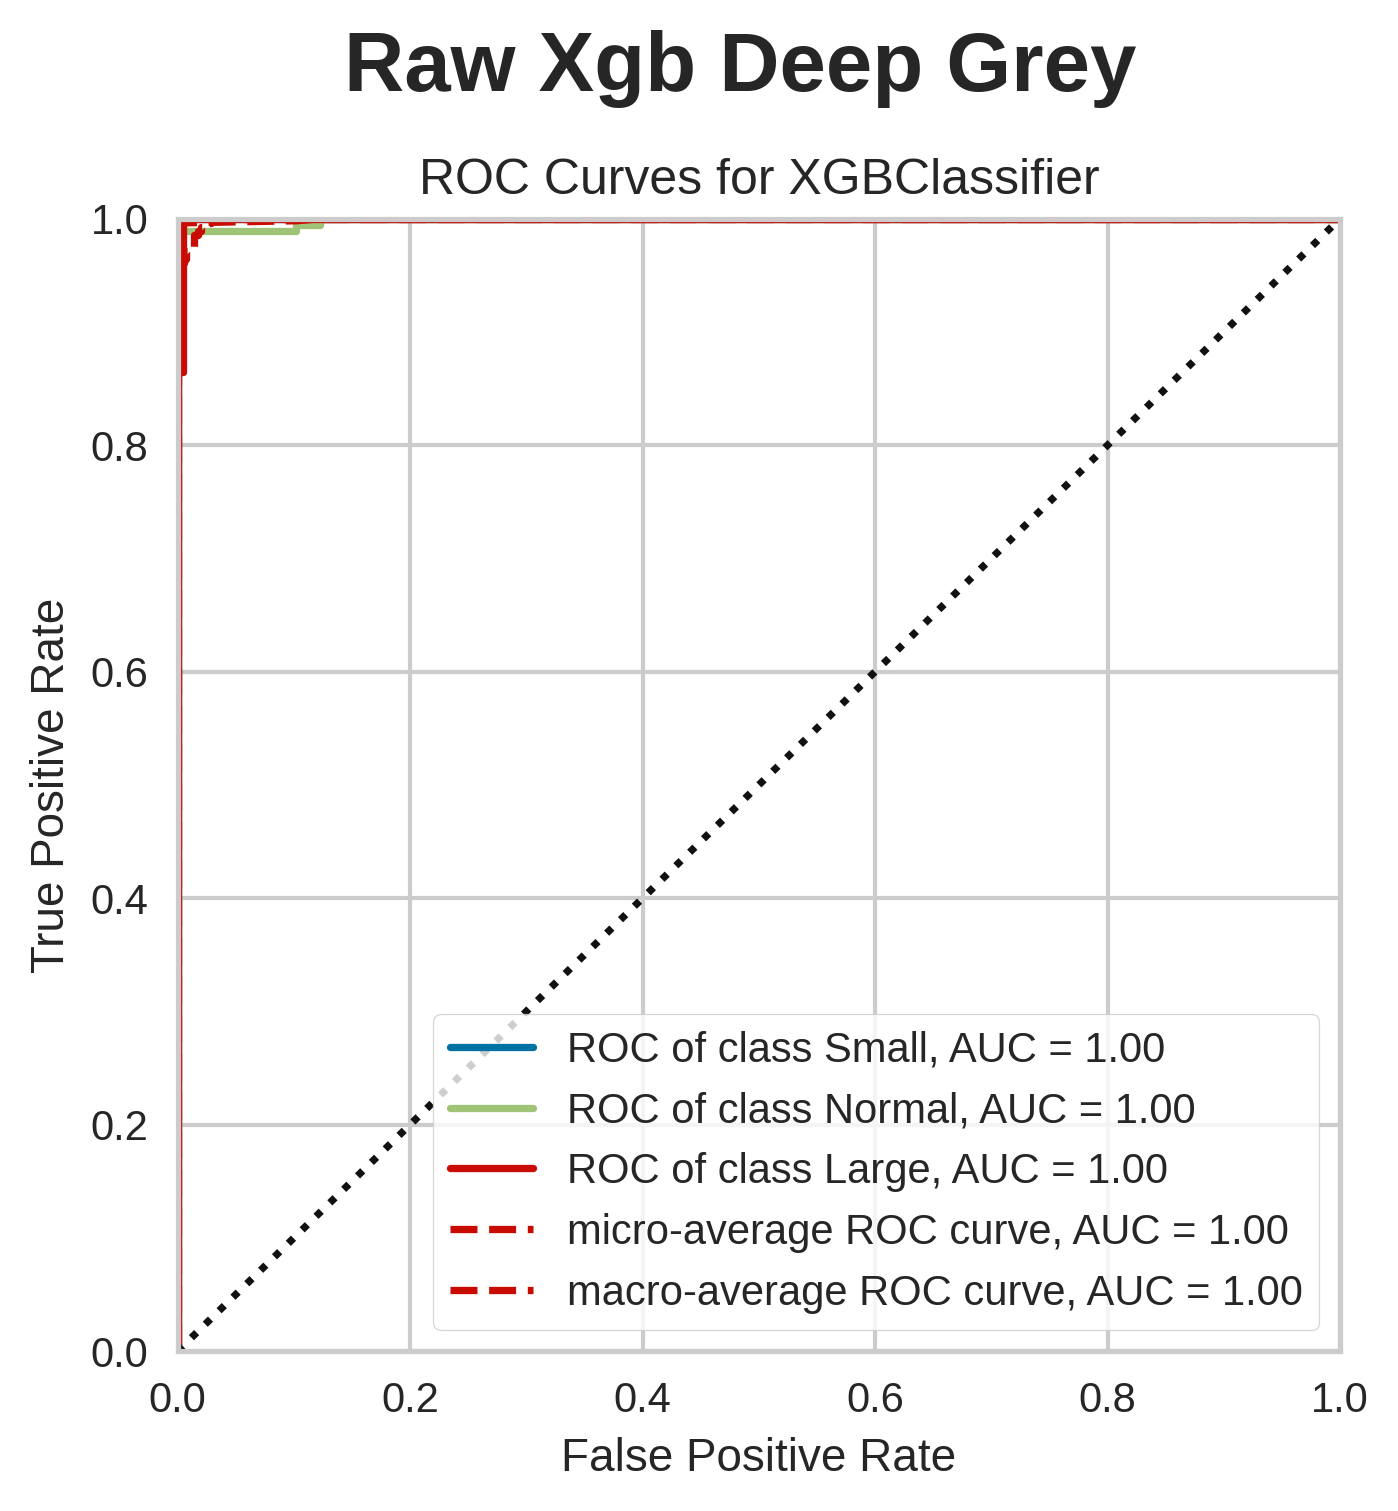

Best Model for Brain_stem:
	Model Name: Scaled_Logistic_Brain_stem
	Model Place: 0


X does not have valid feature names, but LogisticRegression was fitted with feature names


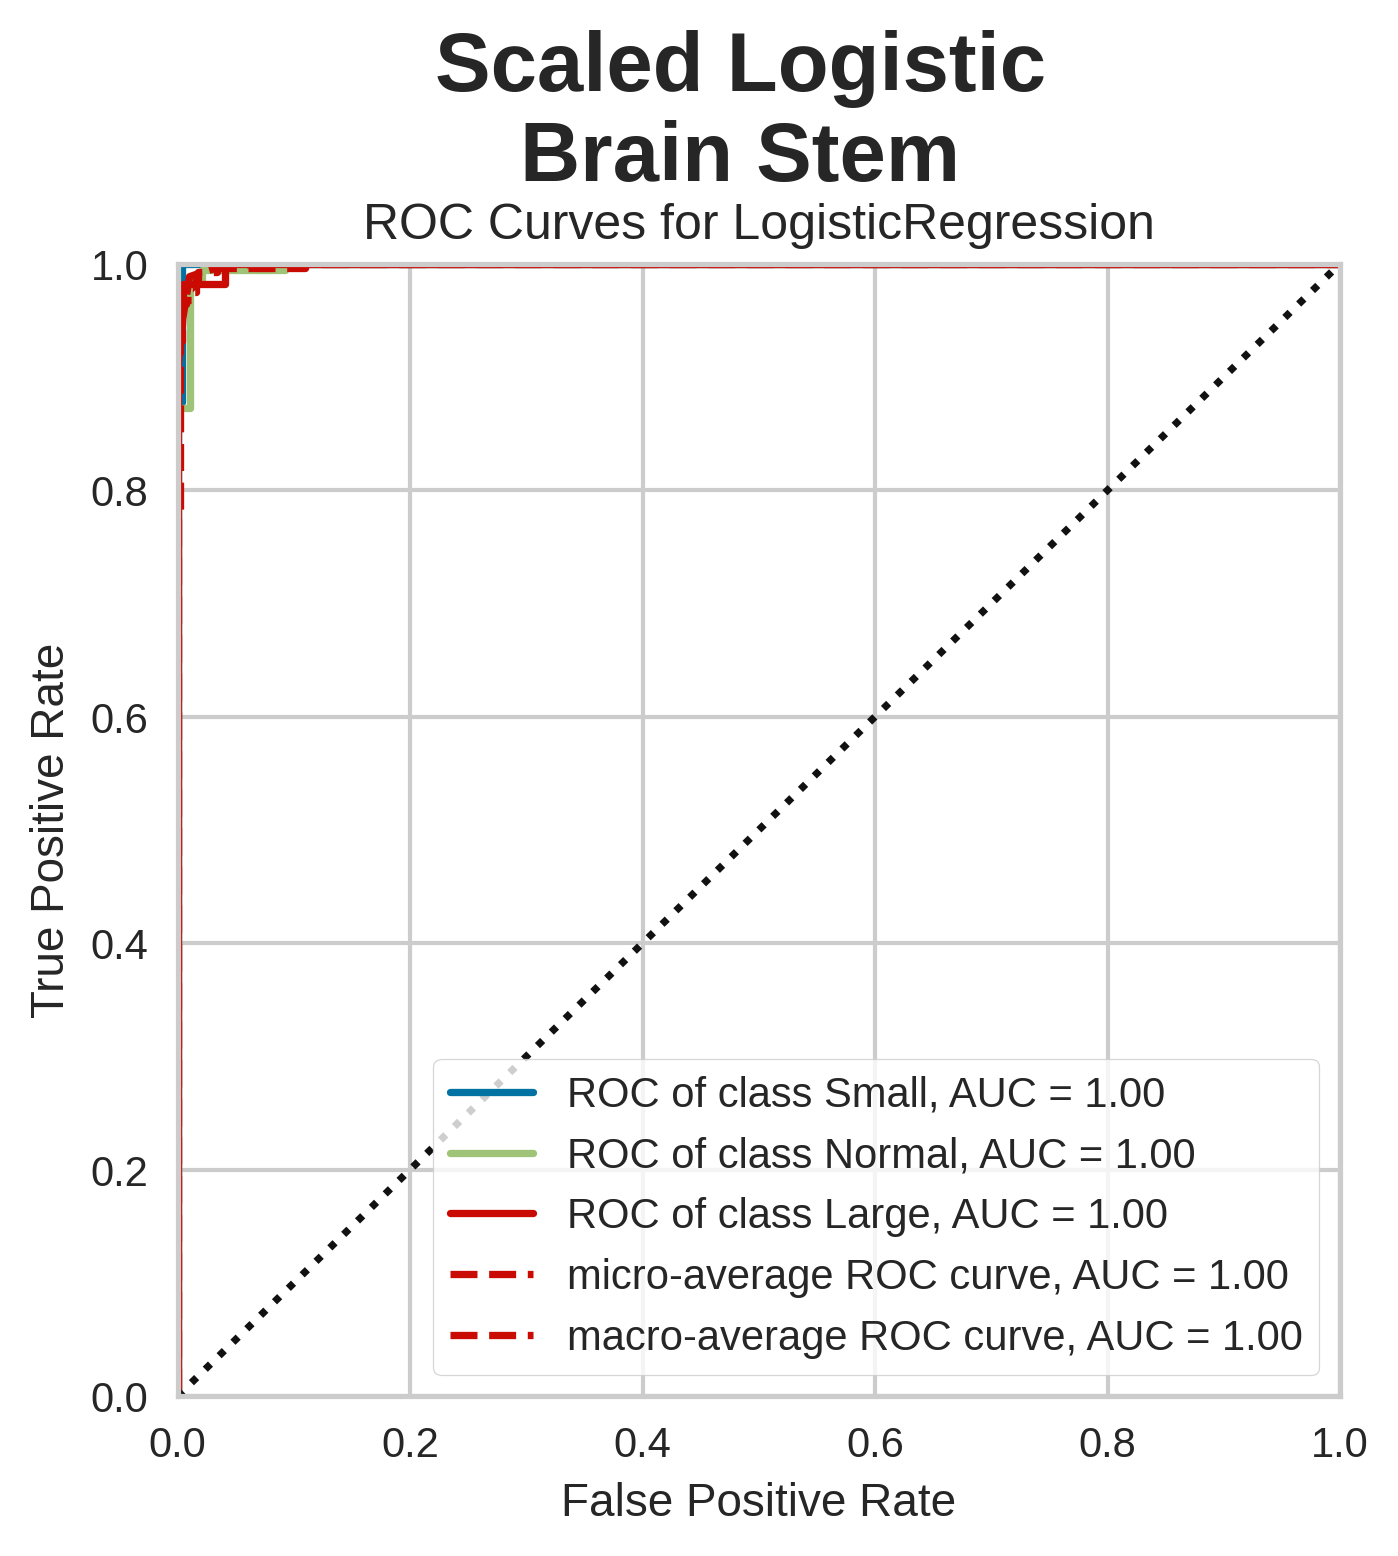

	Model Name: Scaled Balanced_Logistic_Brain_stem
	Model Place: 1


X does not have valid feature names, but LogisticRegression was fitted with feature names


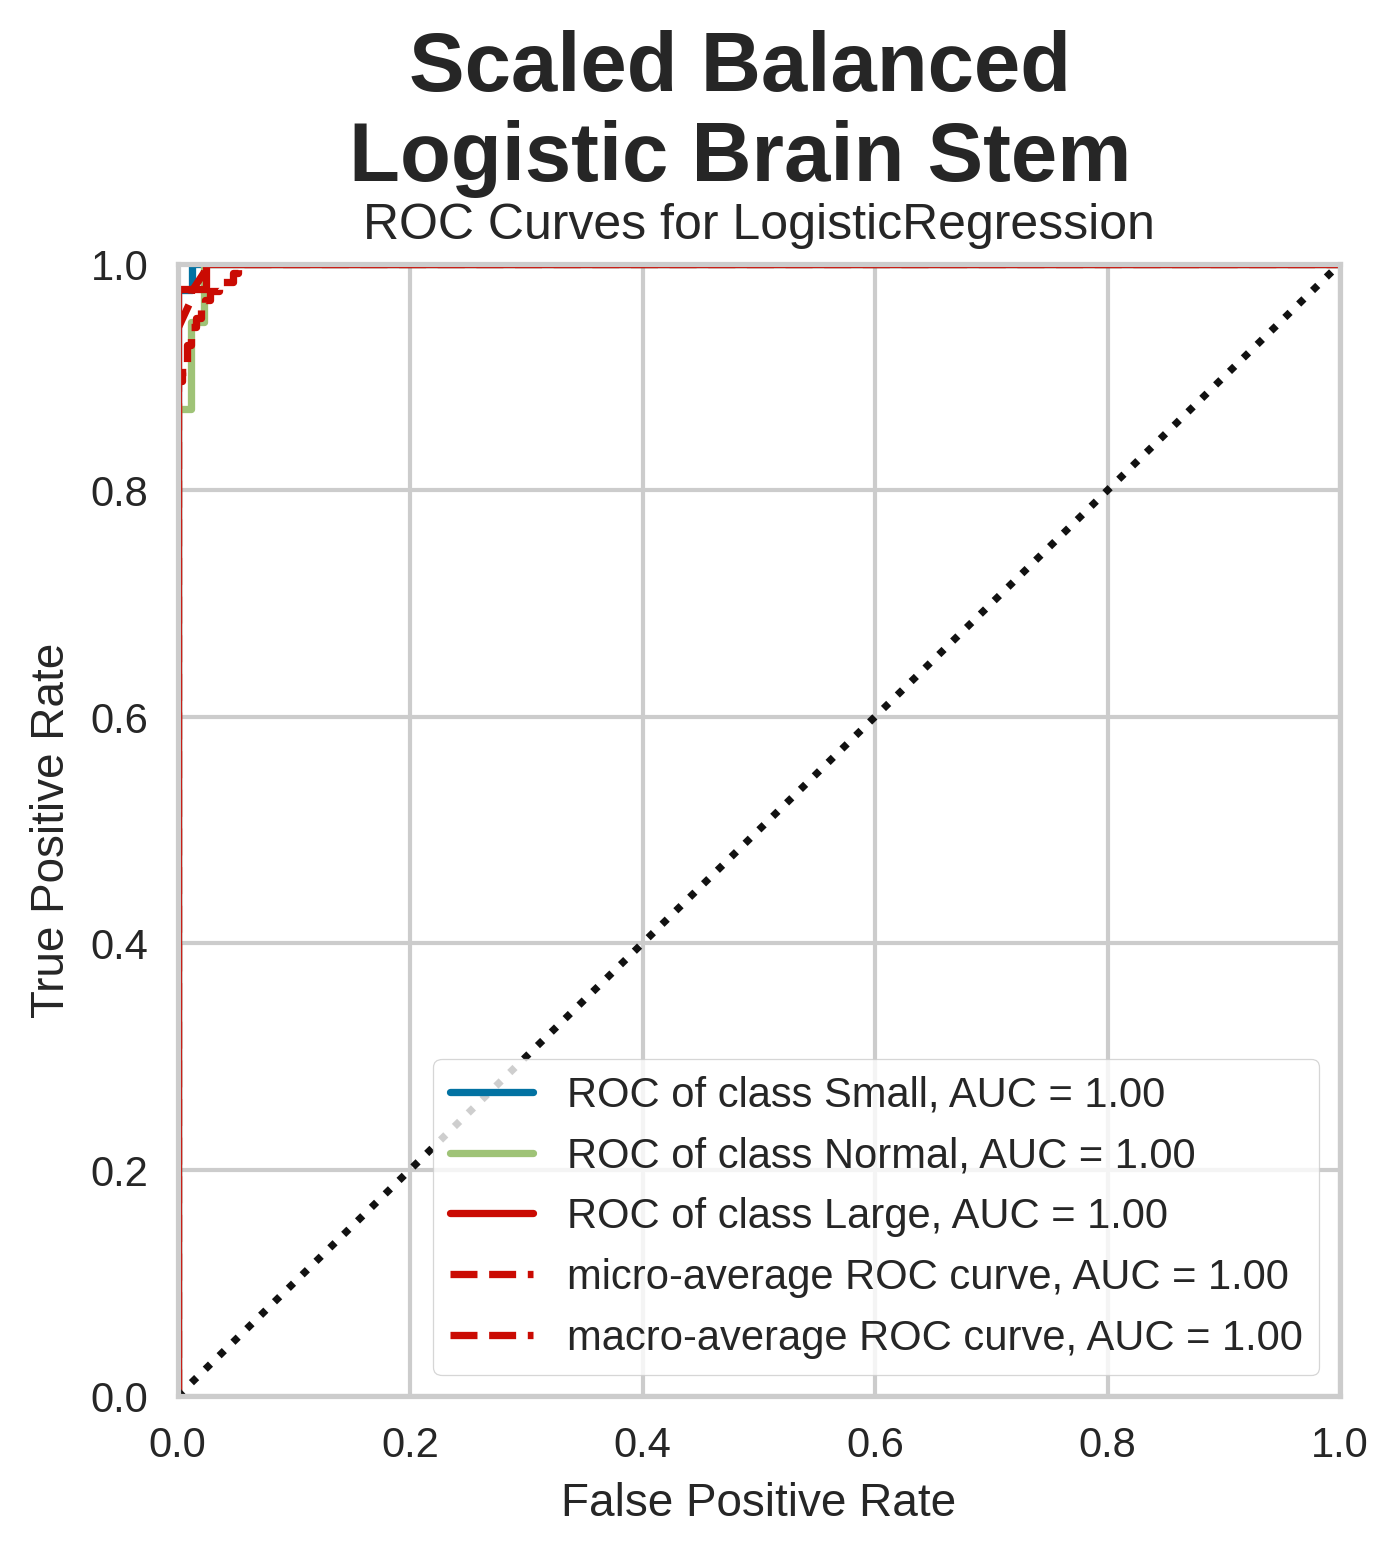

	Model Name: Raw_xGB_Brain_stem
	Model Place: 2


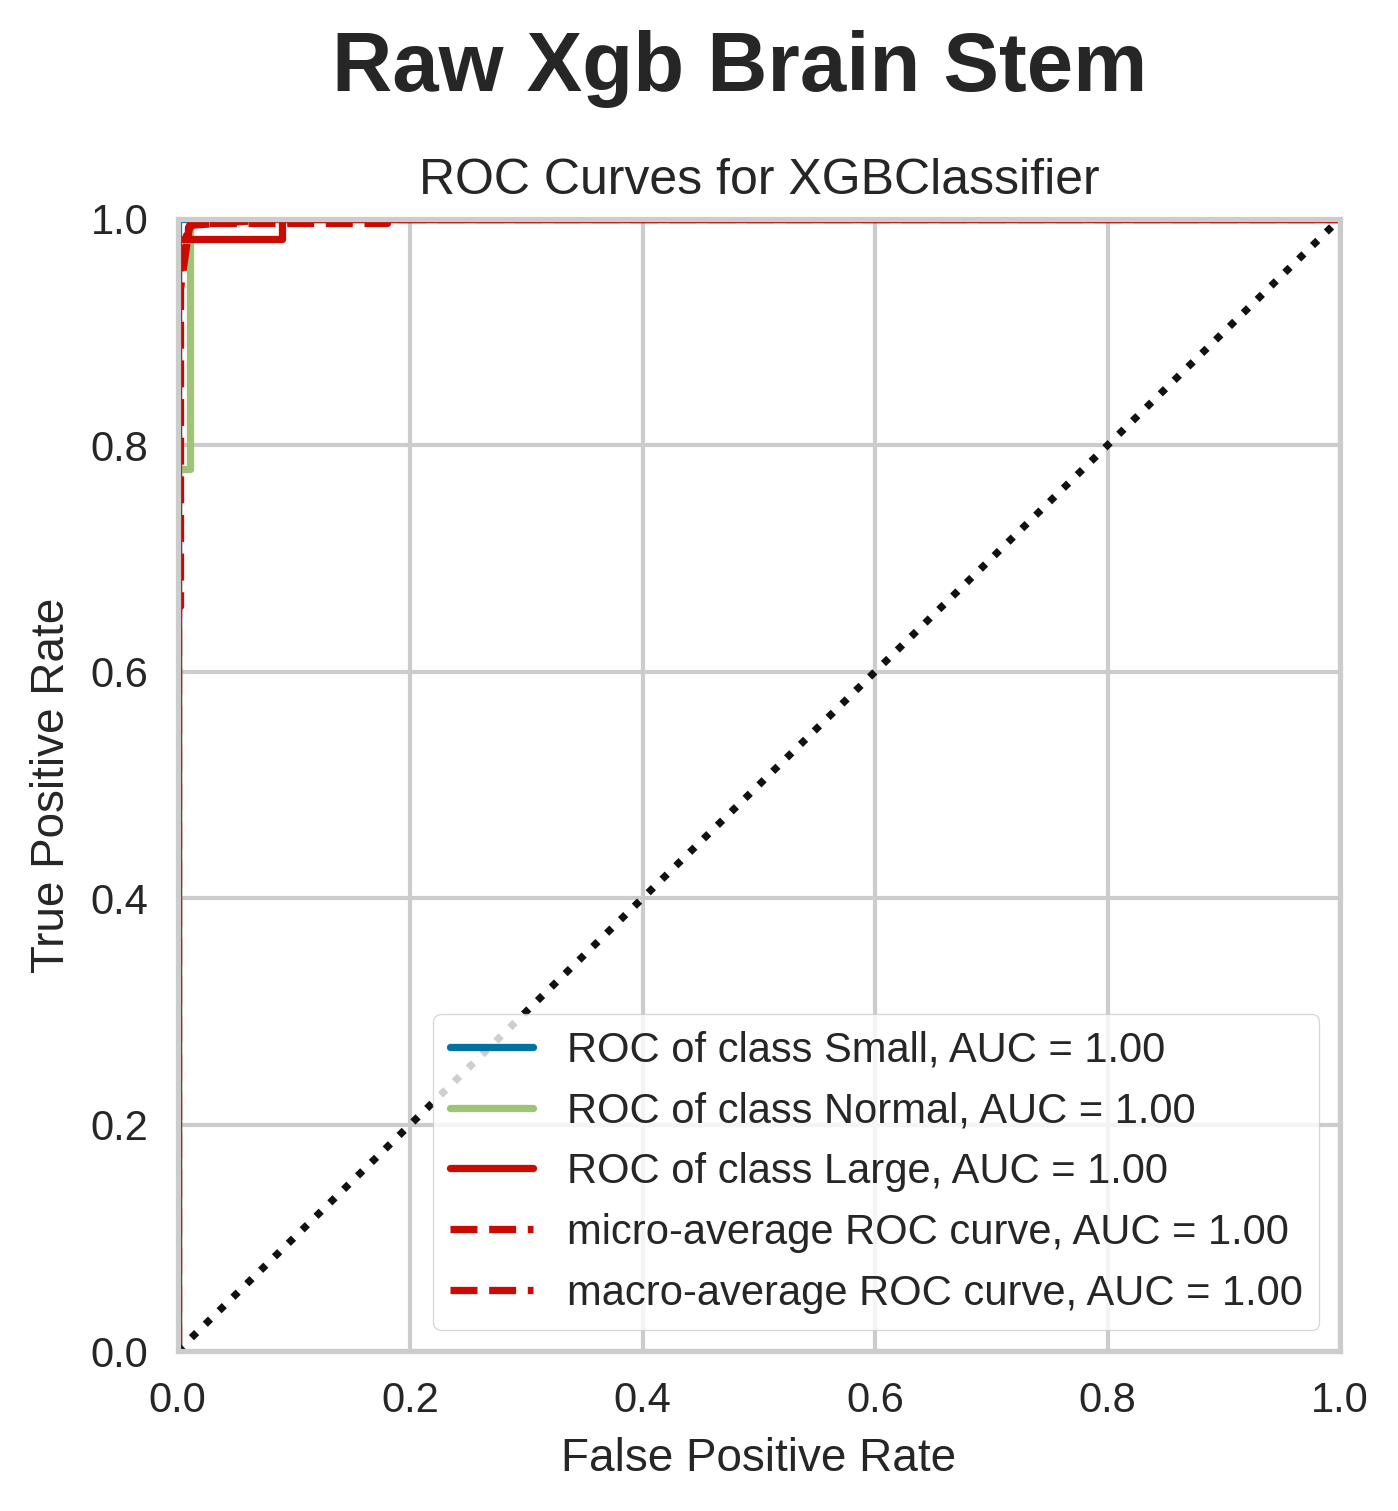

Best Model for Left_wm:
	Model Name: Scaled_Logistic_Left_wm
	Model Place: 0


X does not have valid feature names, but LogisticRegression was fitted with feature names


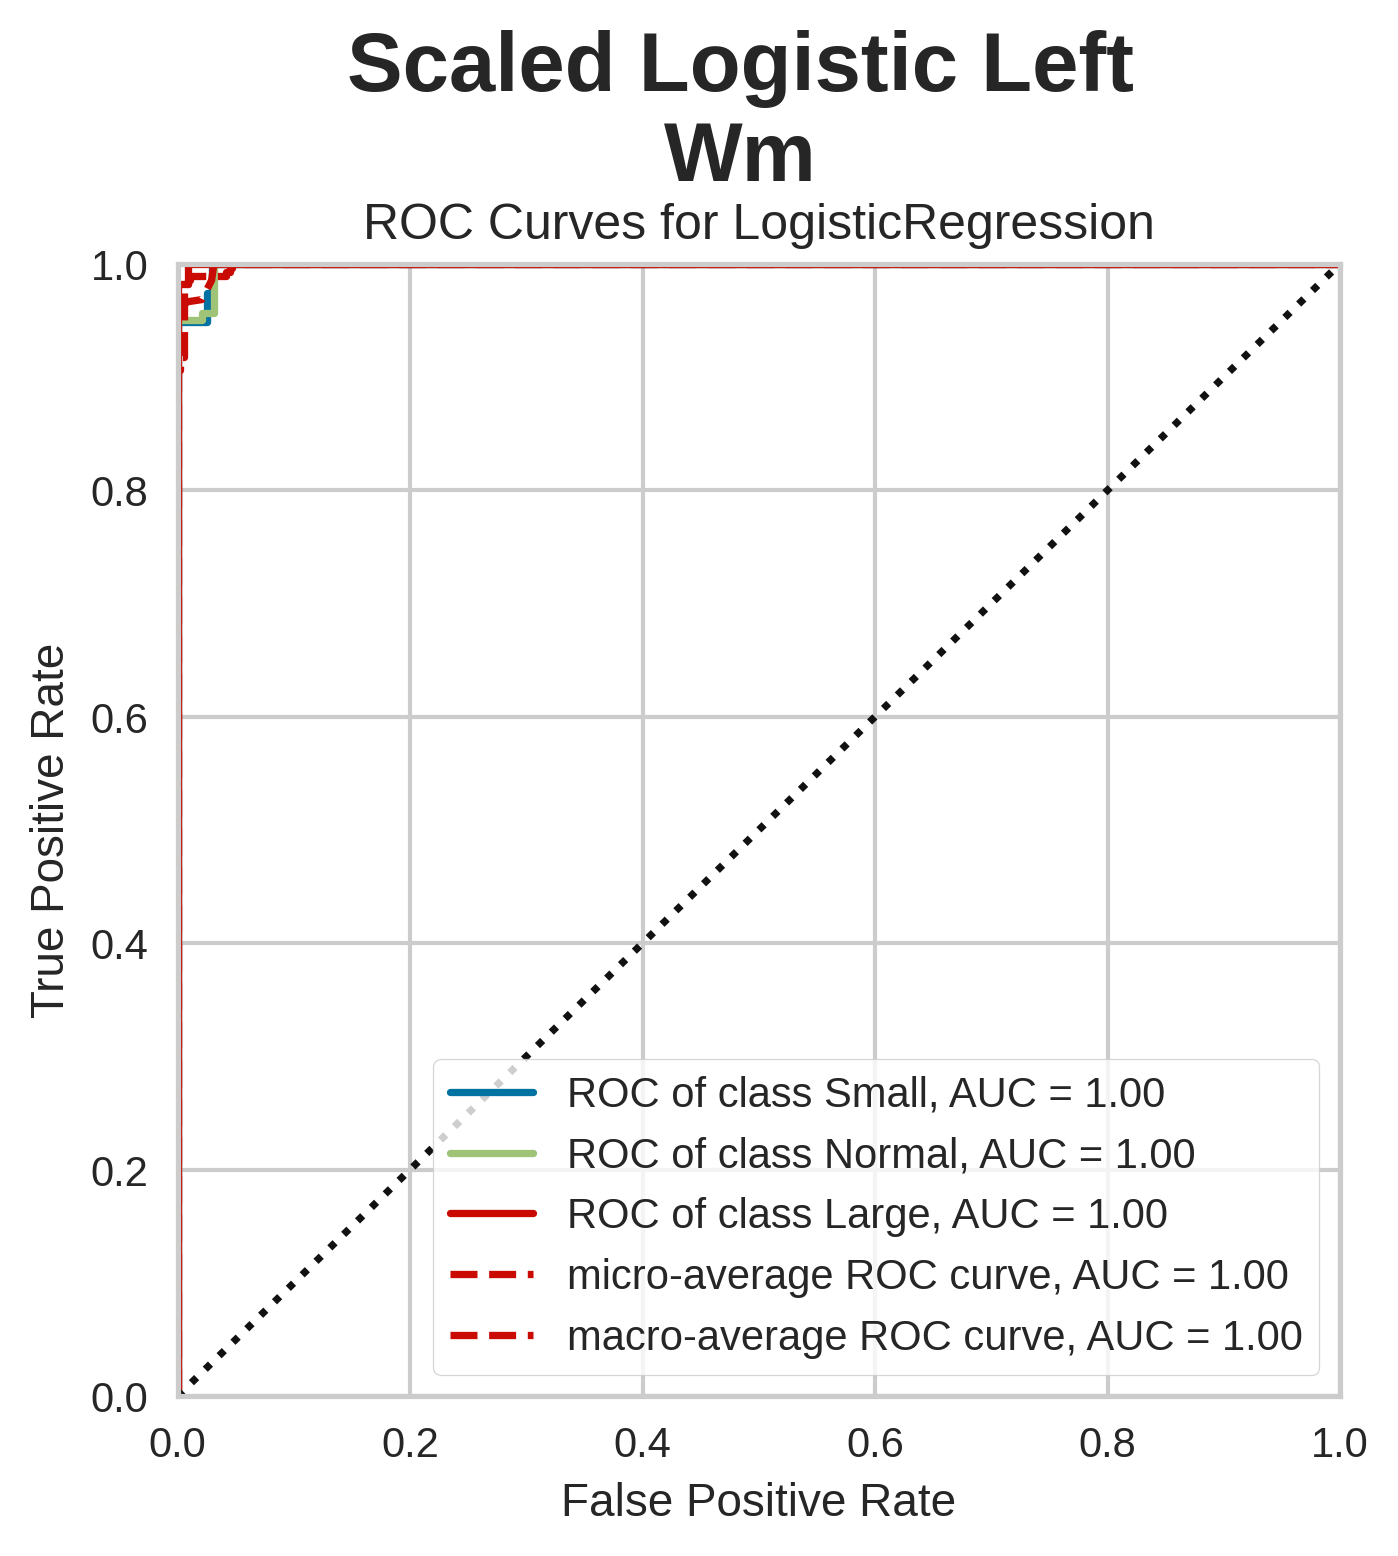

	Model Name: Raw_xGB_Left_wm
	Model Place: 1


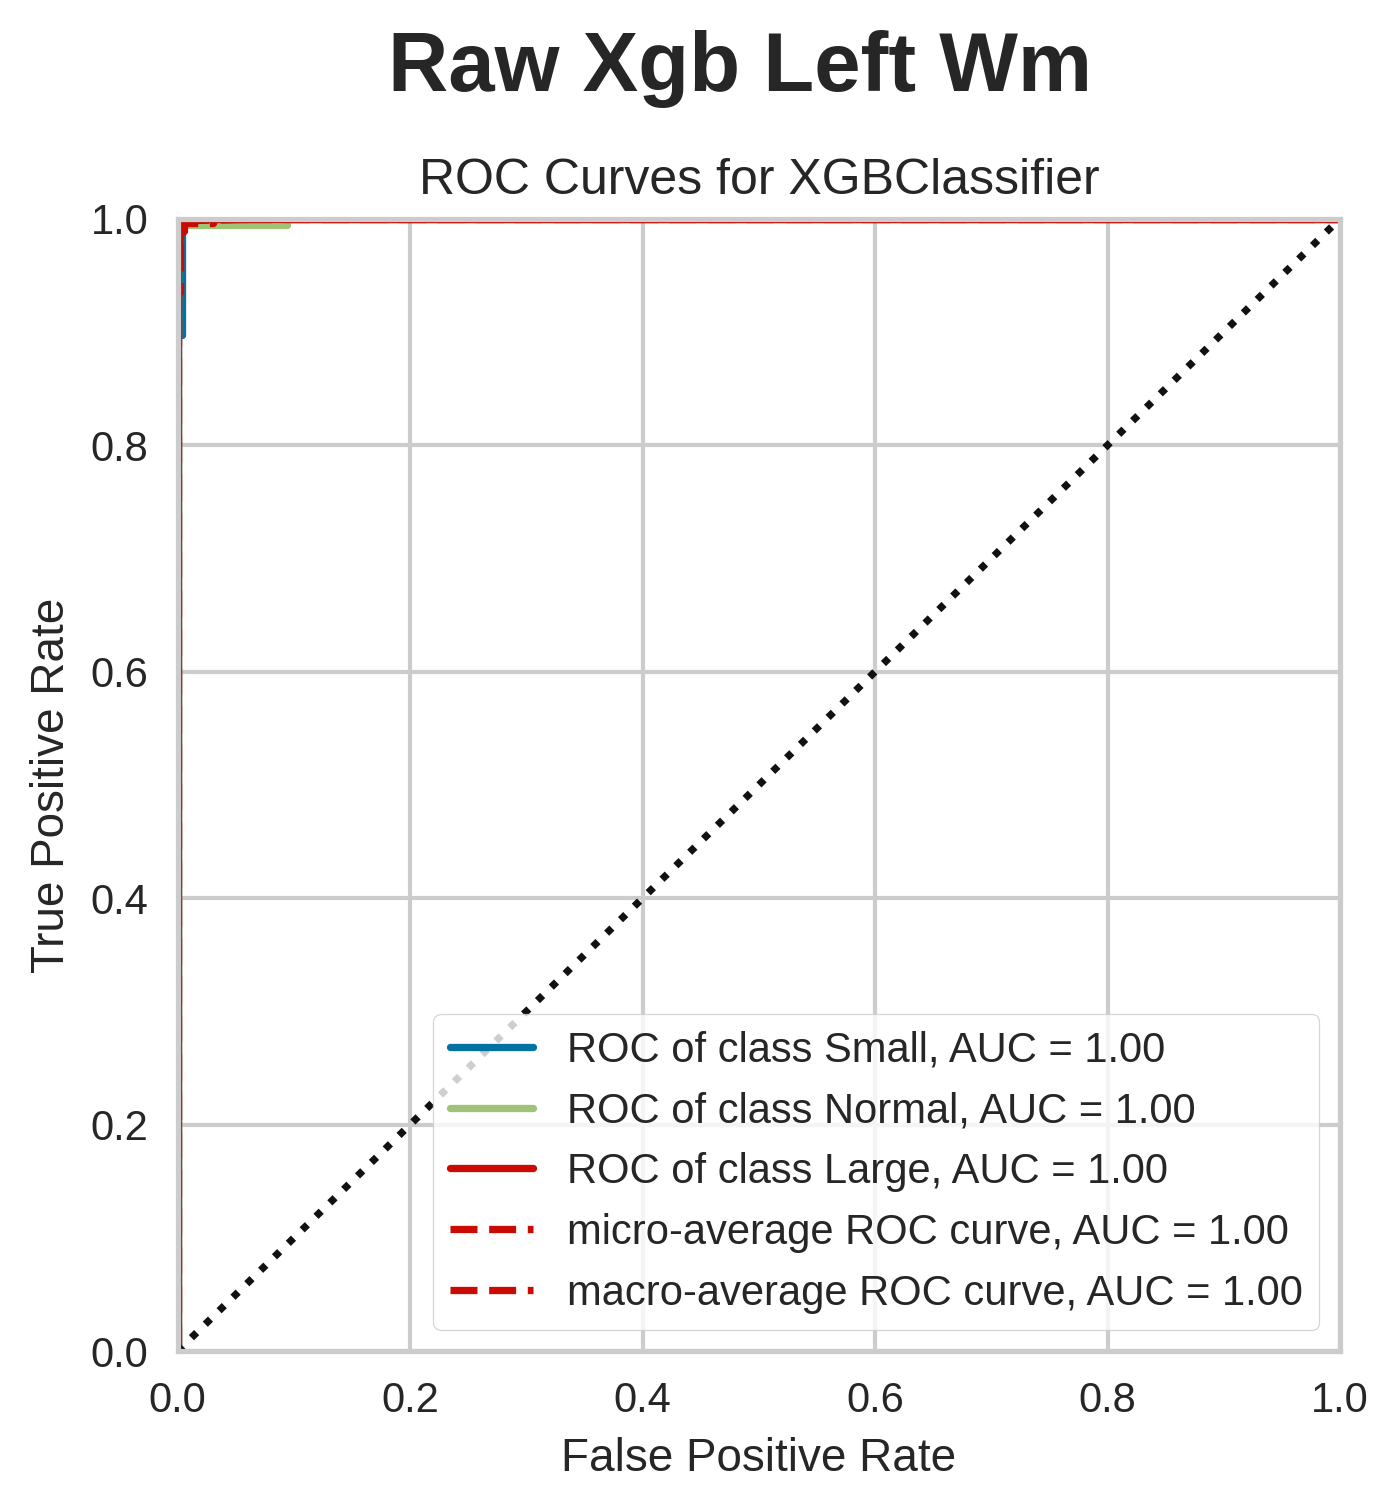

	Model Name: Scaled_xGB_Left_wm
	Model Place: 2


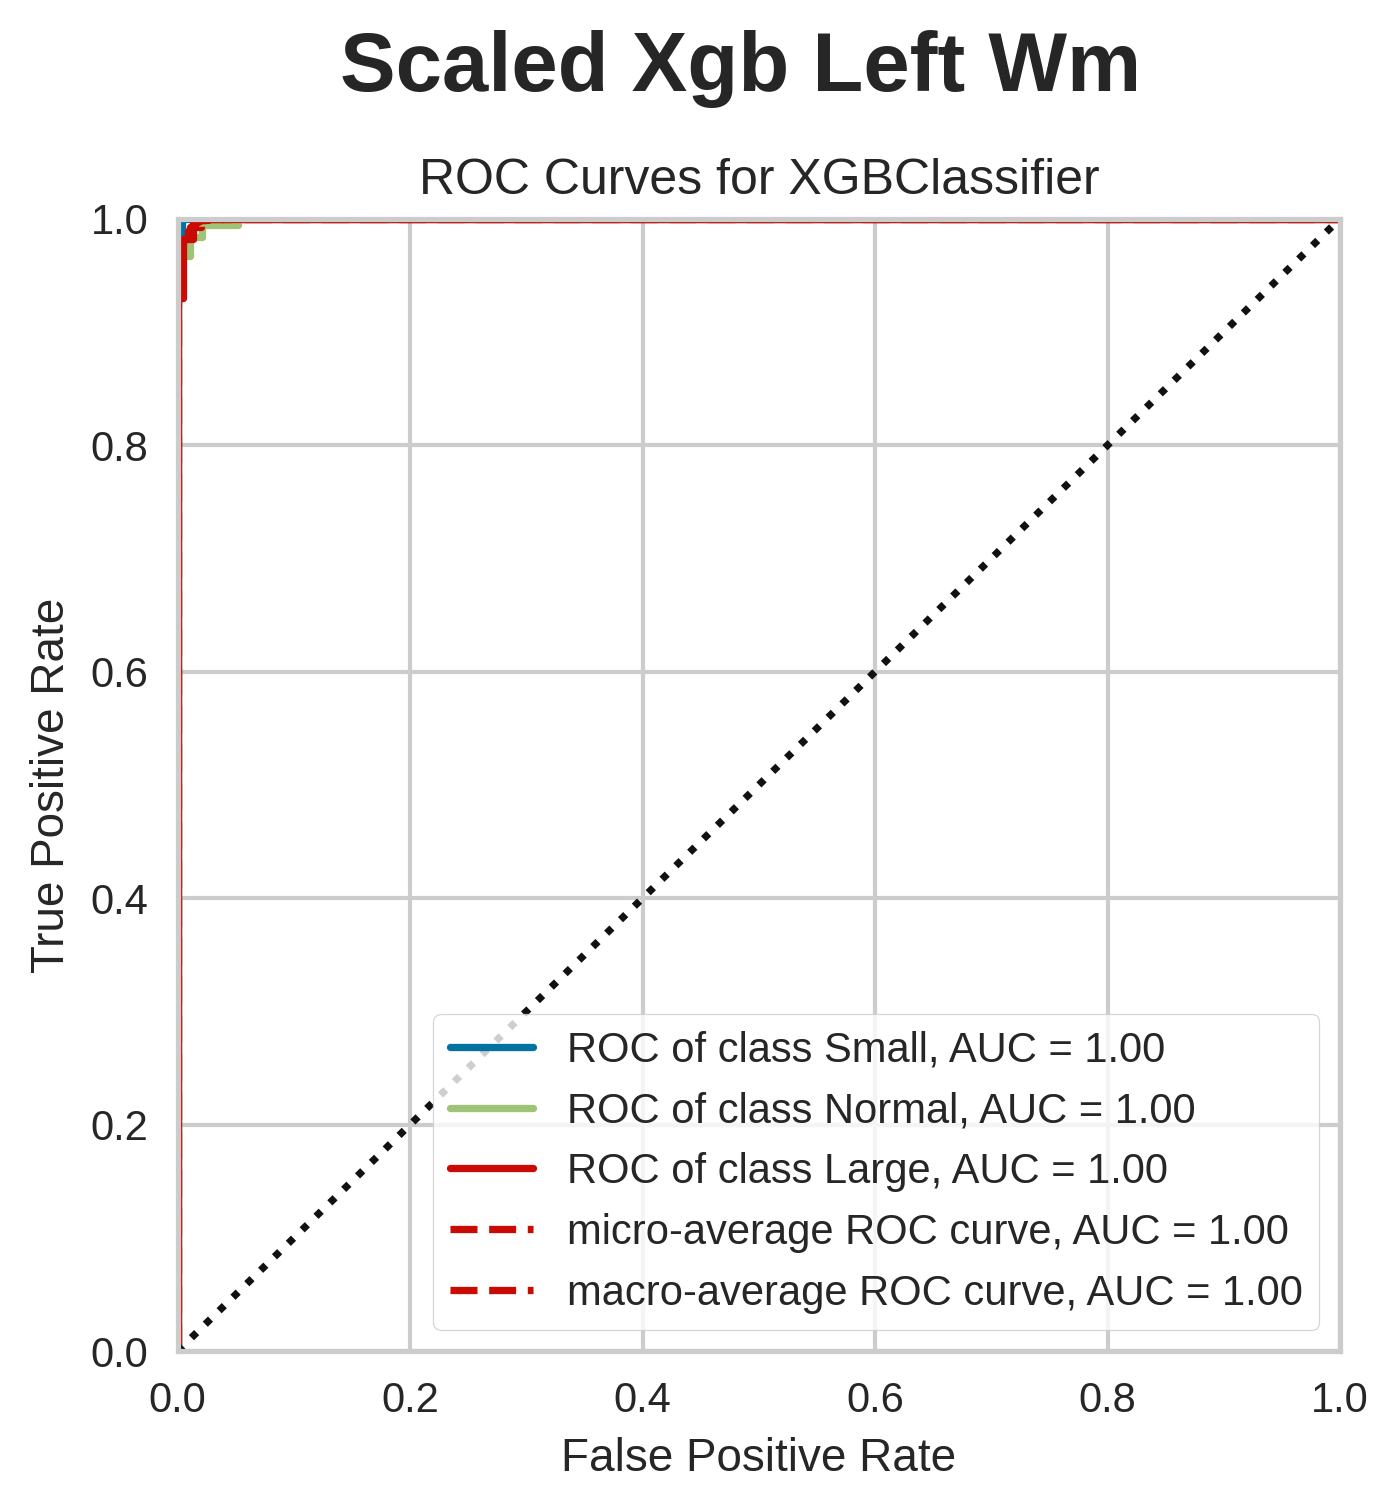

Best Model for Left_gm:
	Model Name: Scaled_Logistic_Left_gm
	Model Place: 0


X does not have valid feature names, but LogisticRegression was fitted with feature names


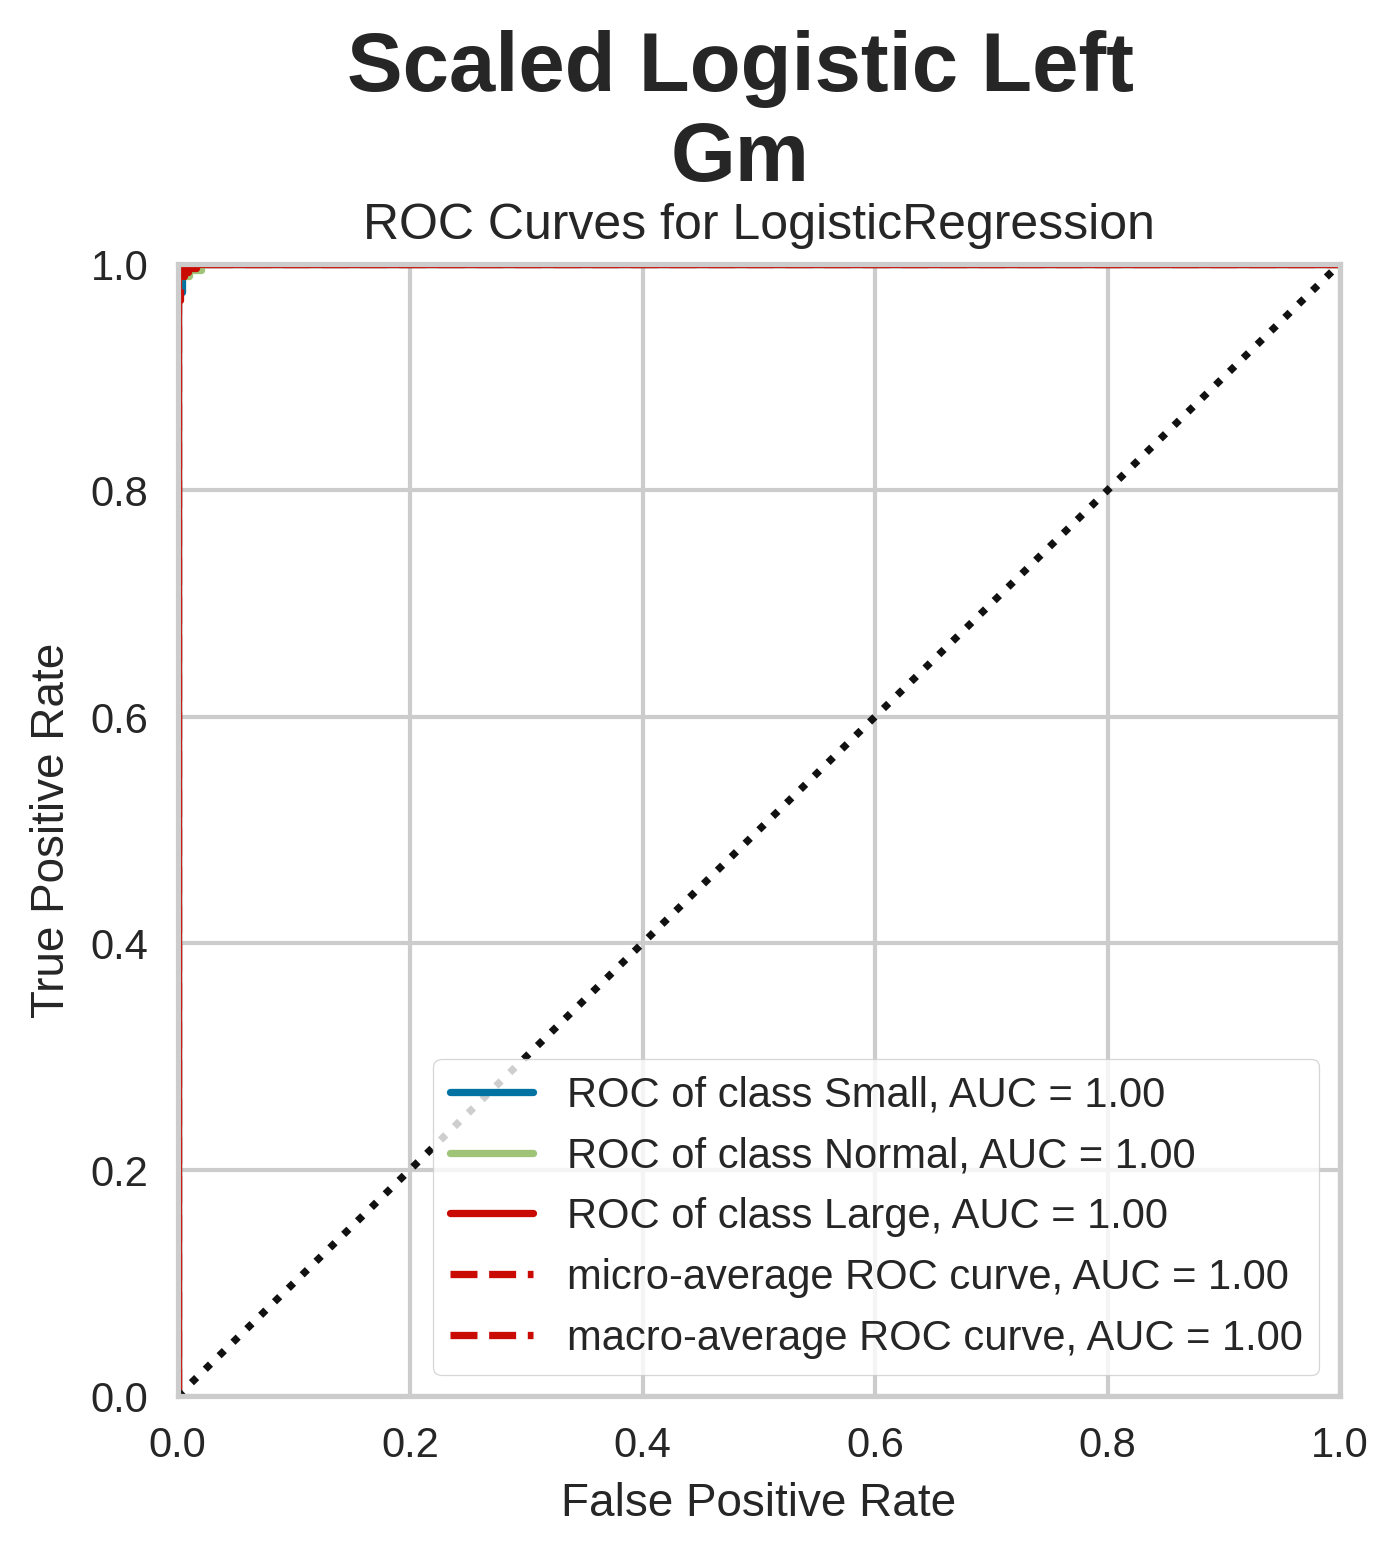

	Model Name: Balanced_xGB_Left_gm
	Model Place: 1


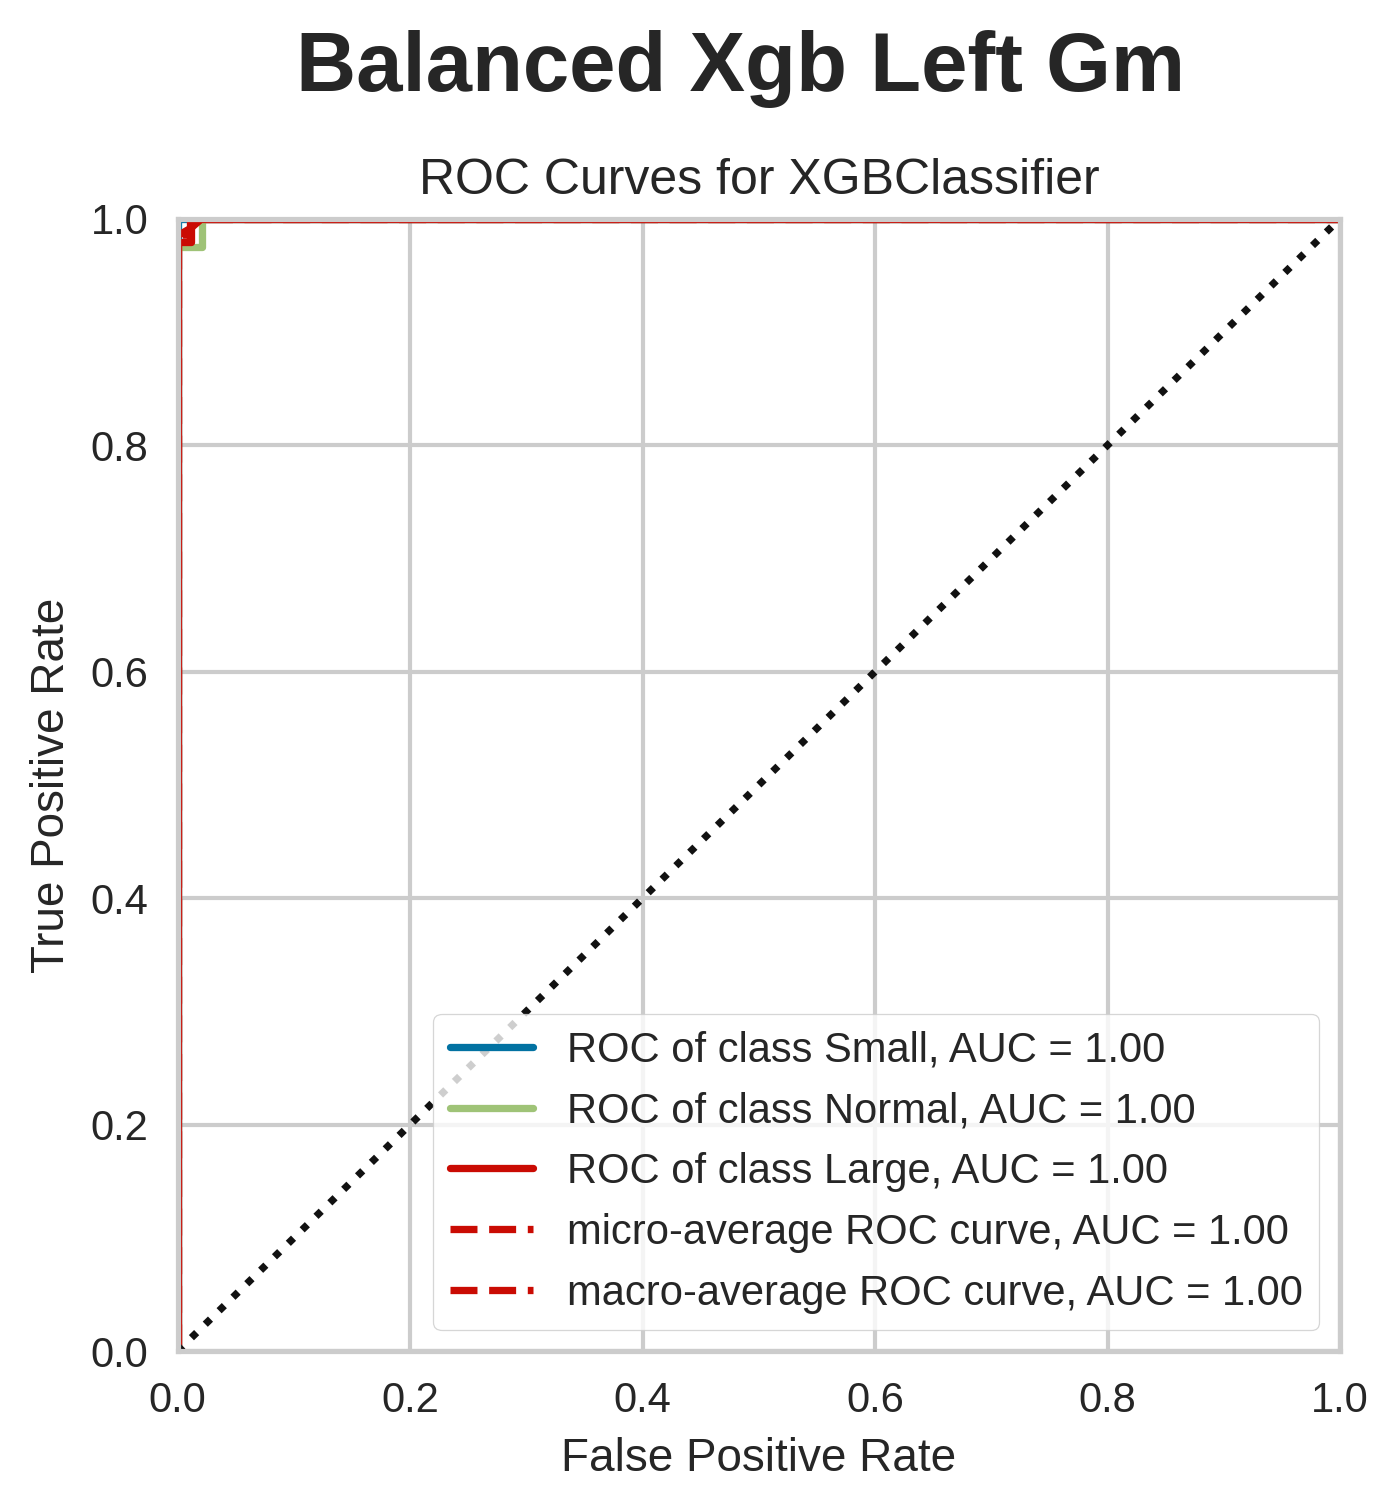

	Model Name: Raw_xGB_Left_gm
	Model Place: 2


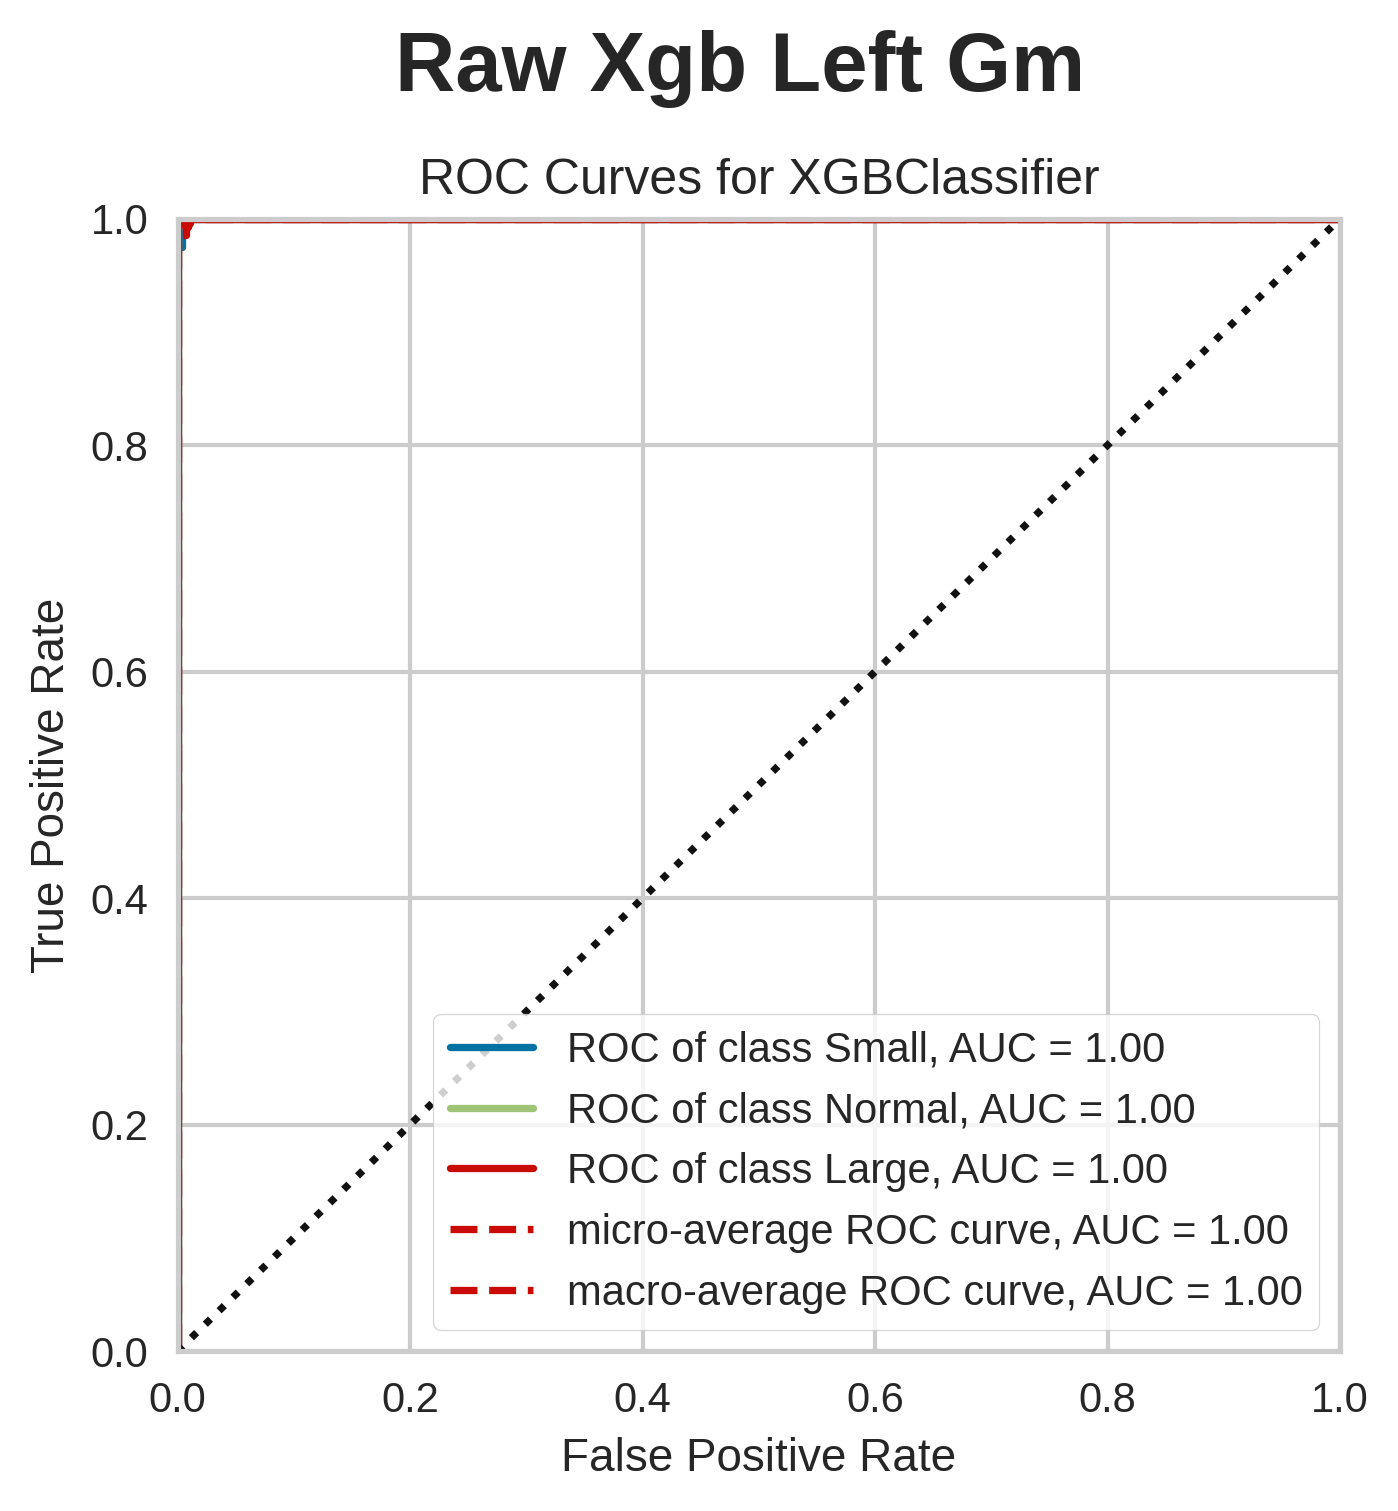

Best Model for Right_wm:
	Model Name: Scaled_Logistic_Right_wm
	Model Place: 0


X does not have valid feature names, but LogisticRegression was fitted with feature names


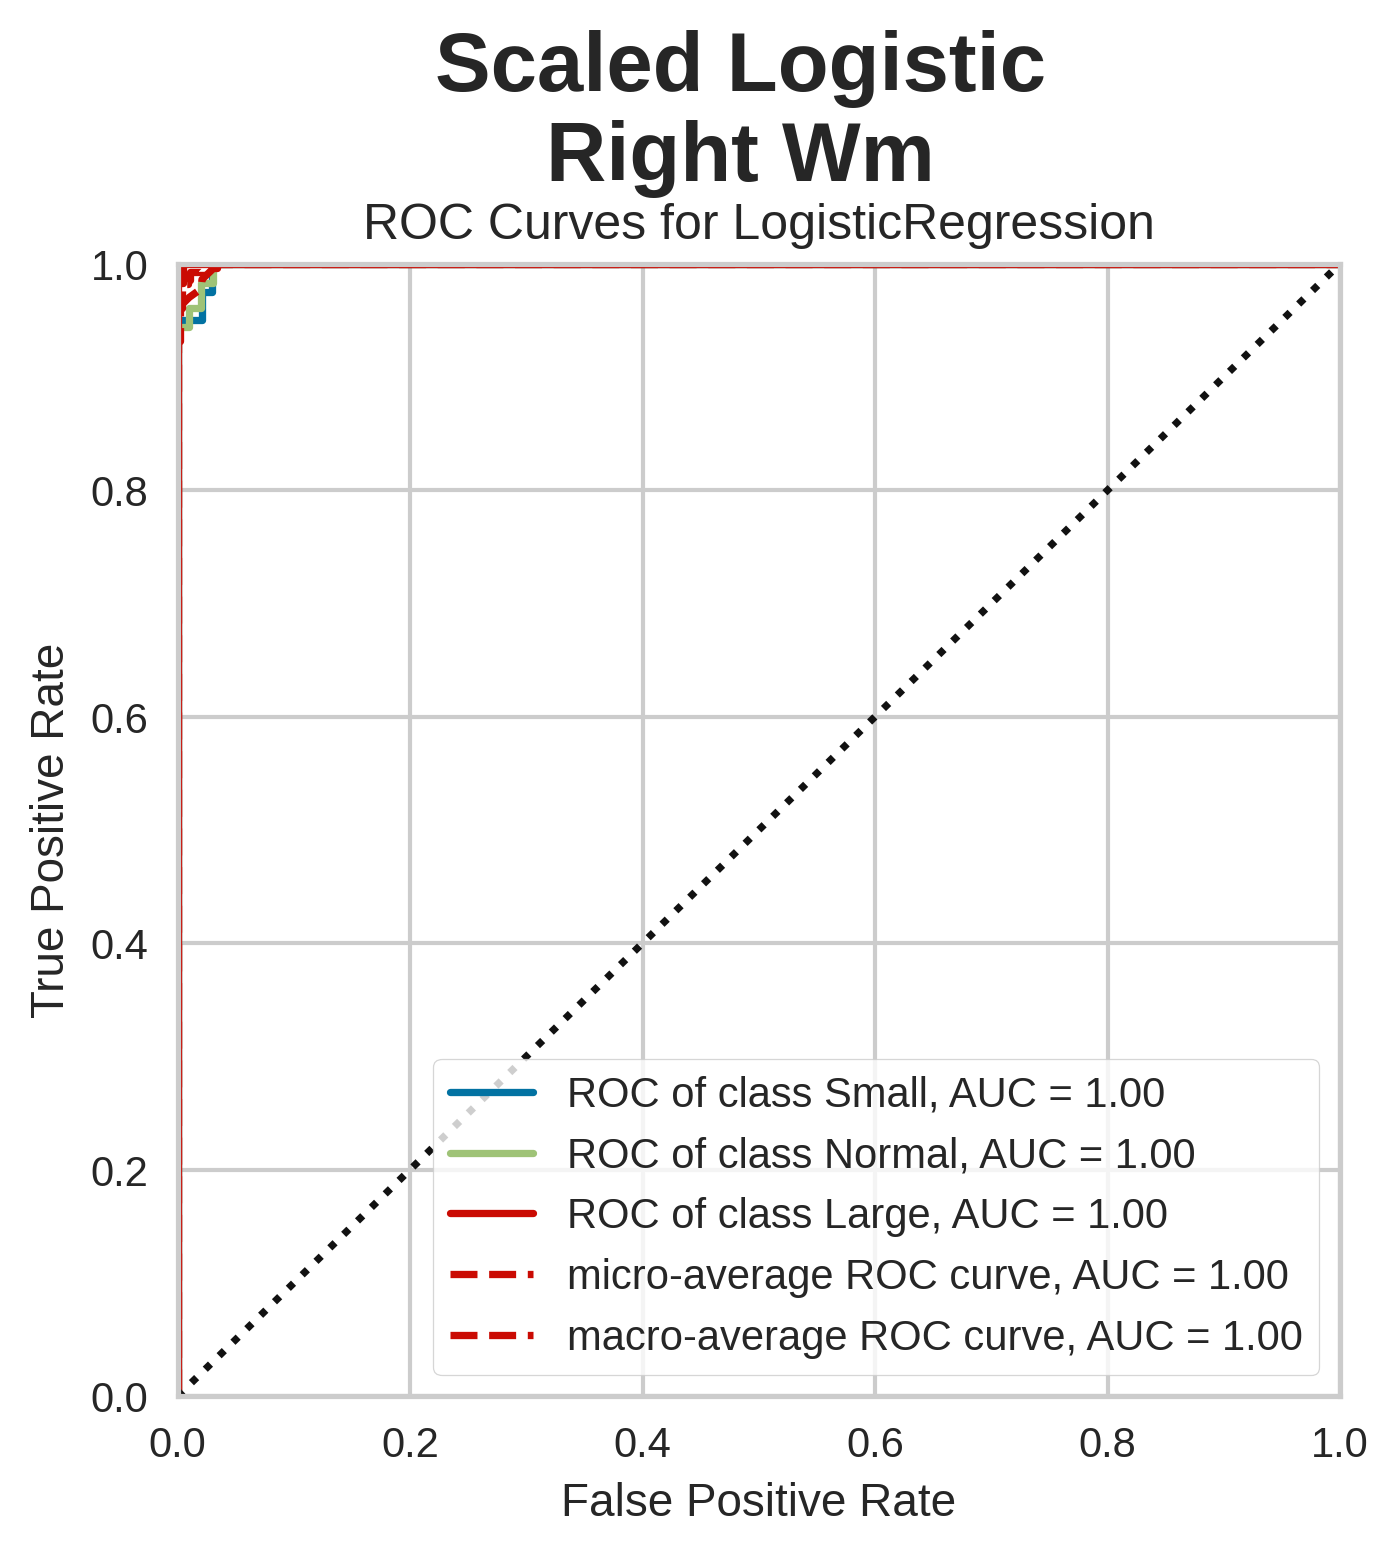

	Model Name: Scaled Balanced_Logistic_Right_wm
	Model Place: 1


X does not have valid feature names, but LogisticRegression was fitted with feature names


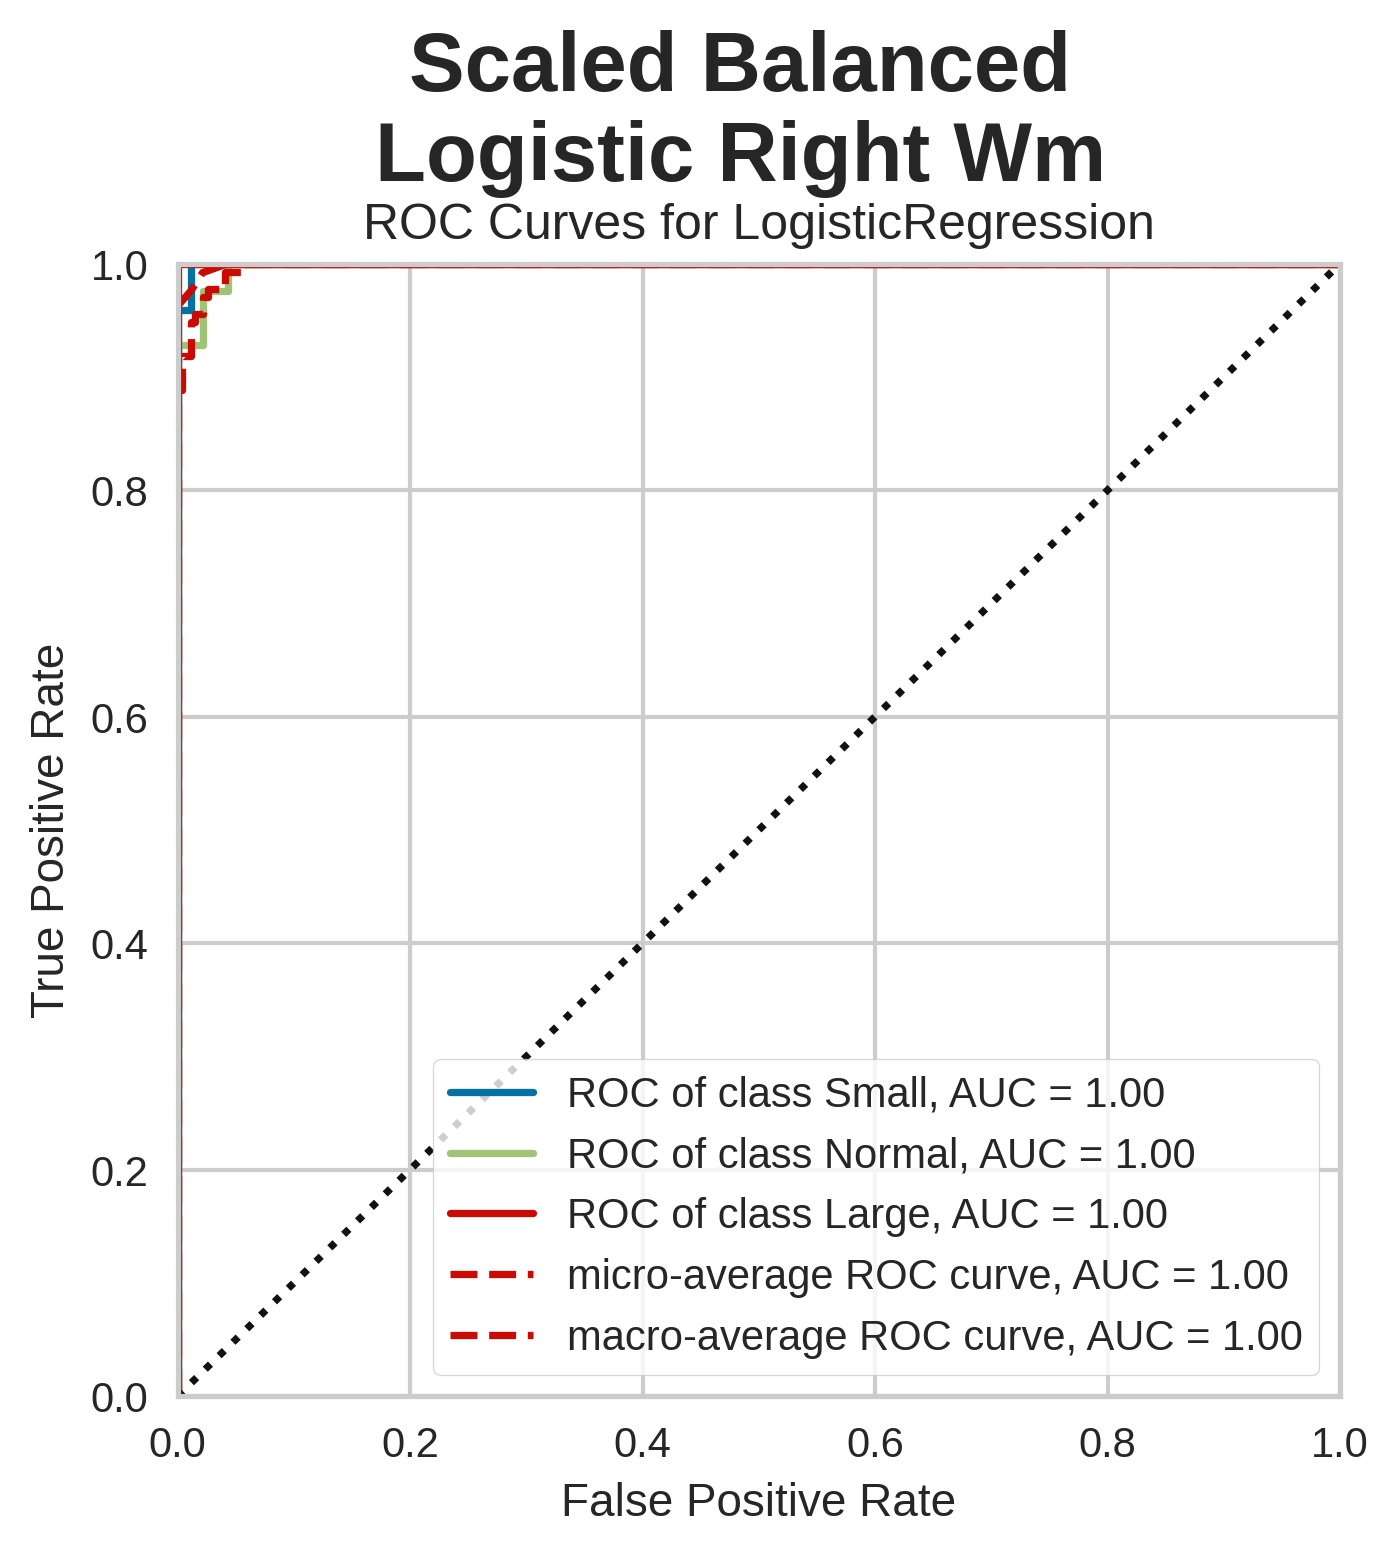

	Model Name: Scaled Balanced_xGB_Right_wm
	Model Place: 2


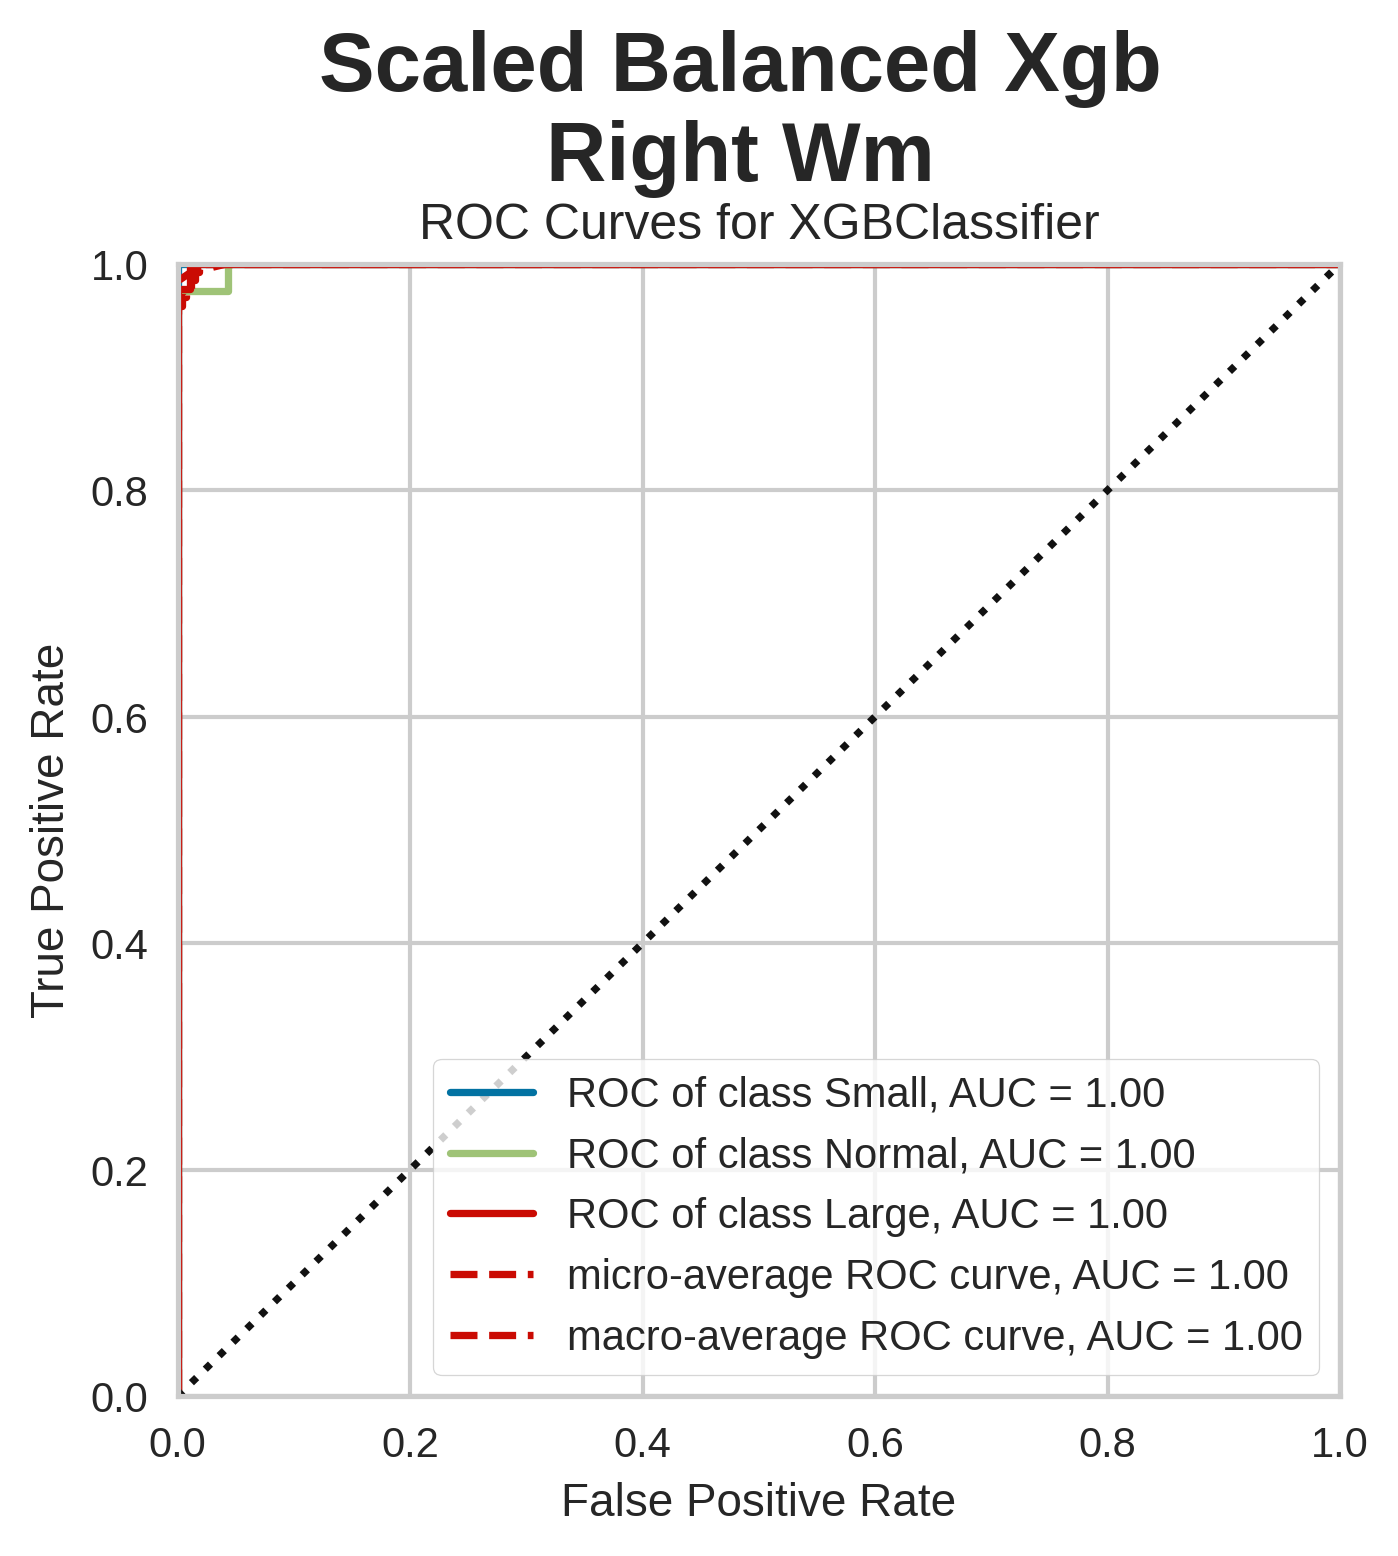

Best Model for Right_gm:
	Model Name: Scaled_Logistic_Right_gm
	Model Place: 0


X does not have valid feature names, but LogisticRegression was fitted with feature names


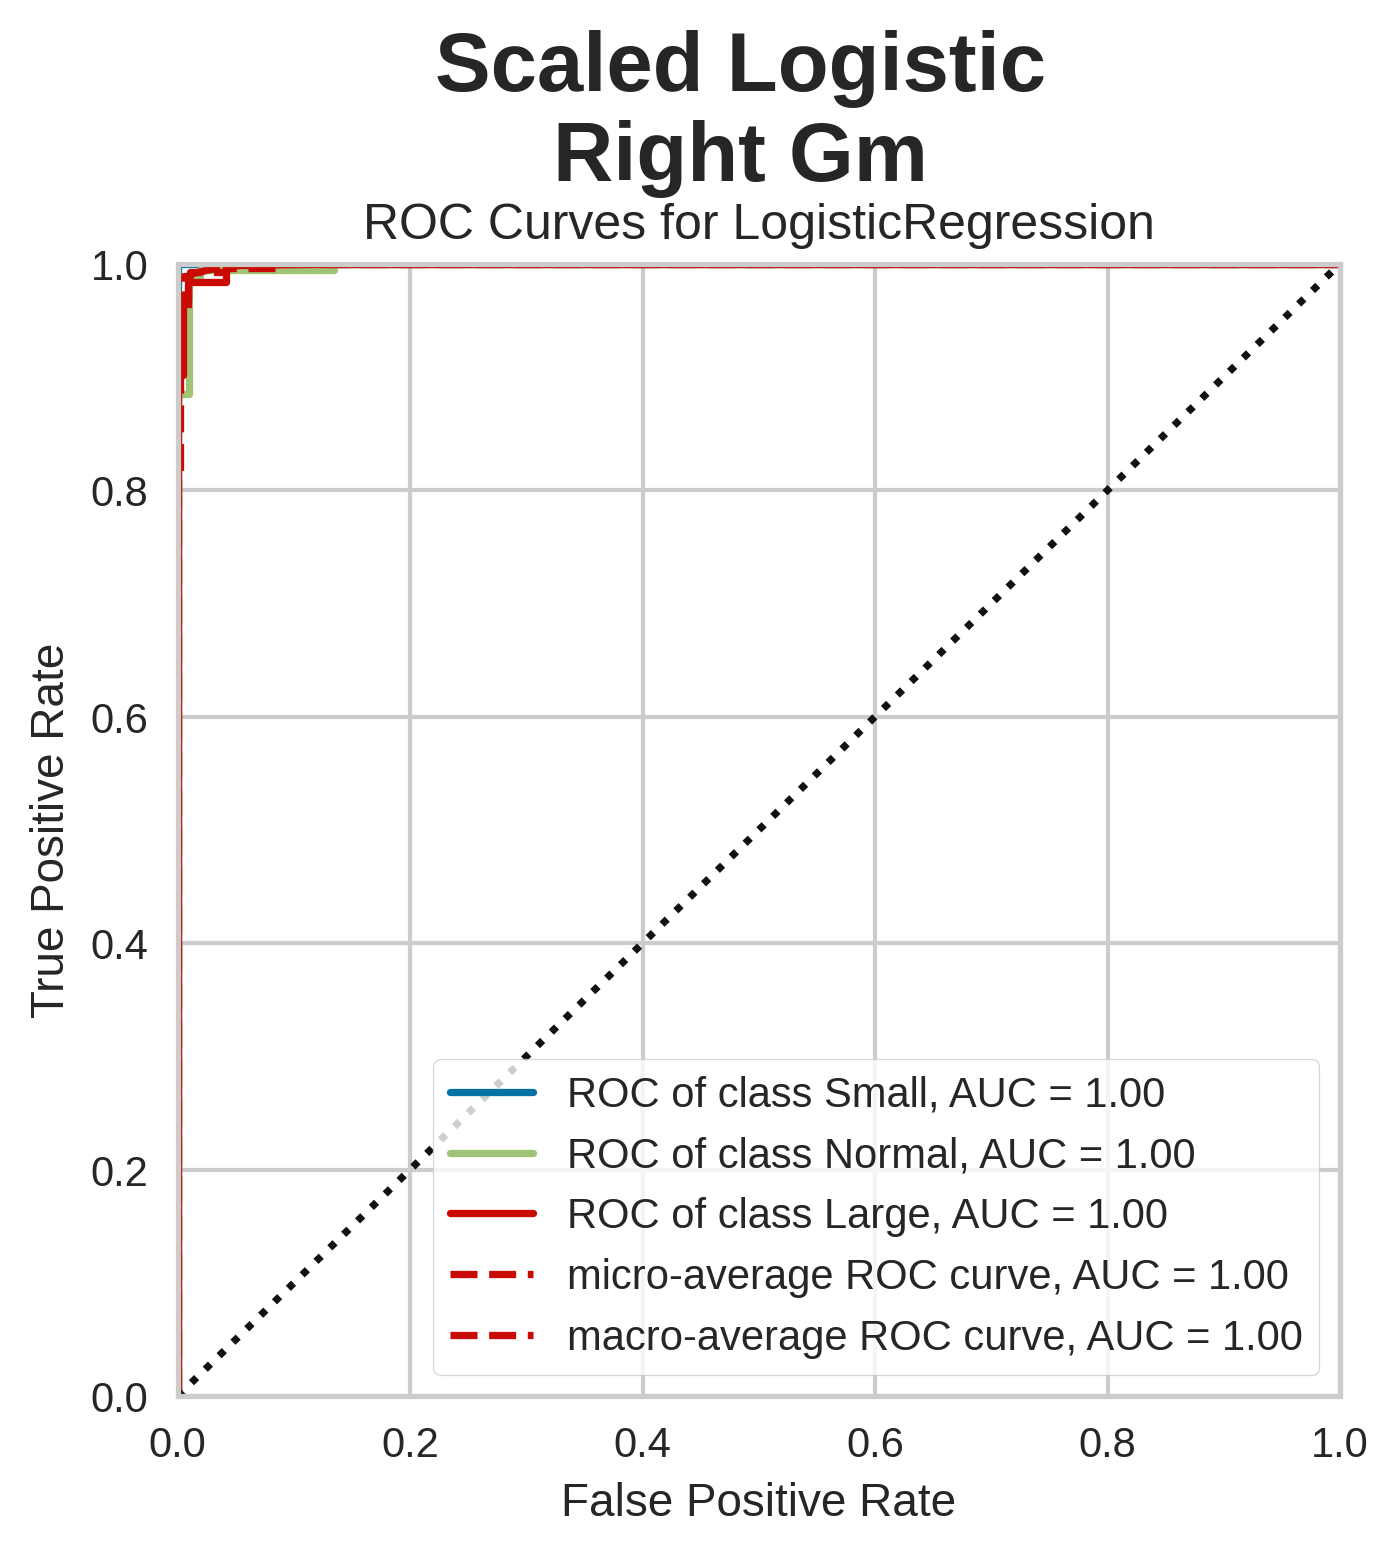

	Model Name: Raw_xGB_Right_gm
	Model Place: 1


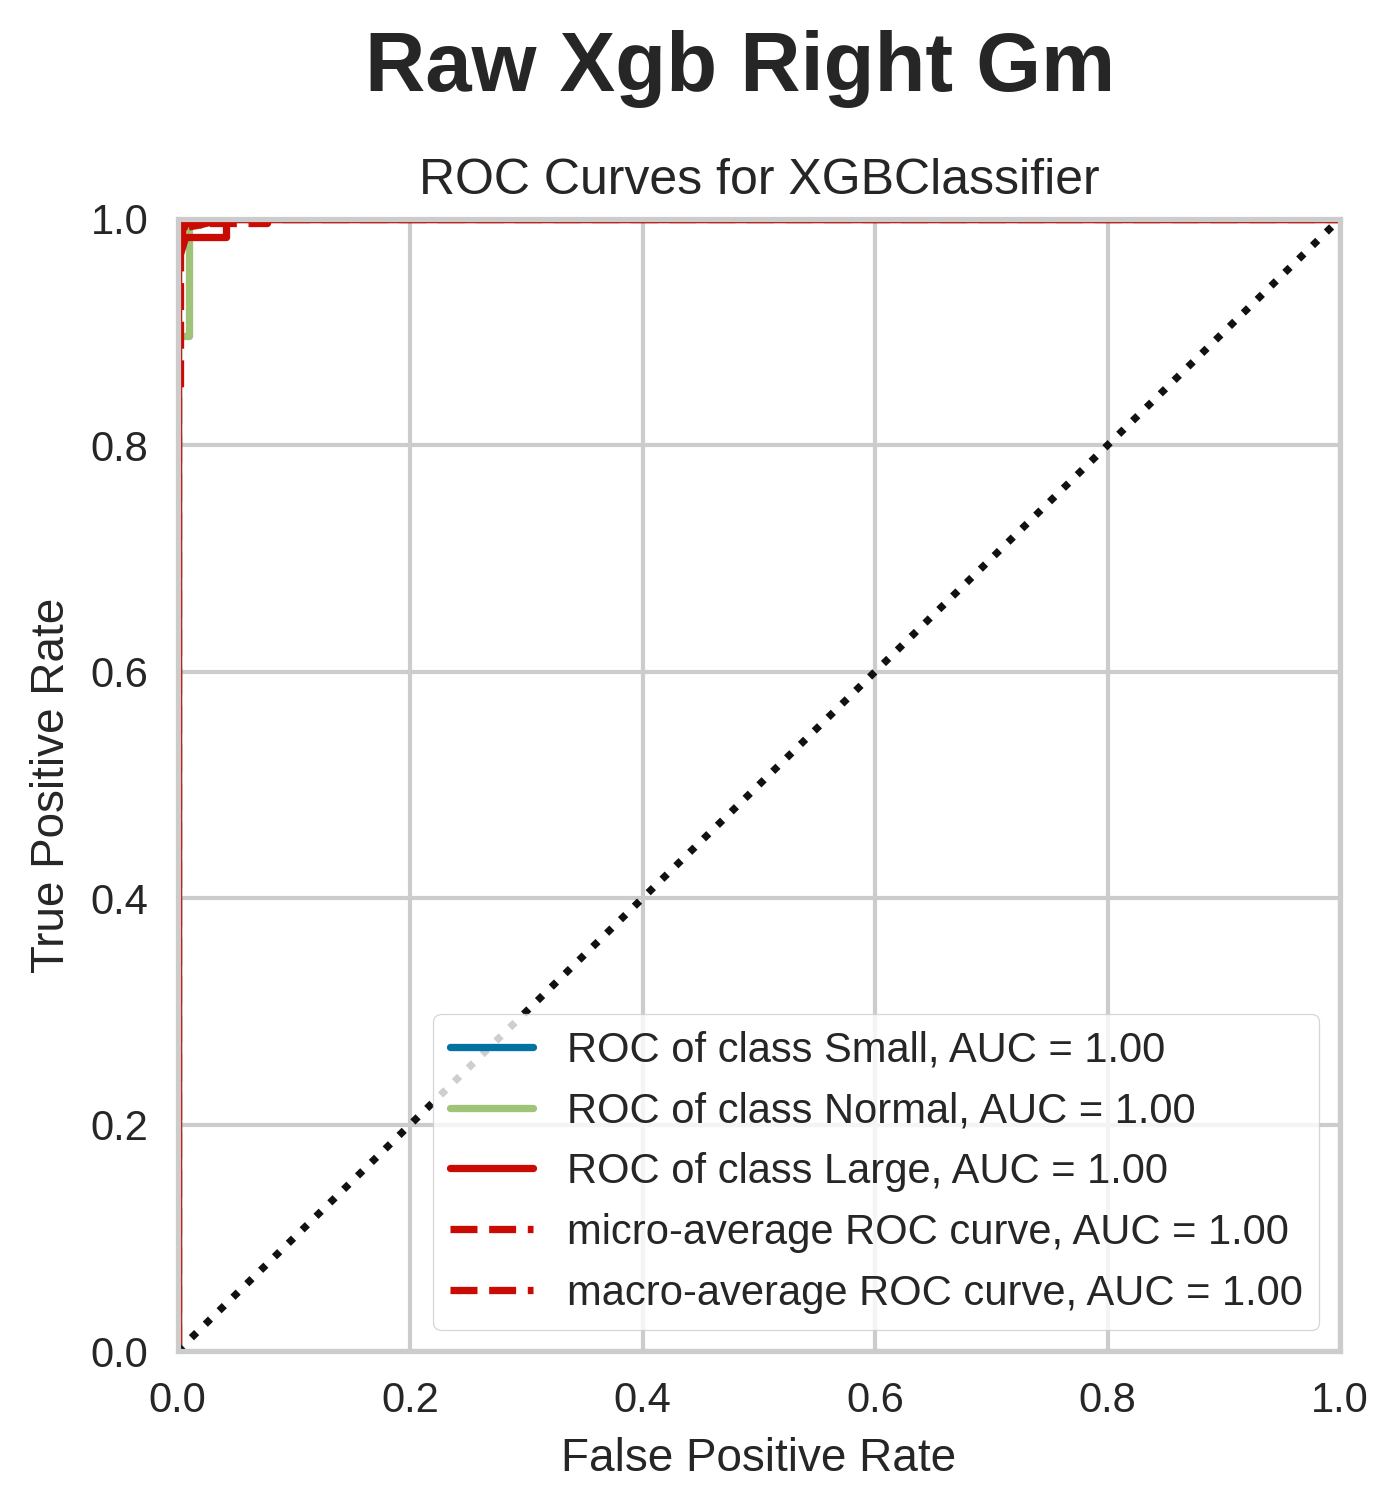

	Model Name: Scaled_xGB_Right_gm
	Model Place: 2


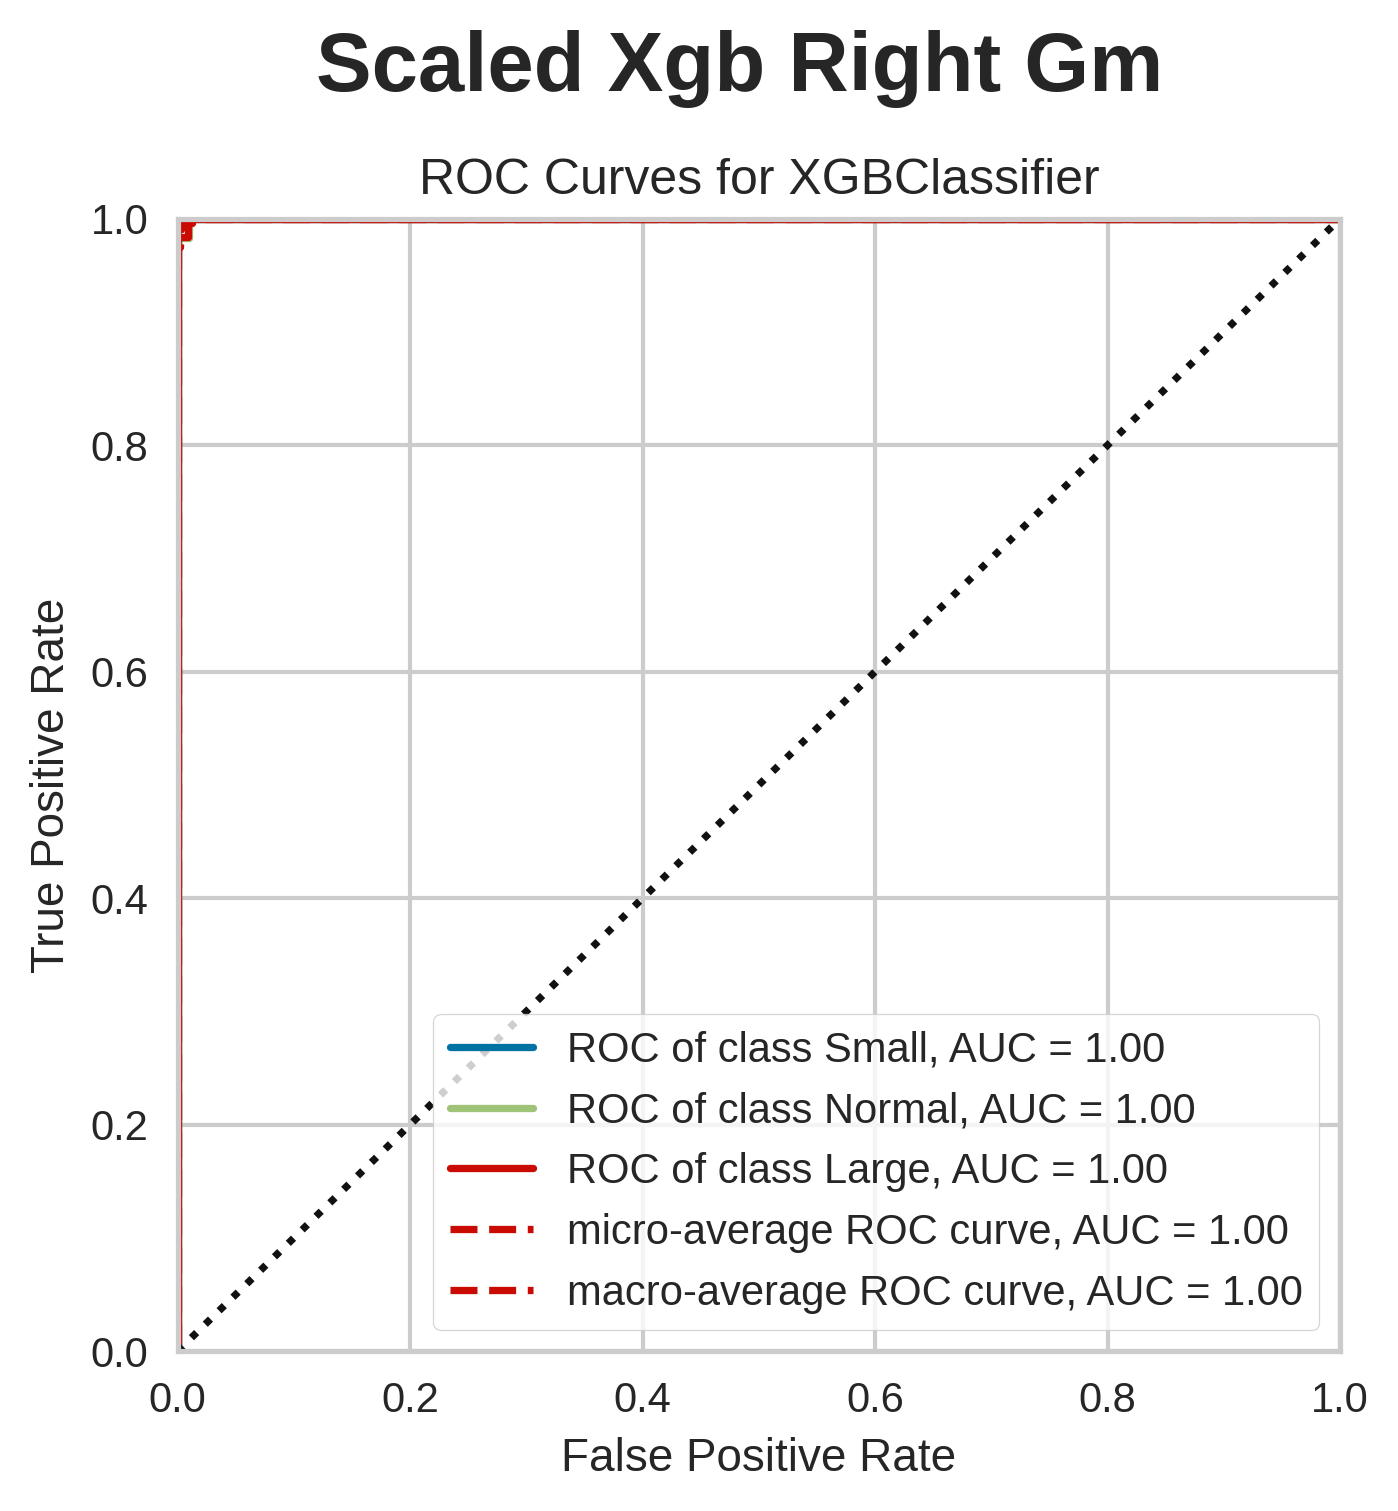

Best Model for Left_cerebellum:
	Model Name: Scaled_Logistic_Left_cerebellum
	Model Place: 0


X does not have valid feature names, but LogisticRegression was fitted with feature names


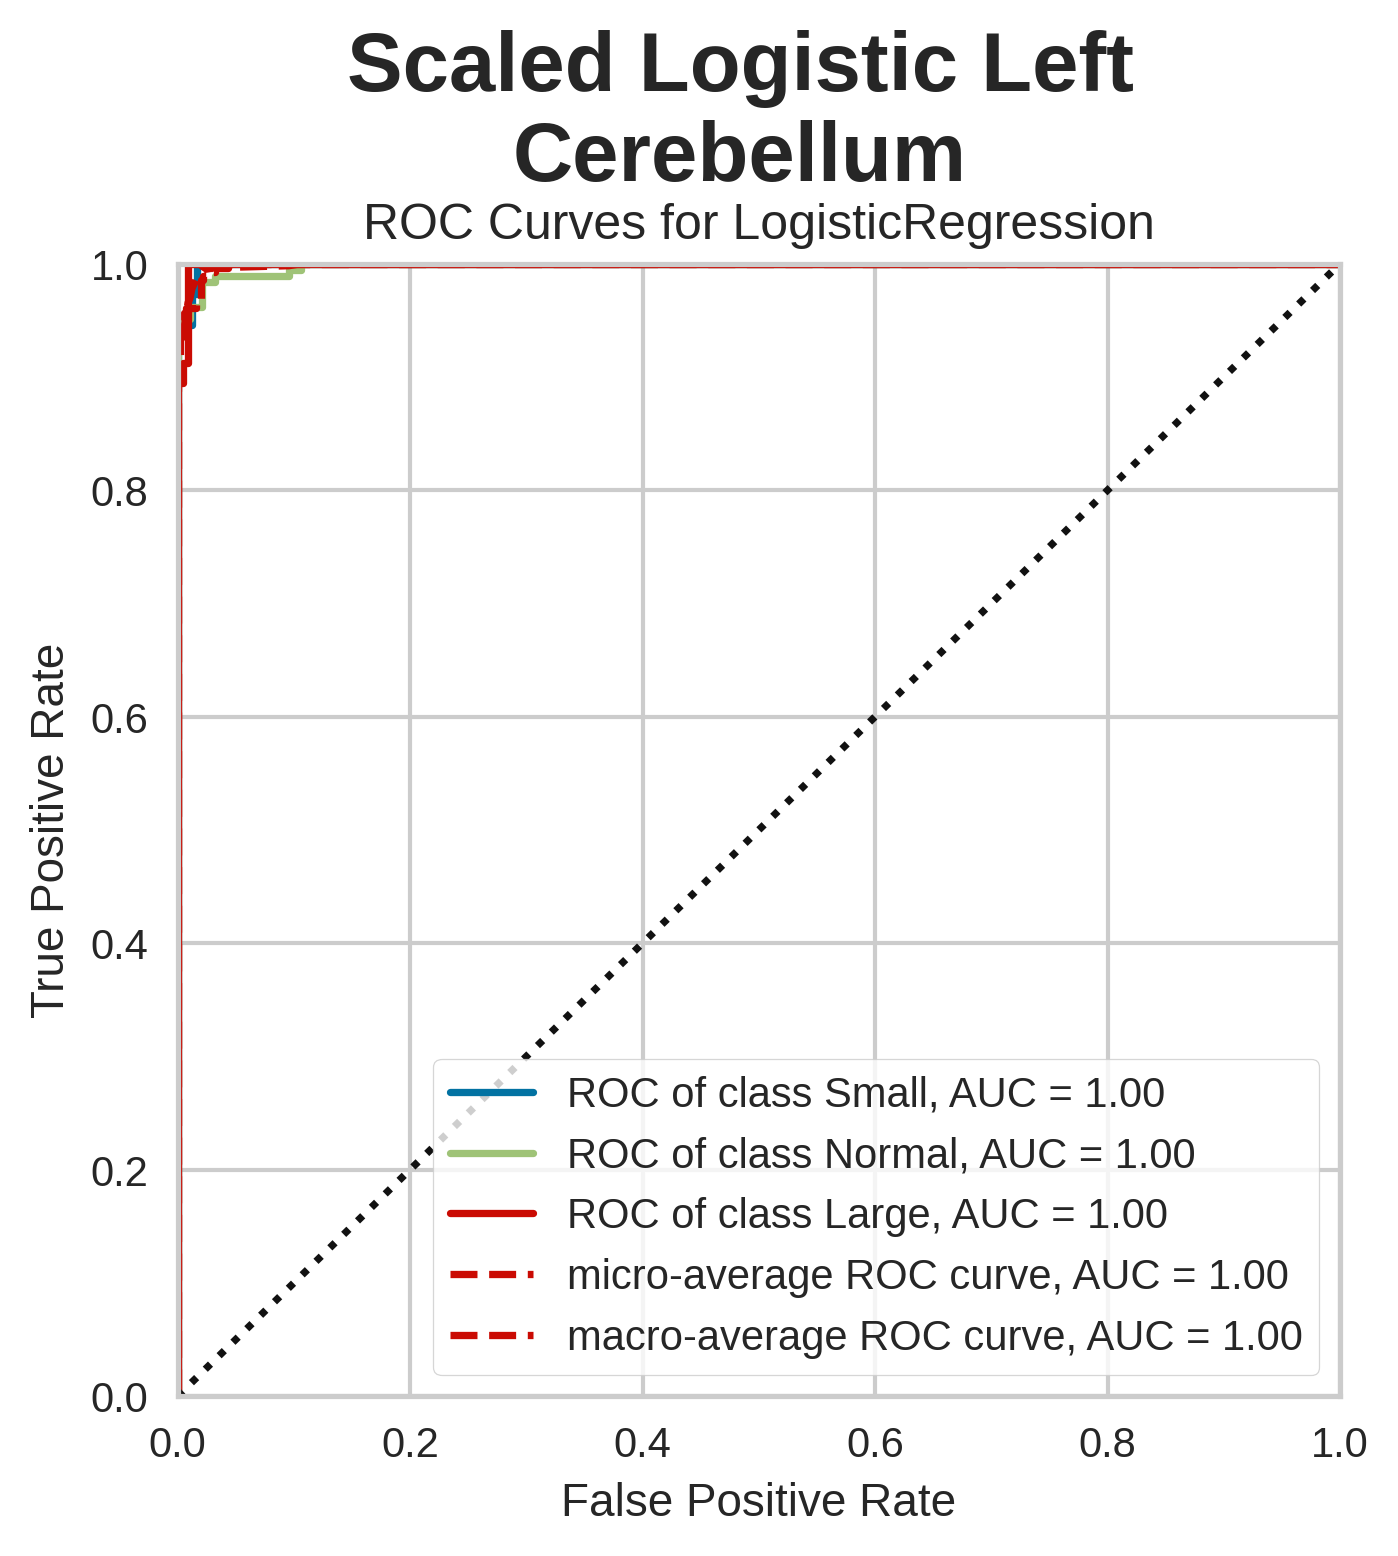

	Model Name: Raw_xGB_Left_cerebellum
	Model Place: 1


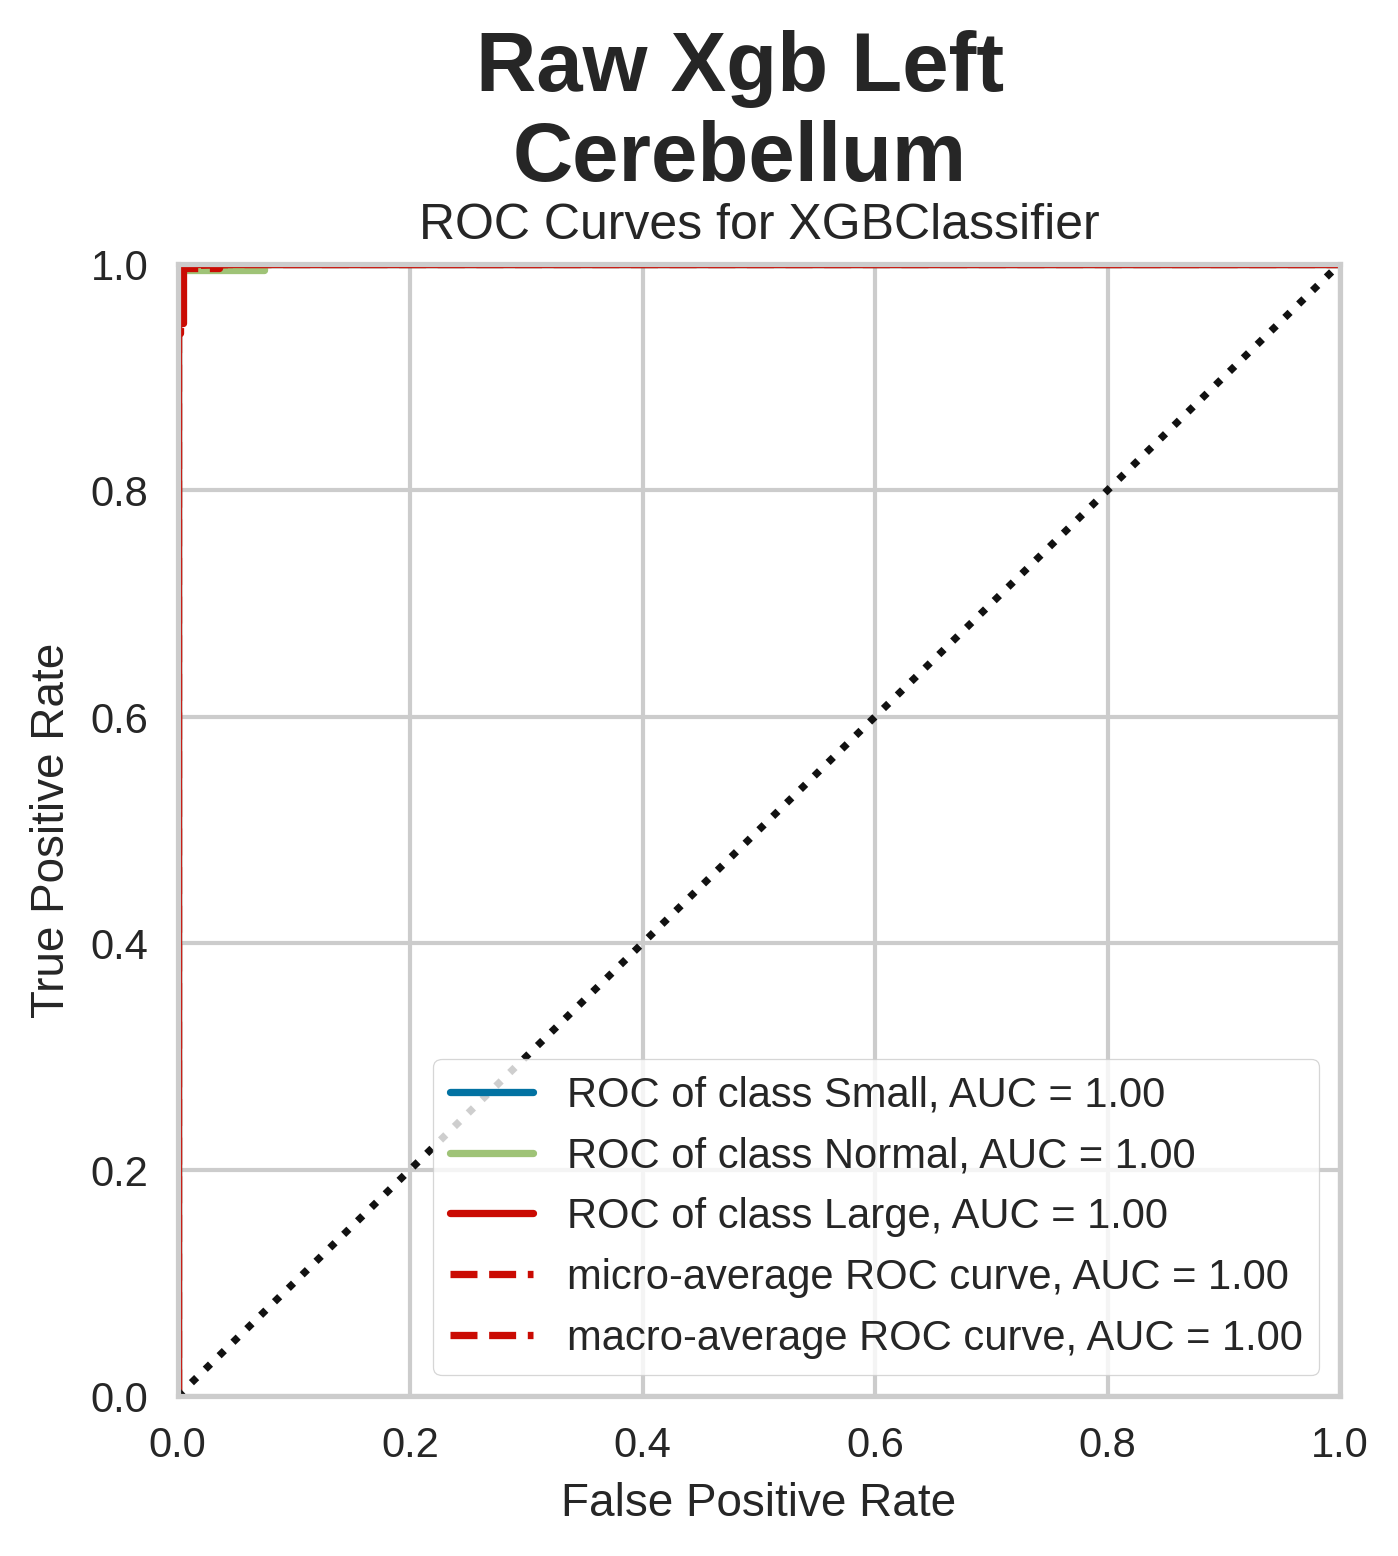

	Model Name: Scaled_xGB_Left_cerebellum
	Model Place: 2


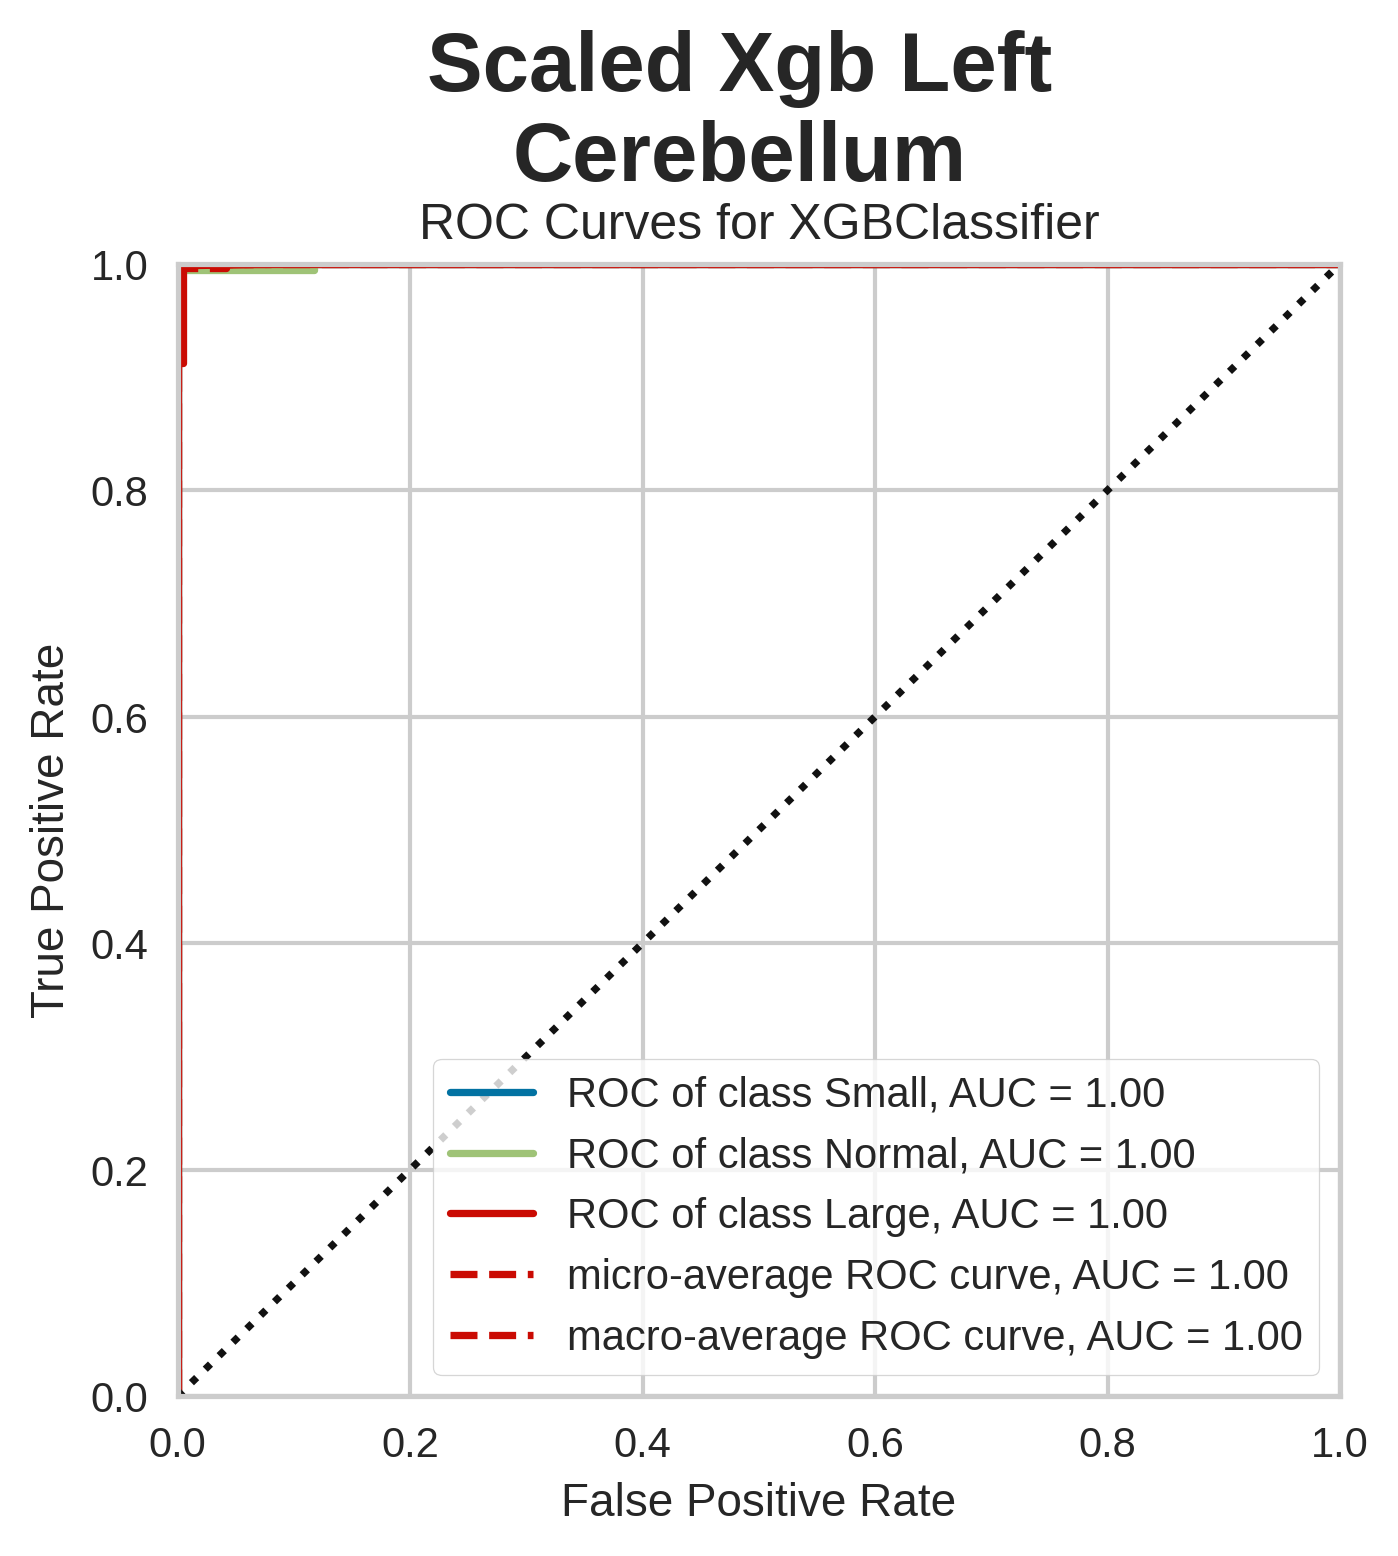

Best Model for Right_cerebellum:
	Model Name: Scaled_Logistic_Right_cerebellum
	Model Place: 0


X does not have valid feature names, but LogisticRegression was fitted with feature names


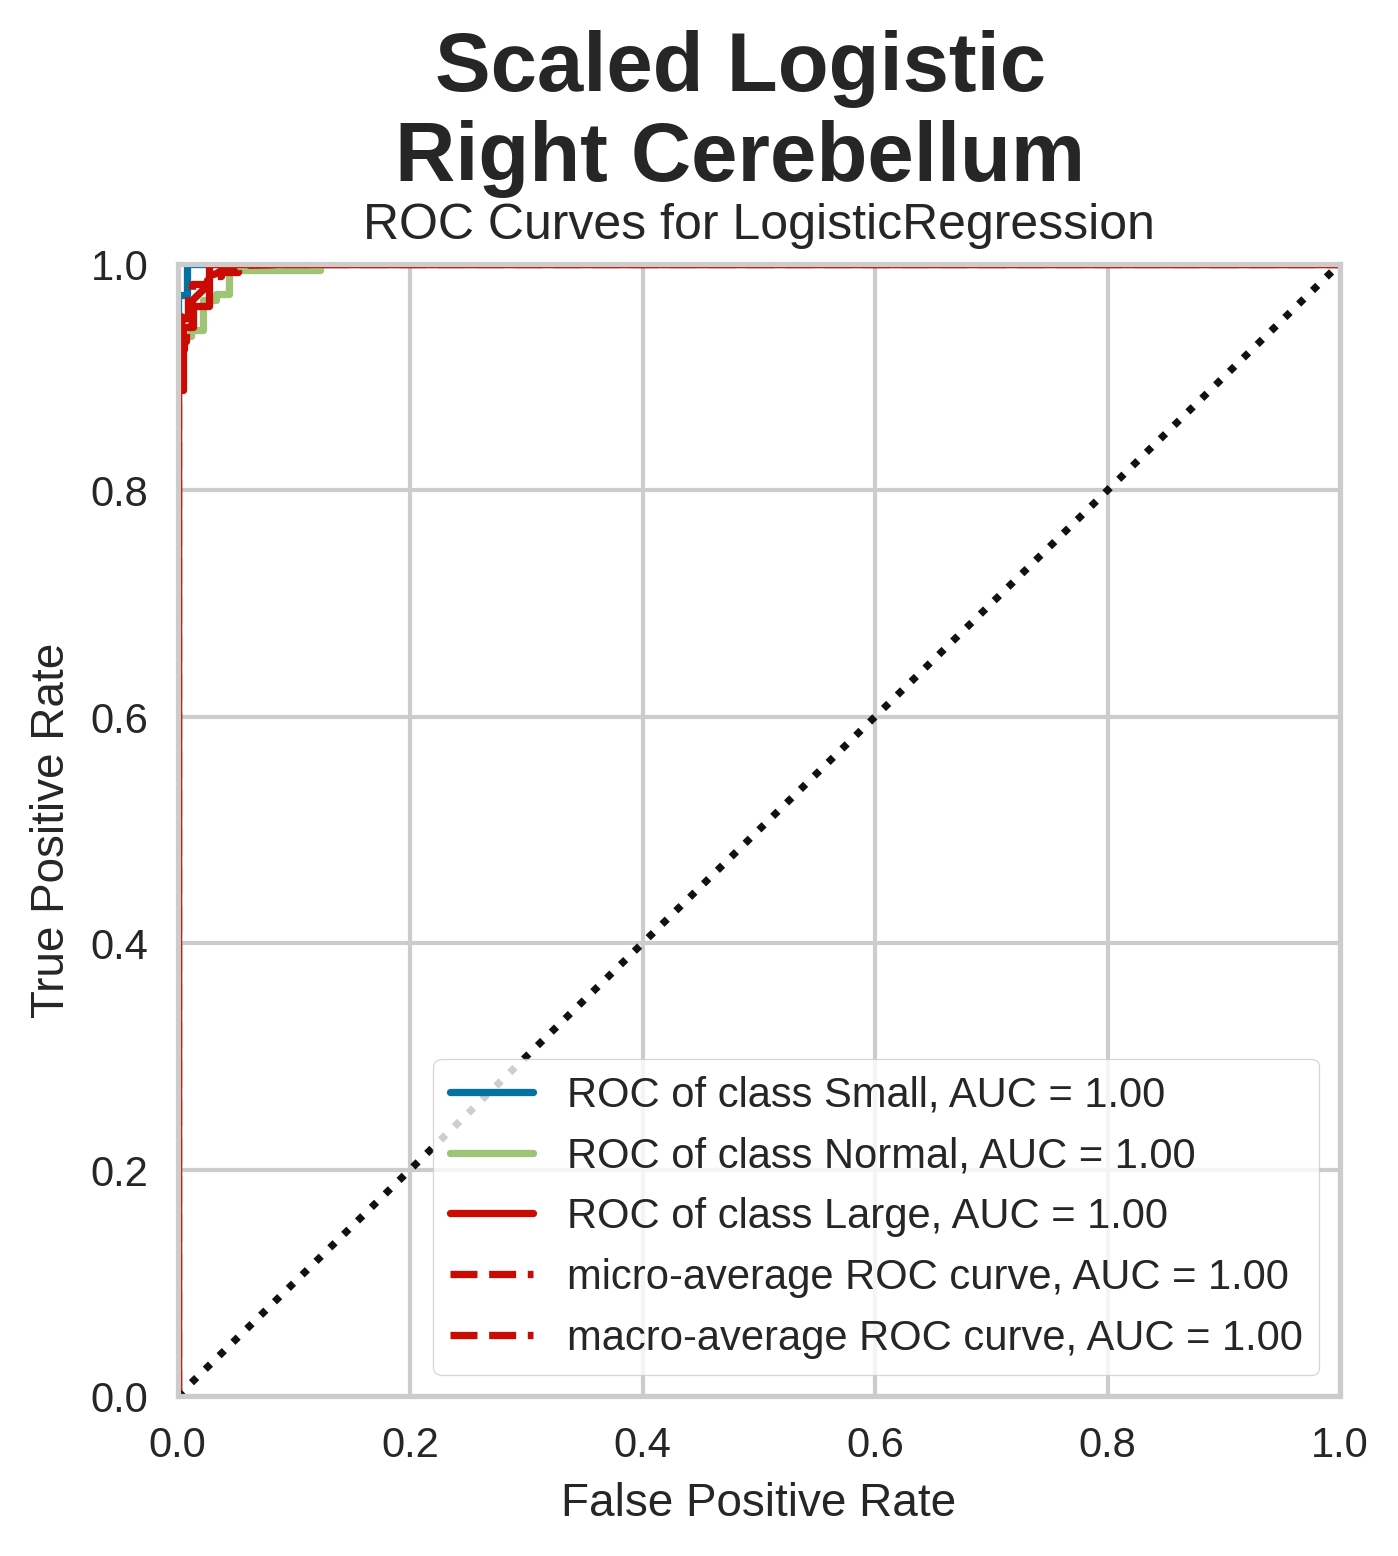

	Model Name: Raw_xGB_Right_cerebellum
	Model Place: 1


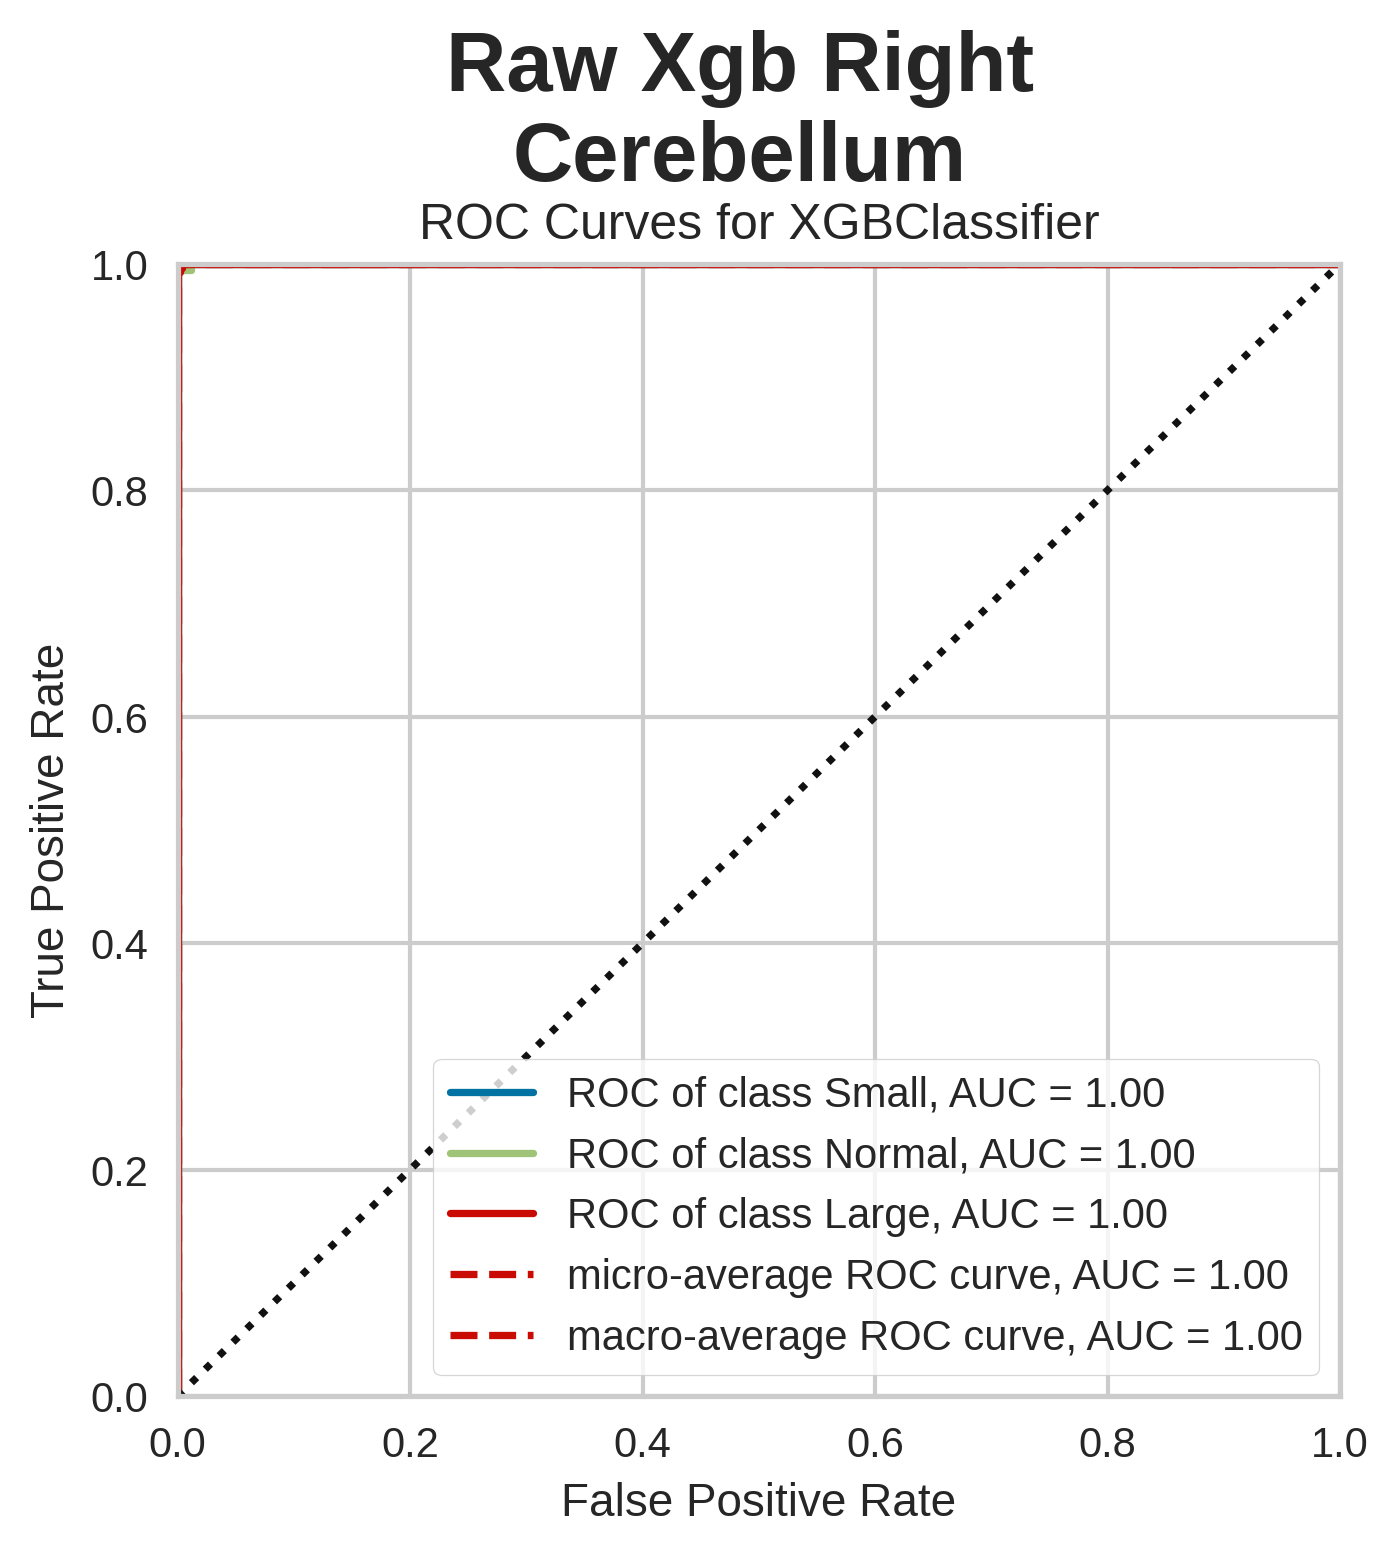

	Model Name: Scaled_xGB_Right_cerebellum
	Model Place: 2


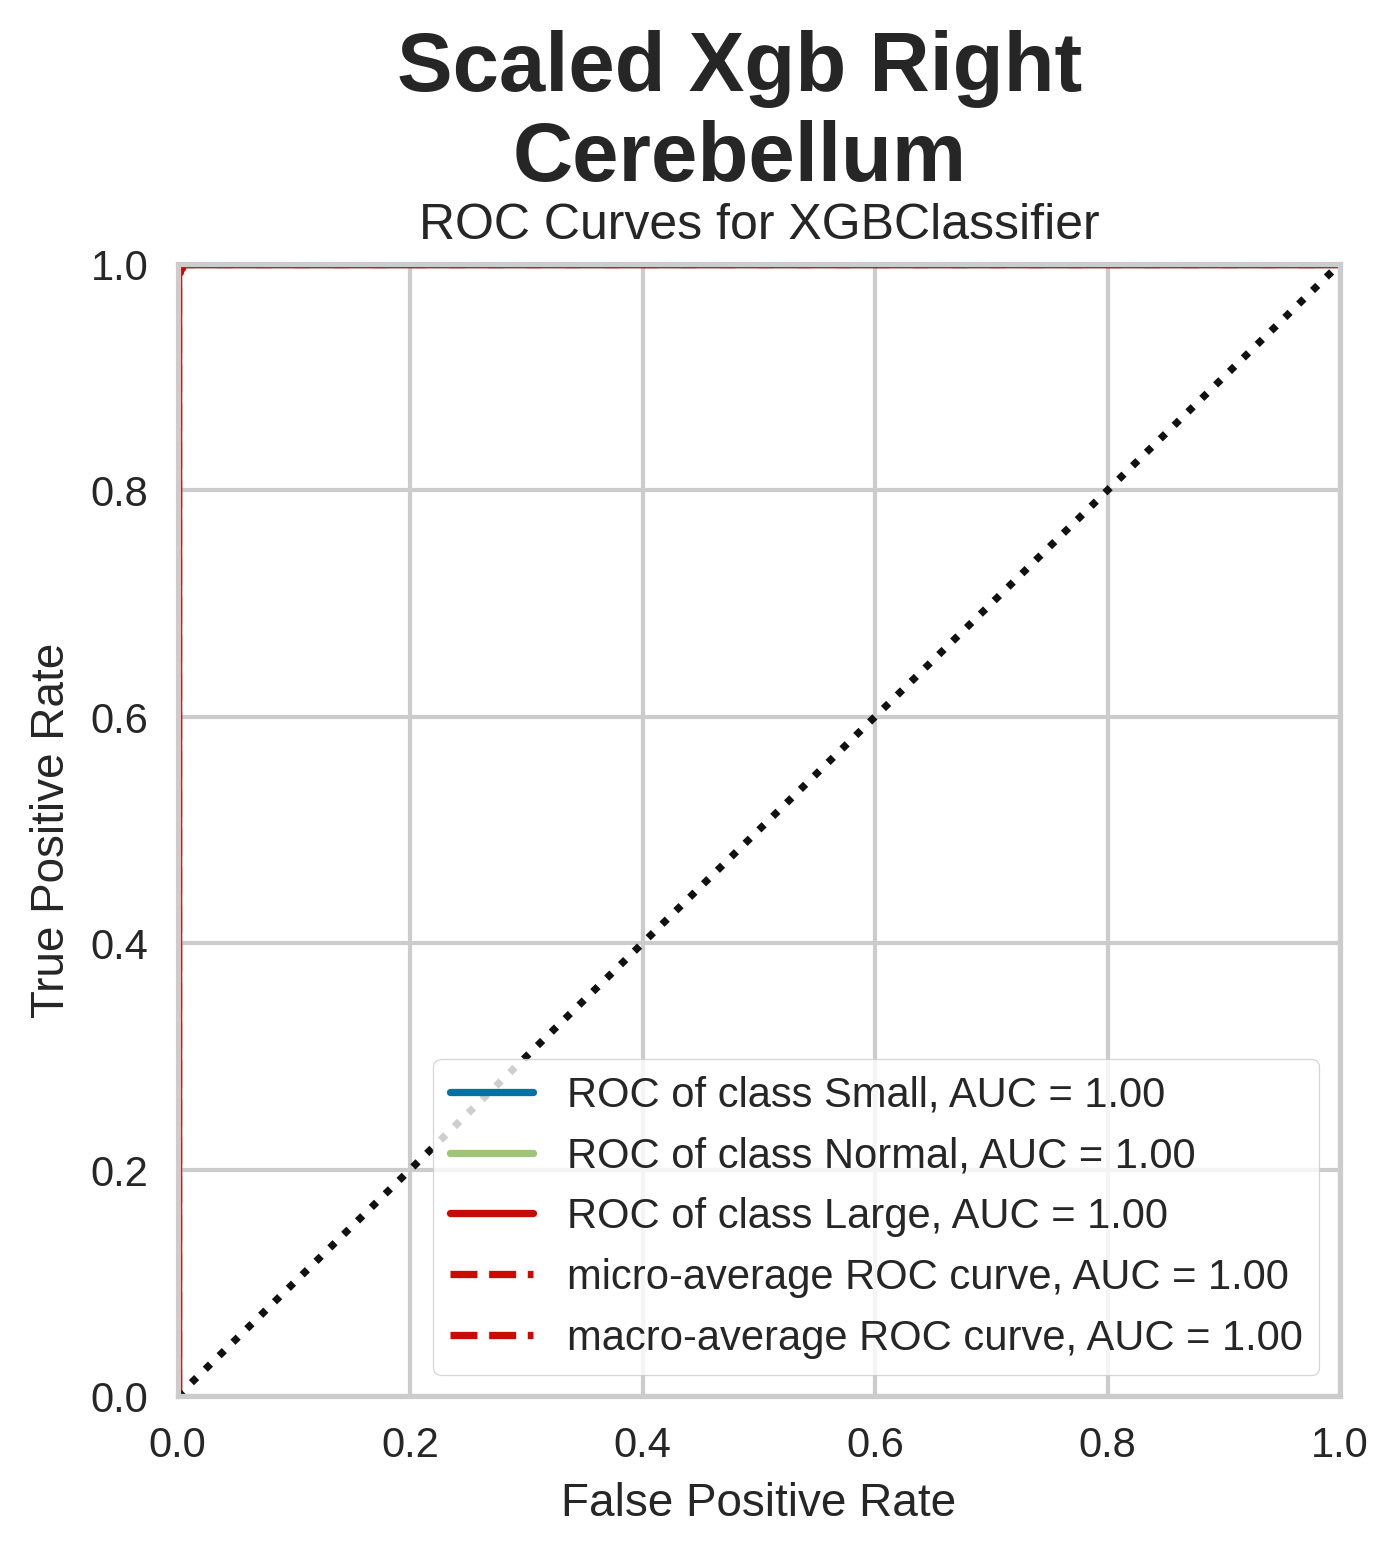

In [126]:
roc_save_dir = os.path.join(storage_dir, 'auroc_figures', 'no_shape')
os.makedirs(roc_save_dir, exist_ok = True)

for s, phrase in zip(struc_result, phrases):
    print("Best Model for {}:".format(phrase))
    obj = s[0]
    for i in range(3):
        obj = s[i]
        print("\tModel Name: {}\n\tModel Place: {}".format(obj[0], i))
        #plot_roc(obj[5], obj[6], title = obj[0], save_path = roc_save_dir, disp = True)
        plot_yellowbrick_roc(obj[5], obj[6], title = obj[0], save_path = roc_save_dir, disp = True)


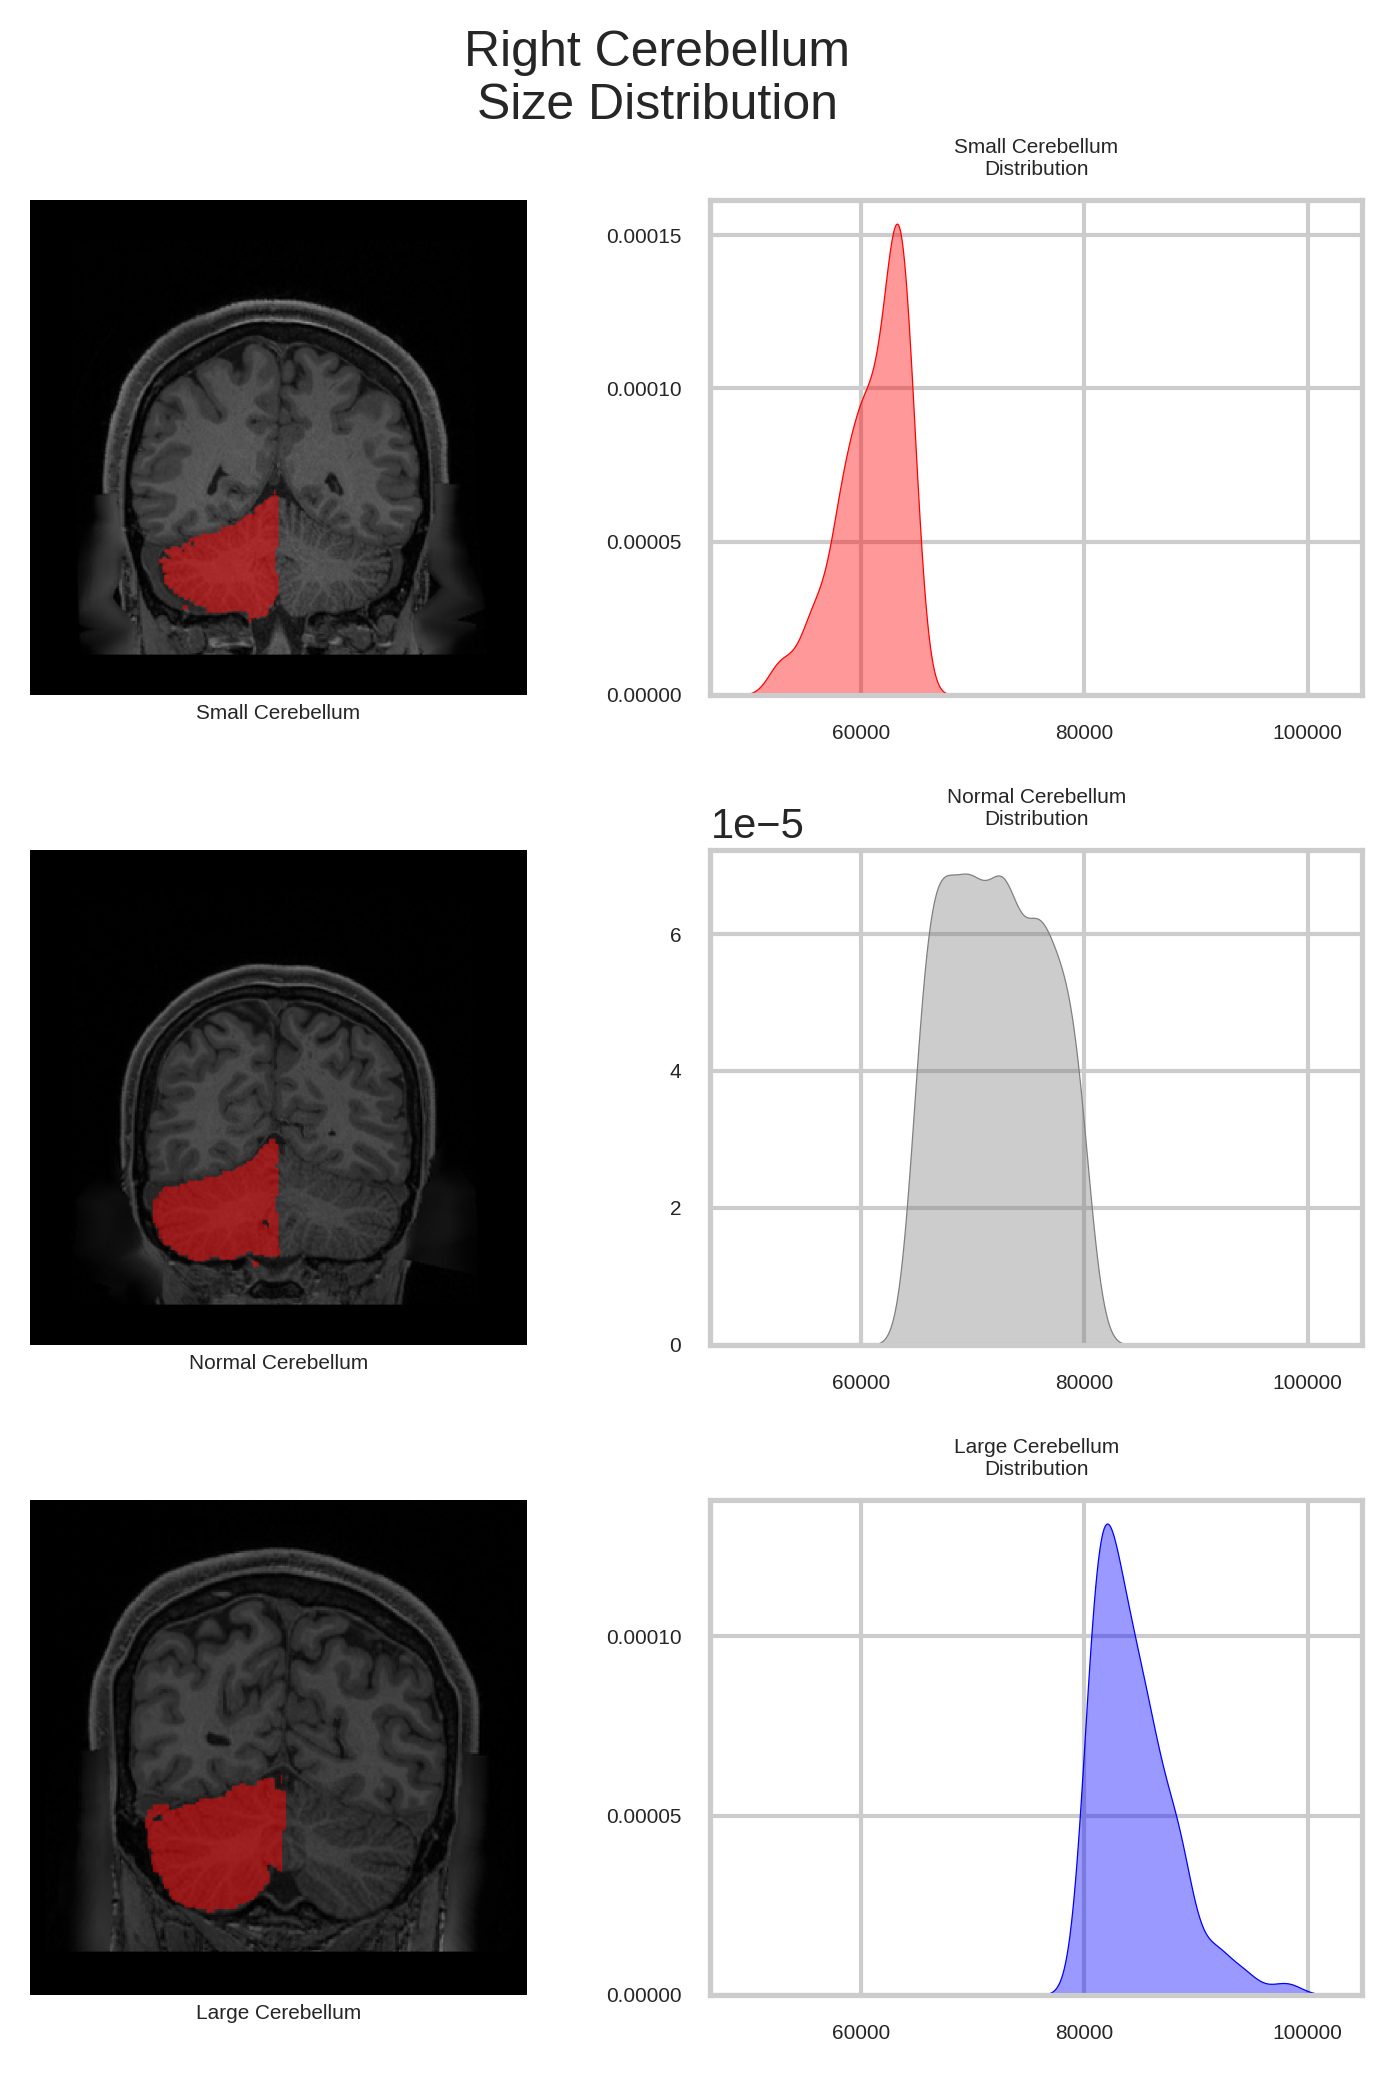

In [133]:
# Generate distribtuion figures

from PIL import Image

fig = plt.figure(figsize = (5, 7),facecolor = 'white', dpi = 300)

large_rcere = dfs[7].loc[:,dfs[7].iloc[-1,:] == 1].iloc[-2,:]
norm_rcere = dfs[7].loc[:,dfs[7].iloc[-1,:] == 0].iloc[-2,:]
small_rcere = dfs[7].loc[:,dfs[7].iloc[-1,:] == -1].iloc[-2,:]

im_path = '/media/billy/18CC-A3D3/bioeng1340/project/presentation_images'
im_small = os.path.join(im_path, 's_r_cere.png')
im_norm = os.path.join(im_path, 'n_r_cere.png')
im_large = os.path.join(im_path, 'l_r_cere.png')

text_args = {'fontsize': 5}

ax1 = fig.add_subplot(3, 2, 1)
ax1.set_axis_off()
im1 = Image.open(im_small)
ax_title = textwrap.fill('Small Cerebellum', 20)
ax1.set_title(ax_title, text_args, y = -0.1)
ax1 = plt.imshow(im1)


ax3 = fig.add_subplot(3, 2, 3)
ax3.set_axis_off()
im3 = Image.open(im_norm)
ax_title = textwrap.fill('Normal Cerebellum', 20)
ax3.set_title(ax_title, text_args, y = -0.1)
ax3 = plt.imshow(im3)

ax5 = fig.add_subplot(3, 2, 5)
ax5.set_axis_off()
im5 = Image.open(im_large)
ax_title = textwrap.fill('Large Cerebellum', 20)
ax5.set_title(ax_title, text_args, y = -0.1)
ax5 = plt.imshow(im5)

ax2 = fig.add_subplot(3, 2, 2)
ax2 = sns.kdeplot(small_rcere, color = 'red', alpha = 0.4, shade = True, legend = 'Small', linewidth = 0.3)
ax_title = textwrap.fill('Small Cerebellum Distribution', 20)
ax2.set_title(ax_title, text_args)

ax4 = fig.add_subplot(3, 2, 4, sharex = ax2)
ax4 = sns.kdeplot(norm_rcere, color = 'grey', alpha = 0.4, shade = True, legend = 'Normal', linewidth = 0.3)
ax_title = textwrap.fill('Normal Cerebellum Distribution', 20)
ax4.set_title(ax_title, text_args)

ax6 = fig.add_subplot(3, 2, 6, sharex = ax4)
ax6 = sns.kdeplot(large_rcere, color = 'blue', alpha = 0.4, shade = True, legend = 'Large', linewidth = 0.3)
ax_title = textwrap.fill('Large Cerebellum Distribution', 20)
ax6.set_title(ax_title, text_args)


font_dict = {'ha':'center', 'fontsize':5, 'fontweight':'normal'}
main_title = textwrap.fill('Right Cerebellum Size Distribution', 20)
fig.suptitle(main_title, fontdict = font_dict)

for ax in [ax2, ax4, ax6]:
    #ax.axes.yaxis.set_visible(False)
    ax.set(xlabel = None)
    ax.set(ylabel = None)

    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(5)
plt.subplots_adjust(hspace = 0.3)
plt.tight_layout(rect = [0, 0, 1, .95])
plt.show()